In [9]:
source("/Users/wyx/Desktop/dissertation/wholecode.R")

In [10]:
library(xgboost)
library(pROC)
library(DescTools)
library(ModelMetrics)
library(rms)

In [11]:
# 定义 generate_gradual_shifted_data 函数
generate_event_rate_shifted_data_1_ml <- function(seed, target_mortality_start, target_mortality_end) {
  set.seed(seed)
  data <- generate_event_rate_shifted_data(
    time_periods = 2,
    n = 9602,
    target_mortality_start = target_mortality_start,
    target_mortality_end = target_mortality_end,
    age_mean = 64.6,
    age_sd = 12.5,
    sex_prob = 0.309,
    cpd_prob = 0.107,
    pcs_prob = 0.282,
    cps_prob = 0.241, 
    beta_age = 0.0285181, 
    beta_cps = 1.086517,
    beta_sex = 0.2196434,
    beta_cpd = 0.1886564,
    beta_pcs = 1.118599
  )
  return(data)
}

In [12]:
experiments <- list(
  list(name = "motality: 0.2000,0.2000", target_mortality_start = 0.2000, target_mortality_end = 0.2000),
  list(name = "motality: 0.2000,0.2154", target_mortality_start = 0.2154, target_mortality_end = 0.2000),
  list(name = "motality: 0.2000,0.2321", target_mortality_start = 0.2321, target_mortality_end = 0.2000),
  list(name = "motality: 0.2000,0.2500", target_mortality_start = 0.2500, target_mortality_end = 0.2000),
  list(name = "motality: 0.2000,0.2693", target_mortality_start = 0.2693, target_mortality_end = 0.2000),
  list(name = "motality: 0.2000,0.2901", target_mortality_start = 0.2901, target_mortality_end = 0.2000),
  list(name = "motality: 0.2000,0.3125", target_mortality_start = 0.3125, target_mortality_end = 0.2000),
  list(name = "motality: 0.2000,0.3366", target_mortality_start = 0.3366, target_mortality_end = 0.2000),
  list(name = "motality: 0.2000,0.3626", target_mortality_start = 0.3626, target_mortality_end = 0.2000),
  list(name = "motality: 0.2000,0.3906", target_mortality_start = 0.3906, target_mortality_end = 0.2000)
)


In [13]:
# 循环200个随机种子，生成数据并计算性能指标
set.seed(123)  # 确保结果可重复
num_simulations <- 200

results_event_rate_shift_ml <- data.frame()

for (exp in experiments) {
    results <- data.frame(auc = numeric(num_simulations), o_e = numeric(num_simulations), c_slope = numeric(num_simulations), brier_score = numeric(num_simulations))
    for (i in 1:num_simulations) {
      # 设置随机种子
      set.seed(i)

      data_shifted_xgb <- generate_event_rate_shifted_data_1_ml(i, exp$target_mortality_start, exp$target_mortality_end)

      # 确保 mortality 变量是因子类型
      data_shifted_xgb$mortality <- as.factor(data_shifted_xgb$mortality)
      data_val$mortality <- as.factor(data_val$mortality)

      # 转换数据格式
      dtrain <- xgb.DMatrix(data = as.matrix(data_shifted_xgb[, -6]), label = as.numeric(data_shifted_xgb$mortality) - 1)
      dval <- xgb.DMatrix(data = as.matrix(data_val[, -6]), label = as.numeric(data_val$mortality) - 1)

      # 设置参数
      params <- list(
        booster = "gbtree",
        objective = "binary:logistic",
        eta = 0.1,
        max_depth = 3,
        eval_metric = "auc"
      )

      # 训练模型
      xgb_model <- xgb.train(params, dtrain, nrounds = 50)


      # 预测
      predictions <- predict(xgb_model, dval)

      # 确保测试集的mortality变量是二进制数值类型
      test_mortality <- as.numeric(data_val$mortality) - 1

      # 计算 AUC
      auc <- roc(data_val$mortality, predictions)$auc
      print(paste("auc:", auc))

      # 绘制 ROC 曲线
      #plot.roc(roc_obj, main = paste("ROC Curve (AUC =", round(auc_value, 2), ")"), col = "blue")

       # 计算O/E
      o_e <- sum(test_mortality) / sum(predictions)
      print(paste("O/E 比率:", o_e))

      # 计算校准斜率 (C-slope)
      # 绘制校准曲线并提取斜率
      calibration <- val.prob(predictions, test_mortality, xlab="Predicted Probability", ylab="Observed Probability", pl = FALSE, smooth = FALSE)

      c_slope <- calibration["Slope"]

      print(paste("c_slope:", c_slope))

      # 计算 Brier 分数
      brier_score <- BrierScore(test_mortality, predictions)
      print(paste("Brier 分数:", brier_score))

      # 保存结果
      results[i, ] <- c(auc = auc, o_e = o_e, c_slope = c_slope, brier_score = brier_score)

    }

    # 计算中位数、25%和75%的性能指标
    median_metrics_event_rate_shift_ml <- apply(results, 2, median)
    quantile_25_metrics_event_rate_shift_ml <- apply(results, 2, quantile, probs = 0.25)
    quantile_75_metrics_event_rate_shift_ml <- apply(results, 2, quantile, probs = 0.75)

    # 将实验名称和结果添加到总的结果数据框
    summary_metrics_event_rate_shift_ml <- data.frame(
    experiment = exp$name,
    auc_median = median_metrics_event_rate_shift_ml['auc'],
    auc_25 = quantile_25_metrics_event_rate_shift_ml['auc'],
    auc_75 = quantile_75_metrics_event_rate_shift_ml['auc'],
    o_e_median = median_metrics_event_rate_shift_ml['o_e'],
    o_e_25 = quantile_25_metrics_event_rate_shift_ml['o_e'],
    o_e_75 = quantile_75_metrics_event_rate_shift_ml['o_e'],
    c_slope_median = median_metrics_event_rate_shift_ml['c_slope'],
    c_slope_25 = quantile_25_metrics_event_rate_shift_ml['c_slope'],
    c_slope_75 = quantile_75_metrics_event_rate_shift_ml['c_slope'],
    brier_score_median = median_metrics_event_rate_shift_ml['brier_score'],
    brier_score_25 = quantile_25_metrics_event_rate_shift_ml['brier_score'],
    brier_score_75 = quantile_75_metrics_event_rate_shift_ml['brier_score']
    )
    
    results_event_rate_shift_ml <- rbind(results_event_rate_shift_ml, summary_metrics_event_rate_shift_ml)
    
}




Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721773029066186"
[1] "O/E 比率: 1.00492761969956"
[1] "c_slope: 1.08214770411894"
[1] "Brier 分数: 0.144193146413868"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723537064337265"
[1] "O/E 比率: 0.955001966760982"
[1] "c_slope: 1.19941220580017"
[1] "Brier 分数: 0.143980096355089"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723517811564865"
[1] "O/E 比率: 0.988600208928995"
[1] "c_slope: 1.08122462022372"
[1] "Brier 分数: 0.143396795196087"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718153507855131"
[1] "O/E 比率: 1.00164799288804"
[1] "c_slope: 1.09493627589171"
[1] "Brier 分数: 0.144258225653696"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720014150787713"
[1] "O/E 比率: 0.990912345614894"
[1] "c_slope: 1.10504295691046"
[1] "Brier 分数: 0.143862397757292"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721534432208238"
[1] "O/E 比率: 0.980381851326794"
[1] "c_slope: 1.14469027901473"
[1] "Brier 分数: 0.144227573403214"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719648348112128"
[1] "O/E 比率: 1.01156058928414"
[1] "c_slope: 1.07812913234873"
[1] "Brier 分数: 0.144121861068161"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721309587330576"
[1] "O/E 比率: 1.013353877848"
[1] "c_slope: 1.16546988223026"
[1] "Brier 分数: 0.144503858186405"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720519192263686"
[1] "O/E 比率: 1.00380396563145"
[1] "c_slope: 1.08266387156942"
[1] "Brier 分数: 0.143922795971256"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723186045040486"
[1] "O/E 比率: 0.961384802333983"
[1] "c_slope: 1.09138901561778"
[1] "Brier 分数: 0.143441053126001"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722764203045238"
[1] "O/E 比率: 0.975505984934262"
[1] "c_slope: 1.15194171663635"
[1] "Brier 分数: 0.143565674468126"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723434268284633"
[1] "O/E 比率: 1.00002338347098"
[1] "c_slope: 1.08297112810434"
[1] "Brier 分数: 0.14376233763498"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723621295216511"
[1] "O/E 比率: 0.963476042054943"
[1] "c_slope: 1.10251095762575"
[1] "Brier 分数: 0.143748661478479"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725633897531245"
[1] "O/E 比率: 0.960293245989541"
[1] "c_slope: 1.12579976032525"
[1] "Brier 分数: 0.143565836560028"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722663813589157"
[1] "O/E 比率: 0.992408386265836"
[1] "c_slope: 1.12549976028033"
[1] "Brier 分数: 0.143953623869618"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724901260781553"
[1] "O/E 比率: 0.98253959437278"
[1] "c_slope: 1.11271174865818"
[1] "Brier 分数: 0.143456058719802"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718222611556064"
[1] "O/E 比率: 0.972111215569476"
[1] "c_slope: 1.08646702289099"
[1] "Brier 分数: 0.14480868564646"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718867235631931"
[1] "O/E 比率: 0.990987687379142"
[1] "c_slope: 1.0885341247816"
[1] "Brier 分数: 0.144057998674571"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724745519604823"
[1] "O/E 比率: 0.98525081316553"
[1] "c_slope: 1.10197665952435"
[1] "Brier 分数: 0.143919637951351"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721977589772927"
[1] "O/E 比率: 1.00955321993512"
[1] "c_slope: 1.05632875400863"
[1] "Brier 分数: 0.143874405414578"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723913180998064"
[1] "O/E 比率: 0.956587804879745"
[1] "c_slope: 1.10051123034114"
[1] "Brier 分数: 0.143999623480913"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721604223508185"
[1] "O/E 比率: 1.02228212932954"
[1] "c_slope: 1.10644411438837"
[1] "Brier 分数: 0.143798301650612"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722296635715543"
[1] "O/E 比率: 1.00741433498967"
[1] "c_slope: 1.0857379651699"
[1] "Brier 分数: 0.144227347424541"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719624282146629"
[1] "O/E 比率: 0.992331424048872"
[1] "c_slope: 1.07162392463457"
[1] "Brier 分数: 0.14442149970526"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724156934848618"
[1] "O/E 比率: 0.959244298177372"
[1] "c_slope: 1.16468474061115"
[1] "Brier 分数: 0.143503153158902"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722217218029396"
[1] "O/E 比率: 0.974062476438774"
[1] "c_slope: 1.10558388222966"
[1] "Brier 分数: 0.143733954307426"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72652777624978"
[1] "O/E 比率: 0.948332262681202"
[1] "c_slope: 1.18464430915877"
[1] "Brier 分数: 0.143146221351797"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721514148037317"
[1] "O/E 比率: 1.00651409833317"
[1] "c_slope: 1.11592326297214"
[1] "Brier 分数: 0.144268976712476"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718718714244851"
[1] "O/E 比率: 0.986485190547384"
[1] "c_slope: 1.04714626208707"
[1] "Brier 分数: 0.144818000000561"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719457539385671"
[1] "O/E 比率: 1.00627567031853"
[1] "c_slope: 1.07485945615222"
[1] "Brier 分数: 0.144509686816446"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723380291762014"
[1] "O/E 比率: 0.979328921746256"
[1] "c_slope: 1.13750133996741"
[1] "Brier 分数: 0.143370121369158"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722061476852667"
[1] "O/E 比率: 0.99093894726061"
[1] "c_slope: 1.09037980843788"
[1] "Brier 分数: 0.143984266768799"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724335710592325"
[1] "O/E 比率: 1.00222333435687"
[1] "c_slope: 1.16592972837149"
[1] "Brier 分数: 0.143717971144744"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724468761001584"
[1] "O/E 比率: 1.02367389625555"
[1] "c_slope: 1.0839218170054"
[1] "Brier 分数: 0.143664779967634"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721550246985566"
[1] "O/E 比率: 1.00998790239816"
[1] "c_slope: 1.10051574732354"
[1] "Brier 分数: 0.143406783751875"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720305348970252"
[1] "O/E 比率: 0.978532846593878"
[1] "c_slope: 1.12384210269821"
[1] "Brier 分数: 0.144094934153727"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719419033840873"
[1] "O/E 比率: 1.03674577821105"
[1] "c_slope: 1.14236914460482"
[1] "Brier 分数: 0.144900043242548"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724380060728745"
[1] "O/E 比率: 0.972210700260228"
[1] "c_slope: 1.13756868092105"
[1] "Brier 分数: 0.143891547505863"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723468304435839"
[1] "O/E 比率: 0.982927147535179"
[1] "c_slope: 1.18853754198297"
[1] "Brier 分数: 0.143988741966043"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721669201615033"
[1] "O/E 比率: 1.00988965174407"
[1] "c_slope: 1.09406582947784"
[1] "Brier 分数: 0.143979356230844"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71953076868069"
[1] "O/E 比率: 1.01729952225077"
[1] "c_slope: 1.08573921299724"
[1] "Brier 分数: 0.144730412945924"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720299160579123"
[1] "O/E 比率: 1.01138910560137"
[1] "c_slope: 1.03042402206373"
[1] "Brier 分数: 0.144023425676649"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721501771255061"
[1] "O/E 比率: 1.00160504983675"
[1] "c_slope: 1.09948284011625"
[1] "Brier 分数: 0.143937404869003"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723565599696356"
[1] "O/E 比率: 1.00666514052442"
[1] "c_slope: 1.09080739396335"
[1] "Brier 分数: 0.143730306611837"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72121091687203"
[1] "O/E 比率: 1.02483408757357"
[1] "c_slope: 1.09660168123487"
[1] "Brier 分数: 0.144272641465091"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721580501342193"
[1] "O/E 比率: 0.988844873352793"
[1] "c_slope: 1.10156960696854"
[1] "Brier 分数: 0.14398102194156"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718611792598134"
[1] "O/E 比率: 0.986224493186296"
[1] "c_slope: 1.05093638019653"
[1] "Brier 分数: 0.144997199617433"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721488019274776"
[1] "O/E 比率: 0.961168824217245"
[1] "c_slope: 1.12714126929008"
[1] "Brier 分数: 0.143606187345784"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722761108849674"
[1] "O/E 比率: 0.983298375105411"
[1] "c_slope: 1.12782919988439"
[1] "Brier 分数: 0.143872276838606"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718509684144517"
[1] "O/E 比率: 0.990792222827176"
[1] "c_slope: 1.11536243474758"
[1] "Brier 分数: 0.144995925808882"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720939659060905"
[1] "O/E 比率: 1.02433550733258"
[1] "c_slope: 1.09485439512072"
[1] "Brier 分数: 0.144384199505344"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720328039737722"
[1] "O/E 比率: 0.989619673513951"
[1] "c_slope: 1.09277588602432"
[1] "Brier 分数: 0.144081498689691"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71853203111248"
[1] "O/E 比率: 1.03443269117005"
[1] "c_slope: 1.16055633480838"
[1] "Brier 分数: 0.144871913265688"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720825173825031"
[1] "O/E 比率: 0.954103875351946"
[1] "c_slope: 1.09999988495478"
[1] "Brier 分数: 0.143931517815111"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721681922196796"
[1] "O/E 比率: 0.984049519281821"
[1] "c_slope: 1.16604992002793"
[1] "Brier 分数: 0.143815202762256"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723565255896849"
[1] "O/E 比率: 0.982226013820414"
[1] "c_slope: 1.11117886979068"
[1] "Brier 分数: 0.143690670288751"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720846145594966"
[1] "O/E 比率: 1.00423153571727"
[1] "c_slope: 1.12897735149329"
[1] "Brier 分数: 0.143864348043825"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721081648257349"
[1] "O/E 比率: 1.03208969092499"
[1] "c_slope: 1.1020153841334"
[1] "Brier 分数: 0.144250924527425"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723308093865517"
[1] "O/E 比率: 0.995894180355195"
[1] "c_slope: 0.999320708645806"
[1] "Brier 分数: 0.14402354839294"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723802133757261"
[1] "O/E 比率: 0.969203324128175"
[1] "c_slope: 1.21463813206208"
[1] "Brier 分数: 0.14406641565702"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720696592809364"
[1] "O/E 比率: 1.01858315058124"
[1] "c_slope: 1.16945595561088"
[1] "Brier 分数: 0.143855300954661"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722455814887344"
[1] "O/E 比率: 0.99809777816261"
[1] "c_slope: 1.107123707382"
[1] "Brier 分数: 0.143951358191568"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724391749911987"
[1] "O/E 比率: 0.985660817585286"
[1] "c_slope: 1.15766812095294"
[1] "Brier 分数: 0.144159462485089"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722325858673649"
[1] "O/E 比率: 0.990553624593658"
[1] "c_slope: 1.16414429716115"
[1] "Brier 分数: 0.14352528028399"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723727529264214"
[1] "O/E 比率: 1.01216745784637"
[1] "c_slope: 1.09597739714325"
[1] "Brier 分数: 0.144042603768689"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718064807582292"
[1] "O/E 比率: 1.01778598447807"
[1] "c_slope: 1.10005998399"
[1] "Brier 分数: 0.144730795729179"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718859328243267"
[1] "O/E 比率: 0.978495712775133"
[1] "c_slope: 1.04907594590262"
[1] "Brier 分数: 0.144231928800968"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718187887805844"
[1] "O/E 比率: 0.968970158474719"
[1] "c_slope: 1.11462393648917"
[1] "Brier 分数: 0.144468690117076"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721733492122866"
[1] "O/E 比率: 0.978190885634165"
[1] "c_slope: 1.11598708743079"
[1] "Brier 分数: 0.143803422240481"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719298016414364"
[1] "O/E 比率: 1.04905447736107"
[1] "c_slope: 1.10073182956141"
[1] "Brier 分数: 0.144633366073178"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71920622194596"
[1] "O/E 比率: 0.958204588033341"
[1] "c_slope: 1.16975918002564"
[1] "Brier 分数: 0.144176151239989"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720595859553776"
[1] "O/E 比率: 0.958535939397503"
[1] "c_slope: 1.10110890024731"
[1] "Brier 分数: 0.143767920152287"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724364933550431"
[1] "O/E 比率: 0.998272961469656"
[1] "c_slope: 1.18035282711998"
[1] "Brier 分数: 0.143583885800241"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716860477908819"
[1] "O/E 比率: 0.989906764755968"
[1] "c_slope: 1.09178152553424"
[1] "Brier 分数: 0.145020936385575"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720041310948777"
[1] "O/E 比率: 0.987549690803267"
[1] "c_slope: 1.18379981552287"
[1] "Brier 分数: 0.144790032858102"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72124564062225"
[1] "O/E 比率: 0.979374201935071"
[1] "c_slope: 1.12261319804662"
[1] "Brier 分数: 0.144054646119511"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722138487942264"
[1] "O/E 比率: 0.99663421574182"
[1] "c_slope: 1.05628028335611"
[1] "Brier 分数: 0.143530874083994"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720377203067242"
[1] "O/E 比率: 0.990289023009322"
[1] "c_slope: 1.20877064132035"
[1] "Brier 分数: 0.144193678552244"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724860348640204"
[1] "O/E 比率: 0.959389510318655"
[1] "c_slope: 1.13362959498926"
[1] "Brier 分数: 0.143687182458367"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720546696224256"
[1] "O/E 比率: 0.995823392549264"
[1] "c_slope: 1.15361068703137"
[1] "Brier 分数: 0.144156826778291"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721675390006161"
[1] "O/E 比率: 1.00942472262035"
[1] "c_slope: 1.17364791999059"
[1] "Brier 分数: 0.144034495628454"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723937246963563"
[1] "O/E 比率: 0.990917049815677"
[1] "c_slope: 1.10653901023427"
[1] "Brier 分数: 0.143527451680596"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718982064667312"
[1] "O/E 比率: 0.974487911776267"
[1] "c_slope: 1.09671298921964"
[1] "Brier 分数: 0.144092839690553"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723077404396233"
[1] "O/E 比率: 0.986229042921932"
[1] "c_slope: 1.12846452224686"
[1] "Brier 分数: 0.143599620533002"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719323113778384"
[1] "O/E 比率: 1.03884842575409"
[1] "c_slope: 1.08845109236919"
[1] "Brier 分数: 0.144500668446982"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721005668566274"
[1] "O/E 比率: 0.962725275196765"
[1] "c_slope: 1.10087292311565"
[1] "Brier 分数: 0.143727412486695"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72582608145573"
[1] "O/E 比率: 0.989350972819394"
[1] "c_slope: 1.13714792043763"
[1] "Brier 分数: 0.143220411283444"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722895534456962"
[1] "O/E 比率: 1.00778013580143"
[1] "c_slope: 1.0549529841819"
[1] "Brier 分数: 0.143938021119769"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722144676333392"
[1] "O/E 比率: 0.994007300531325"
[1] "c_slope: 1.07946258825901"
[1] "Brier 分数: 0.143339317032178"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722610524665552"
[1] "O/E 比率: 0.970912501184328"
[1] "c_slope: 1.08630005240076"
[1] "Brier 分数: 0.143713188384928"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718087154550255"
[1] "O/E 比率: 1.01638910708231"
[1] "c_slope: 1.14444733111388"
[1] "Brier 分数: 0.144102830935112"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721074772267207"
[1] "O/E 比率: 0.982853095401988"
[1] "c_slope: 1.07461244123166"
[1] "Brier 分数: 0.143355460932685"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721036610521915"
[1] "O/E 比率: 0.932958966241939"
[1] "c_slope: 1.04361712279634"
[1] "Brier 分数: 0.144106050471184"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724282077869213"
[1] "O/E 比率: 0.979514318572097"
[1] "c_slope: 1.16305674789727"
[1] "Brier 分数: 0.144025245352535"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722773829431438"
[1] "O/E 比率: 1.01473745948778"
[1] "c_slope: 1.12910320745513"
[1] "Brier 分数: 0.144094237297559"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72162760187467"
[1] "O/E 比率: 0.971257654492892"
[1] "c_slope: 1.09097382936058"
[1] "Brier 分数: 0.143902635524666"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718958686300827"
[1] "O/E 比率: 0.978200778399548"
[1] "c_slope: 1.12873960955137"
[1] "Brier 分数: 0.144335693979414"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721368720845802"
[1] "O/E 比率: 0.982324780439324"
[1] "c_slope: 1.10118518025411"
[1] "Brier 分数: 0.143656194692276"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722333078463299"
[1] "O/E 比率: 0.987818077544008"
[1] "c_slope: 1.03542280259615"
[1] "Brier 分数: 0.143371053780181"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722596085086252"
[1] "O/E 比率: 1.0045462446404"
[1] "c_slope: 1.14641057922167"
[1] "Brier 分数: 0.143757178284627"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723643985983982"
[1] "O/E 比率: 0.96891649551108"
[1] "c_slope: 1.09405485395822"
[1] "Brier 分数: 0.143936647675887"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724979647069178"
[1] "O/E 比率: 0.991372280696553"
[1] "c_slope: 1.10556114987954"
[1] "Brier 分数: 0.143348850791388"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722399087968667"
[1] "O/E 比率: 1.00540832484557"
[1] "c_slope: 1.07943897431315"
[1] "Brier 分数: 0.143983505422646"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724779211956522"
[1] "O/E 比率: 0.971688917681534"
[1] "c_slope: 1.12484319642271"
[1] "Brier 分数: 0.143471617644424"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72467882250044"
[1] "O/E 比率: 0.994476753906321"
[1] "c_slope: 1.09326893881404"
[1] "Brier 分数: 0.143668781779312"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721971401381799"
[1] "O/E 比率: 0.99598707285921"
[1] "c_slope: 1.13579432994929"
[1] "Brier 分数: 0.144110918500129"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721381097628058"
[1] "O/E 比率: 1.01531594019636"
[1] "c_slope: 1.10918397061346"
[1] "Brier 分数: 0.143919090708821"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722711945520155"
[1] "O/E 比率: 1.00235323325075"
[1] "c_slope: 1.13528319653561"
[1] "Brier 分数: 0.143984866270889"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723212173803028"
[1] "O/E 比率: 1.00550345883036"
[1] "c_slope: 1.07575614430566"
[1] "Brier 分数: 0.143957210857818"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722469223068122"
[1] "O/E 比率: 1.02005891754708"
[1] "c_slope: 1.0700524262123"
[1] "Brier 分数: 0.143620374744086"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720359669292378"
[1] "O/E 比率: 0.964234872216952"
[1] "c_slope: 1.0802167137517"
[1] "Brier 分数: 0.143924627448354"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725144327033093"
[1] "O/E 比率: 0.982603249417746"
[1] "c_slope: 1.09669757076942"
[1] "Brier 分数: 0.143256145791944"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717997422878895"
[1] "O/E 比率: 0.978148586504307"
[1] "c_slope: 1.12259127505801"
[1] "Brier 分数: 0.144592367658967"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725603986974124"
[1] "O/E 比率: 0.9849631765005"
[1] "c_slope: 1.10897637834797"
[1] "Brier 分数: 0.14292710363982"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723206673010914"
[1] "O/E 比率: 0.954972408959757"
[1] "c_slope: 1.1444175782772"
[1] "Brier 分数: 0.144259697956428"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71484134340345"
[1] "O/E 比率: 1.03736290445294"
[1] "c_slope: 1.05255583780441"
[1] "Brier 分数: 0.144879901027266"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720291596989967"
[1] "O/E 比率: 0.998961717300628"
[1] "c_slope: 1.21663520116738"
[1] "Brier 分数: 0.144445319781116"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723245178555712"
[1] "O/E 比率: 0.980400185007192"
[1] "c_slope: 1.0457506503564"
[1] "Brier 分数: 0.143745812122019"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718350161173209"
[1] "O/E 比率: 0.972621220196228"
[1] "c_slope: 1.10192021917053"
[1] "Brier 分数: 0.144257857987129"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722814053973772"
[1] "O/E 比率: 0.991854862759129"
[1] "c_slope: 1.08449159280899"
[1] "Brier 分数: 0.143904659511432"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72336757118025"
[1] "O/E 比率: 0.949763417604259"
[1] "c_slope: 1.0515452562262"
[1] "Brier 分数: 0.143784974914463"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.727656126232177"
[1] "O/E 比率: 0.973289711534573"
[1] "c_slope: 1.10039592435388"
[1] "Brier 分数: 0.142911434470922"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720734754554656"
[1] "O/E 比率: 1.00764157212113"
[1] "c_slope: 1.09325900554912"
[1] "Brier 分数: 0.144628792522251"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725048406970604"
[1] "O/E 比率: 1.01627552825784"
[1] "c_slope: 1.04322139589086"
[1] "Brier 分数: 0.142685670865327"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722995236314029"
[1] "O/E 比率: 1.00643555744629"
[1] "c_slope: 1.18244905083601"
[1] "Brier 分数: 0.143556040070978"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.729541178929766"
[1] "O/E 比率: 0.992561501966409"
[1] "c_slope: 1.08881634099527"
[1] "Brier 分数: 0.142542094640726"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722890377464355"
[1] "O/E 比率: 1.01547943430027"
[1] "c_slope: 1.10542536202159"
[1] "Brier 分数: 0.143774405081597"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721087149049463"
[1] "O/E 比率: 1.0100751049759"
[1] "c_slope: 1.10170005432264"
[1] "Brier 分数: 0.144577748171385"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721575344349586"
[1] "O/E 比率: 0.969101598181039"
[1] "c_slope: 1.15972070491577"
[1] "Brier 分数: 0.14400134783729"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722237502200317"
[1] "O/E 比率: 1.00289028647603"
[1] "c_slope: 1.07621274639486"
[1] "Brier 分数: 0.143559034209054"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720016557384263"
[1] "O/E 比率: 0.984855536193567"
[1] "c_slope: 1.1305696132123"
[1] "Brier 分数: 0.144168446235981"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723380979361028"
[1] "O/E 比率: 1.02318779484819"
[1] "c_slope: 1.02363762559788"
[1] "Brier 分数: 0.143964556844885"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72115453375286"
[1] "O/E 比率: 1.00154318680492"
[1] "c_slope: 1.06878933102484"
[1] "Brier 分数: 0.14407275237302"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722912036833304"
[1] "O/E 比率: 0.991337140189741"
[1] "c_slope: 1.13325479352469"
[1] "Brier 分数: 0.144000491239306"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724168967831368"
[1] "O/E 比率: 0.977587732724393"
[1] "c_slope: 1.07025025737526"
[1] "Brier 分数: 0.143388659380034"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720328383537229"
[1] "O/E 比率: 0.971915066012508"
[1] "c_slope: 1.09011841553975"
[1] "Brier 分数: 0.144124611422515"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723910774401514"
[1] "O/E 比率: 0.944190051447242"
[1] "c_slope: 1.06799731023777"
[1] "Brier 分数: 0.143981589138327"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721993748349762"
[1] "O/E 比率: 1.01044075896397"
[1] "c_slope: 1.11485912712844"
[1] "Brier 分数: 0.143751232449143"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720558729207006"
[1] "O/E 比率: 0.94816288545251"
[1] "c_slope: 1.08854126649024"
[1] "Brier 分数: 0.144122906191288"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721725584734202"
[1] "O/E 比率: 1.02540704367809"
[1] "c_slope: 1.18678456183623"
[1] "Brier 分数: 0.144452905842308"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721817379202605"
[1] "O/E 比率: 0.989057360113105"
[1] "c_slope: 1.14871530916814"
[1] "Brier 分数: 0.144059781179901"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720616143724696"
[1] "O/E 比率: 1.00714019084503"
[1] "c_slope: 1.08970369017101"
[1] "Brier 分数: 0.144355438952175"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722562048935047"
[1] "O/E 比率: 1.04037378688287"
[1] "c_slope: 1.12411296859687"
[1] "Brier 分数: 0.143781815536379"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722598147883295"
[1] "O/E 比率: 0.979243851772451"
[1] "c_slope: 1.07075699944265"
[1] "Brier 分数: 0.144079394723077"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719506702715191"
[1] "O/E 比率: 1.01786073915512"
[1] "c_slope: 1.10084011591777"
[1] "Brier 分数: 0.144417392114734"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723361726588629"
[1] "O/E 比率: 0.996527458589742"
[1] "c_slope: 1.10963260323917"
[1] "Brier 分数: 0.144061049063116"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725505316515578"
[1] "O/E 比率: 0.941497928946967"
[1] "c_slope: 1.10853853685473"
[1] "Brier 分数: 0.143963219772121"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721874106121281"
[1] "O/E 比率: 0.976340445525105"
[1] "c_slope: 1.10452885683486"
[1] "Brier 分数: 0.143641071026351"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719644910117057"
[1] "O/E 比率: 0.956098432004158"
[1] "c_slope: 1.05299666099676"
[1] "Brier 分数: 0.144105682857348"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723686273323359"
[1] "O/E 比率: 1.00621105782593"
[1] "c_slope: 1.12556048505355"
[1] "Brier 分数: 0.143774465112225"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720672870643373"
[1] "O/E 比率: 0.971449235208305"
[1] "c_slope: 1.1461186243591"
[1] "Brier 分数: 0.144334250300196"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721537182604295"
[1] "O/E 比率: 0.978200369356852"
[1] "c_slope: 1.04851331923822"
[1] "Brier 分数: 0.143997795488005"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724661976324591"
[1] "O/E 比率: 0.98443797183442"
[1] "c_slope: 1.16314134137389"
[1] "Brier 分数: 0.143401327257327"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722010594525612"
[1] "O/E 比率: 0.978569162040726"
[1] "c_slope: 1.12608380918978"
[1] "Brier 分数: 0.14426881166179"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719436911415244"
[1] "O/E 比率: 0.98433587014656"
[1] "c_slope: 1.11154128114508"
[1] "Brier 分数: 0.144332701758602"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720733379356627"
[1] "O/E 比率: 1.00179850790632"
[1] "c_slope: 1.09737140218739"
[1] "Brier 分数: 0.144317090092462"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718802601324591"
[1] "O/E 比率: 0.999570324941368"
[1] "c_slope: 1.04288155621"
[1] "Brier 分数: 0.144237691674618"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71977383493223"
[1] "O/E 比率: 0.985898107355456"
[1] "c_slope: 1.06995791916777"
[1] "Brier 分数: 0.144396713022508"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725106165287801"
[1] "O/E 比率: 1.00293000629746"
[1] "c_slope: 1.15294995452"
[1] "Brier 分数: 0.143348391851212"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722717446312269"
[1] "O/E 比率: 0.950047061663972"
[1] "c_slope: 1.07431308152847"
[1] "Brier 分数: 0.143699895415695"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722910317835768"
[1] "O/E 比率: 0.979330762271672"
[1] "c_slope: 1.16416905675234"
[1] "Brier 分数: 0.143934595561912"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720930376474212"
[1] "O/E 比率: 1.042780865231"
[1] "c_slope: 1.05291210174"
[1] "Brier 分数: 0.144354305039894"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722196933858476"
[1] "O/E 比率: 1.00537090481105"
[1] "c_slope: 1.07077706219606"
[1] "Brier 分数: 0.143570023386428"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721010825558881"
[1] "O/E 比率: 0.99870956180206"
[1] "c_slope: 1.04615584697433"
[1] "Brier 分数: 0.144380046232771"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720537757437071"
[1] "O/E 比率: 1.03538325608416"
[1] "c_slope: 1.0560155767652"
[1] "Brier 分数: 0.144095831209163"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723041649247492"
[1] "O/E 比率: 0.991369706367484"
[1] "c_slope: 1.10510747551465"
[1] "Brier 分数: 0.14360156831229"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721006012365781"
[1] "O/E 比率: 0.971535019180367"
[1] "c_slope: 1.12615730632483"
[1] "Brier 分数: 0.144241787053388"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717774296998768"
[1] "O/E 比率: 0.977667806407679"
[1] "c_slope: 1.06159895272242"
[1] "Brier 分数: 0.14444689365713"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720443900171625"
[1] "O/E 比率: 1.01860887537113"
[1] "c_slope: 1.11340090698949"
[1] "Brier 分数: 0.144430965521599"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717869529462243"
[1] "O/E 比率: 0.963837094918434"
[1] "c_slope: 1.04570880741827"
[1] "Brier 分数: 0.144672737273597"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720381672460834"
[1] "O/E 比率: 0.978377506628061"
[1] "c_slope: 1.09390026583093"
[1] "Brier 分数: 0.143681664991348"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72475789638708"
[1] "O/E 比率: 1.00201599180568"
[1] "c_slope: 1.092405623595"
[1] "Brier 分数: 0.1435962876894"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719896571356275"
[1] "O/E 比率: 1.02117212610147"
[1] "c_slope: 1.12455322327685"
[1] "Brier 分数: 0.143806773332373"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72250532201637"
[1] "O/E 比率: 0.974845580623561"
[1] "c_slope: 1.09840232643209"
[1] "Brier 分数: 0.143894238863389"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718770284170921"
[1] "O/E 比率: 0.98740434308774"
[1] "c_slope: 1.06940511303426"
[1] "Brier 分数: 0.144229470871464"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725141920436543"
[1] "O/E 比率: 1.01047657376472"
[1] "c_slope: 1.13458275475007"
[1] "Brier 分数: 0.143445567286844"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723025834470164"
[1] "O/E 比率: 0.959972583035435"
[1] "c_slope: 1.01226652311779"
[1] "Brier 分数: 0.14404455383963"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718041773015314"
[1] "O/E 比率: 0.990904255181074"
[1] "c_slope: 1.04338759724815"
[1] "Brier 分数: 0.144478504122447"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719634252332336"
[1] "O/E 比率: 0.959966045763711"
[1] "c_slope: 1.04816494582394"
[1] "Brier 分数: 0.143988500516579"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721985840961098"
[1] "O/E 比率: 1.0089233323162"
[1] "c_slope: 1.1365570569235"
[1] "Brier 分数: 0.143442060252095"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721864135935575"
[1] "O/E 比率: 1.00036464392706"
[1] "c_slope: 1.10726721852382"
[1] "Brier 分数: 0.143805446813243"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721058269890864"
[1] "O/E 比率: 0.976084379242245"
[1] "c_slope: 1.06084036697351"
[1] "Brier 分数: 0.144948157877002"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720818297834888"
[1] "O/E 比率: 0.973951827647851"
[1] "c_slope: 1.02338560836167"
[1] "Brier 分数: 0.144268076275049"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718321969613624"
[1] "O/E 比率: 1.01340497357716"
[1] "c_slope: 1.10851266108382"
[1] "Brier 分数: 0.144757223741286"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722772110433902"
[1] "O/E 比率: 0.996947936388393"
[1] "c_slope: 1.16194430228583"
[1] "Brier 分数: 0.143763829452823"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721198540089773"
[1] "O/E 比率: 0.993113556802863"
[1] "c_slope: 1.11798925159433"
[1] "Brier 分数: 0.143969457618607"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719247134087309"
[1] "O/E 比率: 1.01590788780827"
[1] "c_slope: 1.13345363124571"
[1] "Brier 分数: 0.144125927958647"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717425684298539"
[1] "O/E 比率: 0.976156959995133"
[1] "c_slope: 1.09768390344549"
[1] "Brier 分数: 0.144355419376209"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721913643064601"
[1] "O/E 比率: 1.00724197384611"
[1] "c_slope: 1.08801458769391"
[1] "Brier 分数: 0.14436352392505"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726492021101039"
[1] "O/E 比率: 0.975142109396675"
[1] "c_slope: 1.1280486195173"
[1] "Brier 分数: 0.143318735273368"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720845457995951"
[1] "O/E 比率: 0.953513945704109"
[1] "c_slope: 1.09845846891248"
[1] "Brier 分数: 0.143835402456649"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719821623063721"
[1] "O/E 比率: 0.990133330095391"
[1] "c_slope: 1.10456443550338"
[1] "Brier 分数: 0.144880542488507"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722483318847914"
[1] "O/E 比率: 0.998962619536995"
[1] "c_slope: 1.0449769583481"
[1] "Brier 分数: 0.143545656070483"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720305348970252"
[1] "O/E 比率: 1.03322075940075"
[1] "c_slope: 1.05840862145653"
[1] "Brier 分数: 0.145036840600082"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722324827275128"
[1] "O/E 比率: 0.947355890639735"
[1] "c_slope: 1.10896808465092"
[1] "Brier 分数: 0.143695394208359"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720704156398521"
[1] "O/E 比率: 0.970991880559601"
[1] "c_slope: 1.13362381615528"
[1] "Brier 分数: 0.143929638133367"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721495239064425"
[1] "O/E 比率: 0.968857772808893"
[1] "c_slope: 1.13625953280612"
[1] "Brier 分数: 0.144167235801179"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720676652437951"
[1] "O/E 比率: 0.991265357787895"
[1] "c_slope: 1.1163465963253"
[1] "Brier 分数: 0.144505337170297"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720595515754269"
[1] "O/E 比率: 0.994898399860778"
[1] "c_slope: 1.1097448474767"
[1] "Brier 分数: 0.144181782605494"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726459016348354"
[1] "O/E 比率: 1.00847927603788"
[1] "c_slope: 1.18765965136696"
[1] "Brier 分数: 0.143678547917066"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722902066647597"
[1] "O/E 比率: 0.974095892272932"
[1] "c_slope: 1.215097293667"
[1] "Brier 分数: 0.144189444970482"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724491107969548"
[1] "O/E 比率: 0.972166034058359"
[1] "c_slope: 1.07599673084051"
[1] "Brier 分数: 0.143457033230112"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724074766766414"
[1] "O/E 比率: 0.951842717407429"
[1] "c_slope: 1.14394968967599"
[1] "Brier 分数: 0.143466723931622"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724137682076219"
[1] "O/E 比率: 0.95987754043892"
[1] "c_slope: 1.1074496387459"
[1] "Brier 分数: 0.143563377232357"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726920395286921"
[1] "O/E 比率: 0.952608359877681"
[1] "c_slope: 1.11039618330502"
[1] "Brier 分数: 0.143181622171451"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724117397905298"
[1] "O/E 比率: 0.945691634588676"
[1] "c_slope: 1.16407180838503"
[1] "Brier 分数: 0.144032502972637"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720531569045943"
[1] "O/E 比率: 0.971882832418077"
[1] "c_slope: 1.08628085498038"
[1] "Brier 分数: 0.144207507665168"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721318869917268"
[1] "O/E 比率: 0.970091679662996"
[1] "c_slope: 1.09797469900987"
[1] "Brier 分数: 0.143597629291896"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719147088430734"
[1] "O/E 比率: 0.967417677261795"
[1] "c_slope: 1.01525506709749"
[1] "Brier 分数: 0.144349799048815"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722186276073755"
[1] "O/E 比率: 0.964196703761855"
[1] "c_slope: 1.19882036807486"
[1] "Brier 分数: 0.144030446227332"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723049556636156"
[1] "O/E 比率: 0.954796833925663"
[1] "c_slope: 1.13694135353118"
[1] "Brier 分数: 0.143634902885292"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723757439821334"
[1] "O/E 比率: 0.966983314788412"
[1] "c_slope: 1.1610244634831"
[1] "Brier 分数: 0.143271249468479"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724299611644077"
[1] "O/E 比率: 0.922768908480151"
[1] "c_slope: 1.09052224189191"
[1] "Brier 分数: 0.143971058269503"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723048181438127"
[1] "O/E 比率: 0.9684170941373"
[1] "c_slope: 1.06957328728511"
[1] "Brier 分数: 0.144399471089571"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72452789451681"
[1] "O/E 比率: 0.953403263965787"
[1] "c_slope: 1.15218805029904"
[1] "Brier 分数: 0.143446617930532"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720760195718183"
[1] "O/E 比率: 0.926356728840975"
[1] "c_slope: 1.1015255440765"
[1] "Brier 分数: 0.144244192763122"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723825512123746"
[1] "O/E 比率: 0.928905574285325"
[1] "c_slope: 1.16736673951021"
[1] "Brier 分数: 0.143830860087054"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720077409897025"
[1] "O/E 比率: 0.935601280583893"
[1] "c_slope: 1.14295211288768"
[1] "Brier 分数: 0.144448915753092"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719118896871149"
[1] "O/E 比率: 0.947079468540056"
[1] "c_slope: 1.03866631817411"
[1] "Brier 分数: 0.144647409188289"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72276042125066"
[1] "O/E 比率: 0.974912751490317"
[1] "c_slope: 1.08450365665247"
[1] "Brier 分数: 0.143787889848939"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722233376606231"
[1] "O/E 比率: 0.91620714469449"
[1] "c_slope: 1.07995962496087"
[1] "Brier 分数: 0.144231794485125"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722276351544622"
[1] "O/E 比率: 0.980911428850095"
[1] "c_slope: 1.09319515338493"
[1] "Brier 分数: 0.143892357266492"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722245753388488"
[1] "O/E 比率: 0.934538569839862"
[1] "c_slope: 1.10054463857969"
[1] "Brier 分数: 0.143532905802084"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716856352314733"
[1] "O/E 比率: 0.93381119869896"
[1] "c_slope: 1.15559931668462"
[1] "Brier 分数: 0.144616700224484"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722180775281641"
[1] "O/E 比率: 0.968144531551282"
[1] "c_slope: 1.06854635823507"
[1] "Brier 分数: 0.144236278840232"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722654874801971"
[1] "O/E 比率: 0.954978873252216"
[1] "c_slope: 1.1099508995006"
[1] "Brier 分数: 0.144154299890413"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723120723134131"
[1] "O/E 比率: 0.978571700771074"
[1] "c_slope: 1.12439773547519"
[1] "Brier 分数: 0.143735811984574"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720549102820806"
[1] "O/E 比率: 0.942135022151743"
[1] "c_slope: 1.04115408835107"
[1] "Brier 分数: 0.144392229746969"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720256873239747"
[1] "O/E 比率: 0.967319899578433"
[1] "c_slope: 1.10887990900944"
[1] "Brier 分数: 0.14402010188116"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719274981847386"
[1] "O/E 比率: 0.973102193955591"
[1] "c_slope: 1.11202977837542"
[1] "Brier 分数: 0.144323907504174"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722957762167752"
[1] "O/E 比率: 0.962800584326374"
[1] "c_slope: 1.05962083906967"
[1] "Brier 分数: 0.143781925006587"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721106058022355"
[1] "O/E 比率: 0.960300115612956"
[1] "c_slope: 1.06892747329473"
[1] "Brier 分数: 0.143611627883938"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723434268284633"
[1] "O/E 比率: 0.931189942229492"
[1] "c_slope: 1.11314100864342"
[1] "Brier 分数: 0.143387940041687"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725063534148917"
[1] "O/E 比率: 0.98457911878318"
[1] "c_slope: 1.09811337268561"
[1] "Brier 分数: 0.143398848921722"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72077738569354"
[1] "O/E 比率: 0.965355445797122"
[1] "c_slope: 1.11099942323687"
[1] "Brier 分数: 0.143474952301723"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720041998547791"
[1] "O/E 比率: 0.95805866074871"
[1] "c_slope: 1.0971894982367"
[1] "Brier 分数: 0.144390522856396"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71854165749868"
[1] "O/E 比率: 1.00366628371637"
[1] "c_slope: 1.12386780332446"
[1] "Brier 分数: 0.144574450975565"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721992716951241"
[1] "O/E 比率: 0.934576907232823"
[1] "c_slope: 1.09589958199295"
[1] "Brier 分数: 0.144013314501368"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720966475422461"
[1] "O/E 比率: 0.945488067122543"
[1] "c_slope: 1.1194900168389"
[1] "Brier 分数: 0.144079958716542"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720889808132371"
[1] "O/E 比率: 0.968241099236119"
[1] "c_slope: 1.10545033307436"
[1] "Brier 分数: 0.143657755474576"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721746900303644"
[1] "O/E 比率: 0.949281172046477"
[1] "c_slope: 1.0598727395581"
[1] "Brier 分数: 0.144202632361083"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721572937753036"
[1] "O/E 比率: 0.963387549856197"
[1] "c_slope: 1.1387102813392"
[1] "Brier 分数: 0.14446251694856"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720125198028516"
[1] "O/E 比率: 0.95588031377156"
[1] "c_slope: 1.1599558565386"
[1] "Brier 分数: 0.144119862134114"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71836803874758"
[1] "O/E 比率: 0.962647255090864"
[1] "c_slope: 1.10253905147477"
[1] "Brier 分数: 0.144302659636284"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721196821092237"
[1] "O/E 比率: 0.920052224907487"
[1] "c_slope: 1.06575977752915"
[1] "Brier 分数: 0.144488140622524"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723182263245907"
[1] "O/E 比率: 0.965610675817621"
[1] "c_slope: 1.09813751817837"
[1] "Brier 分数: 0.143938045799823"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724045200008801"
[1] "O/E 比率: 0.940810436807406"
[1] "c_slope: 1.11130336584927"
[1] "Brier 分数: 0.144160389099099"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725840864834536"
[1] "O/E 比率: 0.954333860850217"
[1] "c_slope: 1.18701226655009"
[1] "Brier 分数: 0.143794682823095"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720977133207182"
[1] "O/E 比率: 0.956784690987705"
[1] "c_slope: 1.13399376562851"
[1] "Brier 分数: 0.14415368364758"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717604803841753"
[1] "O/E 比率: 0.942248758626938"
[1] "c_slope: 1.12519688741062"
[1] "Brier 分数: 0.144236478408877"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722651093007393"
[1] "O/E 比率: 0.974889918682639"
[1] "c_slope: 1.14810271405993"
[1] "Brier 分数: 0.144117753014126"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72264903021035"
[1] "O/E 比率: 0.969140058110783"
[1] "c_slope: 1.09506742471315"
[1] "Brier 分数: 0.143676089988327"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720226962682626"
[1] "O/E 比率: 0.971515542628184"
[1] "c_slope: 1.12178221783139"
[1] "Brier 分数: 0.144000452039299"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721729710328287"
[1] "O/E 比率: 0.924007931715902"
[1] "c_slope: 1.10709921181729"
[1] "Brier 分数: 0.144299523458336"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724217099762366"
[1] "O/E 比率: 0.955489522730592"
[1] "c_slope: 1.17852614359086"
[1] "Brier 分数: 0.143528015664639"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720767415507833"
[1] "O/E 比率: 0.935962861710306"
[1] "c_slope: 1.06972144420536"
[1] "Brier 分数: 0.143829092589115"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722047381072874"
[1] "O/E 比率: 0.958877506810084"
[1] "c_slope: 1.14611736097347"
[1] "Brier 分数: 0.143764269644569"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721924644648829"
[1] "O/E 比率: 0.963218842239927"
[1] "c_slope: 1.08573830212209"
[1] "Brier 分数: 0.144371429120992"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721907454673473"
[1] "O/E 比率: 0.912781428064814"
[1] "c_slope: 1.08042399218143"
[1] "Brier 分数: 0.144462238797113"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720594484355747"
[1] "O/E 比率: 0.971103263973744"
[1] "c_slope: 1.05578452298065"
[1] "Brier 分数: 0.143692830626734"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720650867474916"
[1] "O/E 比率: 0.926990211506205"
[1] "c_slope: 1.12865235464775"
[1] "Brier 分数: 0.144338763642016"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722435186916916"
[1] "O/E 比率: 0.974964621126202"
[1] "c_slope: 1.11261320239676"
[1] "Brier 分数: 0.143786301355743"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.728316565085372"
[1] "O/E 比率: 0.985541031892436"
[1] "c_slope: 1.1484492785119"
[1] "Brier 分数: 0.143382886497028"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719979083237986"
[1] "O/E 比率: 0.972377881445782"
[1] "c_slope: 1.08874690700733"
[1] "Brier 分数: 0.144276482060443"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717991578287273"
[1] "O/E 比率: 0.962409598116326"
[1] "c_slope: 1.06676906426309"
[1] "Brier 分数: 0.144990833877222"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719767302741595"
[1] "O/E 比率: 0.957451307092202"
[1] "c_slope: 1.08759028442106"
[1] "Brier 分数: 0.144472819739591"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722048412471396"
[1] "O/E 比率: 0.962768544996135"
[1] "c_slope: 1.04633809884278"
[1] "Brier 分数: 0.143253723760061"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724664726720648"
[1] "O/E 比率: 1.0081651696819"
[1] "c_slope: 1.11167375326685"
[1] "Brier 分数: 0.143691670928235"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722585427301531"
[1] "O/E 比率: 0.98653828549322"
[1] "c_slope: 1.1579542259629"
[1] "Brier 分数: 0.143785141500376"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719359212726633"
[1] "O/E 比率: 0.976629136562105"
[1] "c_slope: 1.0895488744911"
[1] "Brier 分数: 0.144302811218198"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721098838232705"
[1] "O/E 比率: 0.945266619737545"
[1] "c_slope: 1.11892932180752"
[1] "Brier 分数: 0.143758833036188"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722632184034501"
[1] "O/E 比率: 0.941242451563316"
[1] "c_slope: 1.12342673708286"
[1] "Brier 分数: 0.144132697911538"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72574460097254"
[1] "O/E 比率: 0.971441444777784"
[1] "c_slope: 1.15197839780131"
[1] "Brier 分数: 0.143383138369623"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715298596747932"
[1] "O/E 比率: 0.971880790554138"
[1] "c_slope: 1.12945759298103"
[1] "Brier 分数: 0.144961653444986"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718810852512762"
[1] "O/E 比率: 0.966621959140465"
[1] "c_slope: 1.07952981325641"
[1] "Brier 分数: 0.143878951204763"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725544165859884"
[1] "O/E 比率: 0.926801874432226"
[1] "c_slope: 1.11344072011027"
[1] "Brier 分数: 0.143531908030759"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72400222507041"
[1] "O/E 比率: 0.928840114109803"
[1] "c_slope: 1.09736696625761"
[1] "Brier 分数: 0.144126353752675"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718250803115649"
[1] "O/E 比率: 0.946581986918114"
[1] "c_slope: 1.13815879821357"
[1] "Brier 分数: 0.144671078582093"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724239102930822"
[1] "O/E 比率: 0.934744838692996"
[1] "c_slope: 1.14781270131651"
[1] "Brier 分数: 0.143416785570544"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723652237172153"
[1] "O/E 比率: 0.967236871699002"
[1] "c_slope: 1.11382048214725"
[1] "Brier 分数: 0.143367040457945"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724933234135716"
[1] "O/E 比率: 0.9852047315869"
[1] "c_slope: 1.21499949166579"
[1] "Brier 分数: 0.143450630615643"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723226957181834"
[1] "O/E 比率: 0.965979819421539"
[1] "c_slope: 1.1362533465588"
[1] "Brier 分数: 0.14359614952672"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722567893526668"
[1] "O/E 比率: 0.978994736838847"
[1] "c_slope: 1.17575601313962"
[1] "Brier 分数: 0.143642927182355"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722283227534765"
[1] "O/E 比率: 0.950170317644985"
[1] "c_slope: 1.11328657265465"
[1] "Brier 分数: 0.143493254268186"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72184075756909"
[1] "O/E 比率: 0.989518723477213"
[1] "c_slope: 1.07020830361222"
[1] "Brier 分数: 0.143928887261064"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723770160403098"
[1] "O/E 比率: 0.94379701683501"
[1] "c_slope: 1.11264955964242"
[1] "Brier 分数: 0.143733046815302"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723209423406971"
[1] "O/E 比率: 0.973383394116698"
[1] "c_slope: 1.0738199113244"
[1] "Brier 分数: 0.143532738883575"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721899547284809"
[1] "O/E 比率: 0.979409299913105"
[1] "c_slope: 1.05879918782542"
[1] "Brier 分数: 0.144054511743212"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722809928379687"
[1] "O/E 比率: 0.963208697098005"
[1] "c_slope: 1.11111969150746"
[1] "Brier 分数: 0.143386250100804"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72033904132195"
[1] "O/E 比率: 0.962134016737757"
[1] "c_slope: 1.05727932311796"
[1] "Brier 分数: 0.144060321882608"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719048417972188"
[1] "O/E 比率: 0.967016538574915"
[1] "c_slope: 1.08046171901496"
[1] "Brier 分数: 0.14401113590191"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720605829739483"
[1] "O/E 比率: 0.955754207494691"
[1] "c_slope: 1.10543486393213"
[1] "Brier 分数: 0.143996893995212"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721423728766942"
[1] "O/E 比率: 0.944797265049514"
[1] "c_slope: 1.0922777555066"
[1] "Brier 分数: 0.144240058969064"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718821166497976"
[1] "O/E 比率: 0.966134189951246"
[1] "c_slope: 1.11863791061234"
[1] "Brier 分数: 0.145356100370118"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721603535909171"
[1] "O/E 比率: 0.976383551464171"
[1] "c_slope: 1.11936083033885"
[1] "Brier 分数: 0.14391458623588"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721264893394649"
[1] "O/E 比率: 0.932301455335106"
[1] "c_slope: 1.0954383431069"
[1] "Brier 分数: 0.143879513256914"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722104795590565"
[1] "O/E 比率: 0.997391951809602"
[1] "c_slope: 1.10811354002946"
[1] "Brier 分数: 0.144232403241149"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720904591511178"
[1] "O/E 比率: 0.964093274471255"
[1] "c_slope: 1.07217918069078"
[1] "Brier 分数: 0.144350425908031"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72137490923693"
[1] "O/E 比率: 0.977322226840205"
[1] "c_slope: 1.04966570573176"
[1] "Brier 分数: 0.144046773366419"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718666800519275"
[1] "O/E 比率: 0.968525061860973"
[1] "c_slope: 1.12793055616291"
[1] "Brier 分数: 0.144188855241507"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.7222993861116"
[1] "O/E 比率: 0.936713293235412"
[1] "c_slope: 1.09067044323165"
[1] "Brier 分数: 0.143994824814226"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719311080795635"
[1] "O/E 比率: 0.93785945963773"
[1] "c_slope: 1.03976228083523"
[1] "Brier 分数: 0.144891551009271"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717222154990319"
[1] "O/E 比率: 0.951912182618556"
[1] "c_slope: 1.11863180901068"
[1] "Brier 分数: 0.144487717889195"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724946986116001"
[1] "O/E 比率: 1.00130891695829"
[1] "c_slope: 1.10247546336072"
[1] "Brier 分数: 0.143325951384567"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722064571048231"
[1] "O/E 比率: 0.948497632419731"
[1] "c_slope: 1.11326579044403"
[1] "Brier 分数: 0.143912868178223"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723281277503961"
[1] "O/E 比率: 0.984929216174198"
[1] "c_slope: 1.10887218733247"
[1] "Brier 分数: 0.143657549638597"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72187788791586"
[1] "O/E 比率: 0.912004456965532"
[1] "c_slope: 1.11792440399687"
[1] "Brier 分数: 0.144096794302301"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721278989174441"
[1] "O/E 比率: 0.958504650002512"
[1] "c_slope: 1.09571822104837"
[1] "Brier 分数: 0.144475861560895"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71973670458546"
[1] "O/E 比率: 0.965133370573867"
[1] "c_slope: 1.07623369810667"
[1] "Brier 分数: 0.144117280257568"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722967044754445"
[1] "O/E 比率: 0.944873269217672"
[1] "c_slope: 1.15601508122727"
[1] "Brier 分数: 0.143451134183635"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718825292092061"
[1] "O/E 比率: 0.956017190435405"
[1] "c_slope: 1.02972083961565"
[1] "Brier 分数: 0.144744392569648"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724560211670481"
[1] "O/E 比率: 0.942486435112619"
[1] "c_slope: 1.07991923103355"
[1] "Brier 分数: 0.143439160360141"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718265242694948"
[1] "O/E 比率: 0.9216668196577"
[1] "c_slope: 1.0551805208571"
[1] "Brier 分数: 0.144535281573465"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721406194992079"
[1] "O/E 比率: 0.95031984404031"
[1] "c_slope: 1.12890908997274"
[1] "Brier 分数: 0.144205274359252"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723350037405386"
[1] "O/E 比率: 0.989227597909827"
[1] "c_slope: 1.1397373109526"
[1] "Brier 分数: 0.143888107444035"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721151439557296"
[1] "O/E 比率: 0.960450202548923"
[1] "c_slope: 1.14866092554777"
[1] "Brier 分数: 0.144164106868457"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720449400963739"
[1] "O/E 比率: 0.924221985463263"
[1] "c_slope: 1.12892514310624"
[1] "Brier 分数: 0.144618564948723"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720837550607287"
[1] "O/E 比率: 0.931175378968618"
[1] "c_slope: 1.14489573055508"
[1] "Brier 分数: 0.144278426743507"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719241633295195"
[1] "O/E 比率: 0.978677234532992"
[1] "c_slope: 1.11345235094103"
[1] "Brier 分数: 0.143805399581097"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721321964112832"
[1] "O/E 比率: 0.956859873821303"
[1] "c_slope: 1.09757391471872"
[1] "Brier 分数: 0.143946898453347"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72070553159655"
[1] "O/E 比率: 0.94434942820854"
[1] "c_slope: 1.06464642042365"
[1] "Brier 分数: 0.144522563470369"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725636991726809"
[1] "O/E 比率: 0.931210342654942"
[1] "c_slope: 1.10991232007351"
[1] "Brier 分数: 0.143128364430207"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723051963232705"
[1] "O/E 比率: 0.965070981366499"
[1] "c_slope: 1.05578690136723"
[1] "Brier 分数: 0.144136402374147"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72547162416388"
[1] "O/E 比率: 0.98317186599482"
[1] "c_slope: 1.11271996140069"
[1] "Brier 分数: 0.143182758640451"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723783912383383"
[1] "O/E 比率: 0.954296794618043"
[1] "c_slope: 1.17454963338588"
[1] "Brier 分数: 0.143569078936019"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72297117034853"
[1] "O/E 比率: 0.937638357406323"
[1] "c_slope: 1.09810083828573"
[1] "Brier 分数: 0.144399326357609"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722491913835592"
[1] "O/E 比率: 0.971496791923012"
[1] "c_slope: 1.08315346881893"
[1] "Brier 分数: 0.143485984504452"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72453030111336"
[1] "O/E 比率: 0.943970999191833"
[1] "c_slope: 1.14681737309623"
[1] "Brier 分数: 0.14371291780604"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71920381534941"
[1] "O/E 比率: 0.926483896268341"
[1] "c_slope: 1.02901923055001"
[1] "Brier 分数: 0.144707263485699"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722164960504313"
[1] "O/E 比率: 0.954837470414254"
[1] "c_slope: 1.13422327143628"
[1] "Brier 分数: 0.143865049777633"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71950085812357"
[1] "O/E 比率: 0.992337792121576"
[1] "c_slope: 1.07883879255382"
[1] "Brier 分数: 0.144196990370837"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.727423717765358"
[1] "O/E 比率: 0.945923127568514"
[1] "c_slope: 1.13958916633251"
[1] "Brier 分数: 0.143333610994488"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722559986138004"
[1] "O/E 比率: 0.95627184042095"
[1] "c_slope: 1.07647268135391"
[1] "Brier 分数: 0.143802777867946"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721318526117761"
[1] "O/E 比率: 0.917409796122132"
[1] "c_slope: 1.14255088854225"
[1] "Brier 分数: 0.144560280920009"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723489963804788"
[1] "O/E 比率: 0.953028432074359"
[1] "c_slope: 1.13804946381038"
[1] "Brier 分数: 0.143607646930743"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721934958634043"
[1] "O/E 比率: 0.957923559345769"
[1] "c_slope: 1.11029081814482"
[1] "Brier 分数: 0.143506269532421"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722928539209646"
[1] "O/E 比率: 0.964715928790033"
[1] "c_slope: 1.16935058421365"
[1] "Brier 分数: 0.143994683891928"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721881325910931"
[1] "O/E 比率: 0.988272766857639"
[1] "c_slope: 1.12008180842525"
[1] "Brier 分数: 0.144047948313614"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720911123701813"
[1] "O/E 比率: 0.915766006192021"
[1] "c_slope: 1.08435052712915"
[1] "Brier 分数: 0.144212396126865"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71771894527812"
[1] "O/E 比率: 0.950019162546692"
[1] "c_slope: 1.08602022904277"
[1] "Brier 分数: 0.144219091666898"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722243002992431"
[1] "O/E 比率: 0.963731364589099"
[1] "c_slope: 1.14879095259785"
[1] "Brier 分数: 0.143894637333786"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725615676157367"
[1] "O/E 比率: 0.961849840128081"
[1] "c_slope: 1.03983090488698"
[1] "Brier 分数: 0.143832351642413"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719802714090829"
[1] "O/E 比率: 0.925998040909131"
[1] "c_slope: 1.11314342554454"
[1] "Brier 分数: 0.143942581664108"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721715958348002"
[1] "O/E 比率: 0.948633099145533"
[1] "c_slope: 1.07651463683368"
[1] "Brier 分数: 0.144635516472131"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721798126430206"
[1] "O/E 比率: 0.955734583192995"
[1] "c_slope: 1.11594314927904"
[1] "Brier 分数: 0.143934812818349"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726524338254709"
[1] "O/E 比率: 0.987385603706863"
[1] "c_slope: 1.11382105960152"
[1] "Brier 分数: 0.142874504421112"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726229702077099"
[1] "O/E 比率: 0.904180251958456"
[1] "c_slope: 1.10719018280588"
[1] "Brier 分数: 0.144007119915769"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72021217930382"
[1] "O/E 比率: 0.948942467914197"
[1] "c_slope: 1.12172994320566"
[1] "Brier 分数: 0.143944536583681"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721278645374934"
[1] "O/E 比率: 0.92001310077357"
[1] "c_slope: 1.07192110466844"
[1] "Brier 分数: 0.144201023271731"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718820135099454"
[1] "O/E 比率: 0.978405395004257"
[1] "c_slope: 1.12811753198723"
[1] "Brier 分数: 0.144866932993619"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722936102798803"
[1] "O/E 比率: 0.936900999916407"
[1] "c_slope: 1.15687323195097"
[1] "Brier 分数: 0.144298667930112"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724125649093469"
[1] "O/E 比率: 0.961120701545245"
[1] "c_slope: 1.11245522297669"
[1] "Brier 分数: 0.14384314122778"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723589665661855"
[1] "O/E 比率: 0.945451349278762"
[1] "c_slope: 1.12917689426656"
[1] "Brier 分数: 0.14378971496767"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725107196686323"
[1] "O/E 比率: 0.924678583998208"
[1] "c_slope: 1.14941011024319"
[1] "Brier 分数: 0.143418654084552"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724897822786481"
[1] "O/E 比率: 0.944082026743521"
[1] "c_slope: 1.13797835199493"
[1] "Brier 分数: 0.143747503398204"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723203235015842"
[1] "O/E 比率: 1.00499249563317"
[1] "c_slope: 1.10885666366344"
[1] "Brier 分数: 0.143774130443492"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720313256358916"
[1] "O/E 比率: 0.965645516885109"
[1] "c_slope: 1.06732851462656"
[1] "Brier 分数: 0.143765983872692"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720702781200493"
[1] "O/E 比率: 0.971788622555541"
[1] "c_slope: 1.10583288105934"
[1] "Brier 分数: 0.144344326190327"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722963950558881"
[1] "O/E 比率: 0.968483765740938"
[1] "c_slope: 1.19958759867243"
[1] "Brier 分数: 0.143487168681189"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725730505192748"
[1] "O/E 比率: 0.942311982512635"
[1] "c_slope: 1.09771097103544"
[1] "Brier 分数: 0.143603961248153"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720679746633515"
[1] "O/E 比率: 0.953940183207916"
[1] "c_slope: 1.05702454951622"
[1] "Brier 分数: 0.14411664040806"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72129583535029"
[1] "O/E 比率: 0.932622017336439"
[1] "c_slope: 1.10275919203215"
[1] "Brier 分数: 0.14413190907603"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721160722143989"
[1] "O/E 比率: 0.947672927438176"
[1] "c_slope: 1.0847454496082"
[1] "Brier 分数: 0.144216144834464"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720248965851083"
[1] "O/E 比率: 0.923276034408967"
[1] "c_slope: 1.04817495705776"
[1] "Brier 分数: 0.144272456926996"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721473579695476"
[1] "O/E 比率: 0.957884895797865"
[1] "c_slope: 1.11548556815798"
[1] "Brier 分数: 0.143957682547303"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723510935574723"
[1] "O/E 比率: 0.925771866752031"
[1] "c_slope: 1.07269998157604"
[1] "Brier 分数: 0.143853191943346"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723822417928182"
[1] "O/E 比率: 0.962160584250892"
[1] "c_slope: 1.13094242984284"
[1] "Brier 分数: 0.143751498150231"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721537182604295"
[1] "O/E 比率: 0.981220600644561"
[1] "c_slope: 1.13609279989124"
[1] "Brier 分数: 0.144370607852988"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721130467787361"
[1] "O/E 比率: 0.959985559550217"
[1] "c_slope: 1.05103330160832"
[1] "Brier 分数: 0.14419595591683"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723096657168632"
[1] "O/E 比率: 1.00667562744355"
[1] "c_slope: 1.13362344122631"
[1] "Brier 分数: 0.143780009169612"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723224206785777"
[1] "O/E 比率: 0.917116189320749"
[1] "c_slope: 1.18353971936326"
[1] "Brier 分数: 0.143996626182519"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725254342875374"
[1] "O/E 比率: 0.970974471399923"
[1] "c_slope: 1.09441790177291"
[1] "Brier 分数: 0.143519681703781"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717200839420877"
[1] "O/E 比率: 0.941902683598244"
[1] "c_slope: 1.10246415708786"
[1] "Brier 分数: 0.144256975567006"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720949285447104"
[1] "O/E 比率: 0.983736217152404"
[1] "c_slope: 1.08251466326054"
[1] "Brier 分数: 0.143772862223874"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720490656904594"
[1] "O/E 比率: 0.9868638883753"
[1] "c_slope: 1.1126448801814"
[1] "Brier 分数: 0.144257433536547"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725364014918148"
[1] "O/E 比率: 0.964446537475234"
[1] "c_slope: 1.12928903842608"
[1] "Brier 分数: 0.143618483027045"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721493863866397"
[1] "O/E 比率: 0.932140059814924"
[1] "c_slope: 1.08846560309036"
[1] "Brier 分数: 0.144068004440865"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719563773433374"
[1] "O/E 比率: 0.957426452077871"
[1] "c_slope: 1.02667904356891"
[1] "Brier 分数: 0.143892025939143"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72234132965147"
[1] "O/E 比率: 0.938325284560486"
[1] "c_slope: 1.07247664301178"
[1] "Brier 分数: 0.14394274471944"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720888432934343"
[1] "O/E 比率: 0.944268055539499"
[1] "c_slope: 1.03674112826644"
[1] "Brier 分数: 0.144118708063018"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720635396497096"
[1] "O/E 比率: 0.95766179428362"
[1] "c_slope: 1.14298167095753"
[1] "Brier 分数: 0.144230806111617"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721742087110544"
[1] "O/E 比率: 0.946694760536217"
[1] "c_slope: 1.06537004530408"
[1] "Brier 分数: 0.14489742207197"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723231770374934"
[1] "O/E 比率: 0.942183587883303"
[1] "c_slope: 1.0352926420481"
[1] "Brier 分数: 0.143963027641873"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723295029484246"
[1] "O/E 比率: 0.980552395839366"
[1] "c_slope: 1.12442901883227"
[1] "Brier 分数: 0.143882321674915"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722256067373702"
[1] "O/E 比率: 0.971207044873052"
[1] "c_slope: 1.18251304945119"
[1] "Brier 分数: 0.14393900452129"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724206785777152"
[1] "O/E 比率: 0.945007289772404"
[1] "c_slope: 1.13077561217991"
[1] "Brier 分数: 0.144174576597805"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725526288285513"
[1] "O/E 比率: 0.9315244403181"
[1] "c_slope: 1.11202667283832"
[1] "Brier 分数: 0.143464357216642"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718588070432142"
[1] "O/E 比率: 0.943826353487639"
[1] "c_slope: 1.090884988071"
[1] "Brier 分数: 0.144120741780062"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722327233871678"
[1] "O/E 比率: 0.968196079496111"
[1] "c_slope: 1.0923822347562"
[1] "Brier 分数: 0.143870639832771"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721304086538462"
[1] "O/E 比率: 0.993120962506189"
[1] "c_slope: 1.12922505616888"
[1] "Brier 分数: 0.143658536123345"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721956618002992"
[1] "O/E 比率: 0.975005393328265"
[1] "c_slope: 1.08993235593091"
[1] "Brier 分数: 0.143695068700446"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719070421140644"
[1] "O/E 比率: 0.95059811919779"
[1] "c_slope: 1.10930834442251"
[1] "Brier 分数: 0.144739770349214"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724009101060553"
[1] "O/E 比率: 0.931713105783589"
[1] "c_slope: 1.12333190461119"
[1] "Brier 分数: 0.143267286975947"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721147657762718"
[1] "O/E 比率: 0.985562455510187"
[1] "c_slope: 1.09674213262621"
[1] "Brier 分数: 0.144268552521889"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720116259241331"
[1] "O/E 比率: 0.99052594447398"
[1] "c_slope: 1.04123982425886"
[1] "Brier 分数: 0.144212579020617"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72324896035029"
[1] "O/E 比率: 0.964338822443236"
[1] "c_slope: 1.07700478198326"
[1] "Brier 分数: 0.143940794496303"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720517129466643"
[1] "O/E 比率: 0.979574141822359"
[1] "c_slope: 1.10989758921837"
[1] "Brier 分数: 0.144236640185568"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722464066075515"
[1] "O/E 比率: 0.953647613459958"
[1] "c_slope: 1.16038932463631"
[1] "Brier 分数: 0.143977539452368"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722043255478789"
[1] "O/E 比率: 0.960599093062732"
[1] "c_slope: 1.11266643895964"
[1] "Brier 分数: 0.143883079576831"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720280939205246"
[1] "O/E 比率: 0.942741727569563"
[1] "c_slope: 1.13986501366042"
[1] "Brier 分数: 0.144172391359587"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722537982969548"
[1] "O/E 比率: 0.91146103476701"
[1] "c_slope: 1.09659754977157"
[1] "Brier 分数: 0.144283015183185"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723901835614329"
[1] "O/E 比率: 0.916058327156068"
[1] "c_slope: 1.06735700268506"
[1] "Brier 分数: 0.144070044319286"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725787232111424"
[1] "O/E 比率: 0.904845897507462"
[1] "c_slope: 1.16403035738865"
[1] "Brier 分数: 0.143539317901467"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721522055425981"
[1] "O/E 比率: 0.917722257734618"
[1] "c_slope: 1.09461389505692"
[1] "Brier 分数: 0.14442537286843"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726632291299947"
[1] "O/E 比率: 0.946653020797372"
[1] "c_slope: 1.1147113044801"
[1] "Brier 分数: 0.144452038852412"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720798701262982"
[1] "O/E 比率: 0.935297723615637"
[1] "c_slope: 1.0796854118793"
[1] "Brier 分数: 0.14442404105094"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724165186036789"
[1] "O/E 比率: 0.940787887532922"
[1] "c_slope: 1.18472833384065"
[1] "Brier 分数: 0.14398279699317"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720889808132371"
[1] "O/E 比率: 0.940720441204873"
[1] "c_slope: 1.10344984946173"
[1] "Brier 分数: 0.14428334346688"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723755033224784"
[1] "O/E 比率: 0.953911423007355"
[1] "c_slope: 1.10730536430791"
[1] "Brier 分数: 0.143598668021258"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718079247161591"
[1] "O/E 比率: 0.897543166320599"
[1] "c_slope: 1.04587641263676"
[1] "Brier 分数: 0.145028521556528"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722864248701813"
[1] "O/E 比率: 0.913625143034956"
[1] "c_slope: 1.11580666155676"
[1] "Brier 分数: 0.143898014620763"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723908367804964"
[1] "O/E 比率: 0.921369555525092"
[1] "c_slope: 1.12512530663663"
[1] "Brier 分数: 0.143483810108149"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721928082643901"
[1] "O/E 比率: 0.902502141595578"
[1] "c_slope: 1.07046339317145"
[1] "Brier 分数: 0.144327673730013"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725915469327583"
[1] "O/E 比率: 0.889692650233576"
[1] "c_slope: 1.13346336500976"
[1] "Brier 分数: 0.144181841351228"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721713207951945"
[1] "O/E 比率: 0.916360611857543"
[1] "c_slope: 1.11468498927979"
[1] "Brier 分数: 0.144279632839687"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722511510407499"
[1] "O/E 比率: 0.888435447802852"
[1] "c_slope: 1.11855387902335"
[1] "Brier 分数: 0.144249247490511"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722501196422285"
[1] "O/E 比率: 0.92251444486738"
[1] "c_slope: 1.12164080210358"
[1] "Brier 分数: 0.14398113649928"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721332621897553"
[1] "O/E 比率: 0.903119210099245"
[1] "c_slope: 1.15528544330573"
[1] "Brier 分数: 0.144249970304035"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720467278538109"
[1] "O/E 比率: 0.916815121783832"
[1] "c_slope: 1.0371412355073"
[1] "Brier 分数: 0.144595211535588"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721896796888752"
[1] "O/E 比率: 0.965239651949227"
[1] "c_slope: 1.11716228331377"
[1] "Brier 分数: 0.143613105491182"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721464297108784"
[1] "O/E 比率: 0.926722205373228"
[1] "c_slope: 1.0731117923958"
[1] "Brier 分数: 0.144385360099379"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724286203463299"
[1] "O/E 比率: 0.90123709668134"
[1] "c_slope: 1.11840767578229"
[1] "Brier 分数: 0.143610355738207"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721943209822214"
[1] "O/E 比率: 0.914297904803007"
[1] "c_slope: 1.09477510617109"
[1] "Brier 分数: 0.143749213818066"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725815423671009"
[1] "O/E 比率: 0.899181459982246"
[1] "c_slope: 1.05413354894261"
[1] "Brier 分数: 0.143240308083613"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71996911305228"
[1] "O/E 比率: 0.940534328925475"
[1] "c_slope: 0.984600162316109"
[1] "Brier 分数: 0.144424139232003"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724732799023059"
[1] "O/E 比率: 0.940764641795928"
[1] "c_slope: 1.06668036653234"
[1] "Brier 分数: 0.143194383261727"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724916387959866"
[1] "O/E 比率: 0.874748325954388"
[1] "c_slope: 1.1687382102564"
[1] "Brier 分数: 0.143634573340393"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720255498041718"
[1] "O/E 比率: 0.898412671945513"
[1] "c_slope: 1.04382614311697"
[1] "Brier 分数: 0.144805143071846"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720687654022179"
[1] "O/E 比率: 0.881707311129272"
[1] "c_slope: 1.11795517780719"
[1] "Brier 分数: 0.14490777846338"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721441262541806"
[1] "O/E 比率: 0.890459924512544"
[1] "c_slope: 1.04761554878333"
[1] "Brier 分数: 0.144697111555171"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723860579673473"
[1] "O/E 比率: 0.91857035125515"
[1] "c_slope: 1.09469458997523"
[1] "Brier 分数: 0.14346765957751"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723965438523147"
[1] "O/E 比率: 0.945209202823291"
[1] "c_slope: 1.13484578115552"
[1] "Brier 分数: 0.143729832067576"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722726728898961"
[1] "O/E 比率: 0.907583056591371"
[1] "c_slope: 1.11707168677916"
[1] "Brier 分数: 0.144488935181615"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722634590631051"
[1] "O/E 比率: 0.948382301276071"
[1] "c_slope: 1.06244496597245"
[1] "Brier 分数: 0.144234500376046"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720839957203837"
[1] "O/E 比率: 0.927290668557153"
[1] "c_slope: 1.16406133827604"
[1] "Brier 分数: 0.144044070749963"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72204188028076"
[1] "O/E 比率: 0.924591408813872"
[1] "c_slope: 1.07593214626264"
[1] "Brier 分数: 0.143832668459574"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721591502926421"
[1] "O/E 比率: 0.944259780371138"
[1] "c_slope: 1.12188680976476"
[1] "Brier 分数: 0.144220289214312"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718517591533181"
[1] "O/E 比率: 0.919665924274835"
[1] "c_slope: 1.1728109540176"
[1] "Brier 分数: 0.144567767894571"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723874675453265"
[1] "O/E 比率: 0.919041340270399"
[1] "c_slope: 1.03078006811732"
[1] "Brier 分数: 0.144387240196915"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720517817065657"
[1] "O/E 比率: 0.929744456554587"
[1] "c_slope: 1.06425804735578"
[1] "Brier 分数: 0.14415185615656"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723431174089069"
[1] "O/E 比率: 0.874091421815362"
[1] "c_slope: 1.14812712658662"
[1] "Brier 分数: 0.144370361321538"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719522517492519"
[1] "O/E 比率: 0.893630742452643"
[1] "c_slope: 1.06352067004374"
[1] "Brier 分数: 0.144931368912387"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720508534478965"
[1] "O/E 比率: 0.920107476206128"
[1] "c_slope: 1.03925362841108"
[1] "Brier 分数: 0.144055777907083"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723365852182714"
[1] "O/E 比率: 0.927554162091125"
[1] "c_slope: 1.15453986915603"
[1] "Brier 分数: 0.143679816927331"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722713664517691"
[1] "O/E 比率: 0.929258720886519"
[1] "c_slope: 1.096815247673"
[1] "Brier 分数: 0.143891286583614"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722404244961274"
[1] "O/E 比率: 0.924001381551479"
[1] "c_slope: 1.09928549548535"
[1] "Brier 分数: 0.143600619195185"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721601816911635"
[1] "O/E 比率: 0.908993357645306"
[1] "c_slope: 1.13137740682767"
[1] "Brier 分数: 0.144110654022684"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723477243223024"
[1] "O/E 比率: 0.936214252377973"
[1] "c_slope: 1.10700058819868"
[1] "Brier 分数: 0.144001548143693"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724176531420525"
[1] "O/E 比率: 0.930021171183433"
[1] "c_slope: 1.10845990929674"
[1] "Brier 分数: 0.1438938701243"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724249416916036"
[1] "O/E 比率: 0.91753260483999"
[1] "c_slope: 1.1088687180402"
[1] "Brier 分数: 0.143573884329276"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717741292246083"
[1] "O/E 比率: 0.905875842458366"
[1] "c_slope: 1.00842062444048"
[1] "Brier 分数: 0.144681823776557"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721174130324767"
[1] "O/E 比率: 0.915188310233125"
[1] "c_slope: 1.05807607453431"
[1] "Brier 分数: 0.144305781948412"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723929683374406"
[1] "O/E 比率: 0.917947109864186"
[1] "c_slope: 1.1126674375495"
[1] "Brier 分数: 0.143858437492258"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724265919292378"
[1] "O/E 比率: 0.886385395734326"
[1] "c_slope: 1.14259280951591"
[1] "Brier 分数: 0.143623698360583"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719753206961802"
[1] "O/E 比率: 0.938405379408593"
[1] "c_slope: 1.07427434811393"
[1] "Brier 分数: 0.143940821699437"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718748624801971"
[1] "O/E 比率: 0.90801305335728"
[1] "c_slope: 1.08064948018143"
[1] "Brier 分数: 0.144403466446626"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721183756710966"
[1] "O/E 比率: 0.934335309318998"
[1] "c_slope: 1.13434831132805"
[1] "Brier 分数: 0.14364348915194"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722789988008273"
[1] "O/E 比率: 0.968632637697986"
[1] "c_slope: 1.15564865133785"
[1] "Brier 分数: 0.143789901881794"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718121534500968"
[1] "O/E 比率: 0.93453489815134"
[1] "c_slope: 1.07575291396959"
[1] "Brier 分数: 0.14426078910728"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723381666960042"
[1] "O/E 比率: 0.943997889212097"
[1] "c_slope: 1.12196429154912"
[1] "Brier 分数: 0.143910417236007"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720533631842985"
[1] "O/E 比率: 0.898558327927166"
[1] "c_slope: 1.10763655733136"
[1] "Brier 分数: 0.144555167091649"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723450770660975"
[1] "O/E 比率: 0.933858474548745"
[1] "c_slope: 1.10380522513347"
[1] "Brier 分数: 0.143779000934698"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722666220185707"
[1] "O/E 比率: 0.925647029711451"
[1] "c_slope: 1.15938676272735"
[1] "Brier 分数: 0.143531992919638"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721617287889456"
[1] "O/E 比率: 0.917399955005098"
[1] "c_slope: 1.17789224892178"
[1] "Brier 分数: 0.144323691224847"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722067321444288"
[1] "O/E 比率: 0.920653638260633"
[1] "c_slope: 1.10339634833145"
[1] "Brier 分数: 0.144534303551543"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72407648576395"
[1] "O/E 比率: 0.93412942842049"
[1] "c_slope: 1.15731489693362"
[1] "Brier 分数: 0.143762021203435"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718371132943144"
[1] "O/E 比率: 0.91046322013307"
[1] "c_slope: 1.05794884427347"
[1] "Brier 分数: 0.144669471815088"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719058388157895"
[1] "O/E 比率: 0.903888964889346"
[1] "c_slope: 1.13641581117761"
[1] "Brier 分数: 0.144430844746569"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721476330091533"
[1] "O/E 比率: 0.922655593104361"
[1] "c_slope: 1.08169491220599"
[1] "Brier 分数: 0.143918890139001"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720190519934871"
[1] "O/E 比率: 0.965056952090934"
[1] "c_slope: 1.0682361153755"
[1] "Brier 分数: 0.144226858379746"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721004293368245"
[1] "O/E 比率: 0.939613063512503"
[1] "c_slope: 1.16342242296657"
[1] "Brier 分数: 0.143954976165684"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721810159412955"
[1] "O/E 比率: 0.909160418214922"
[1] "c_slope: 1.13791667654413"
[1] "Brier 分数: 0.14469076241527"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721687766788418"
[1] "O/E 比率: 0.929693874957344"
[1] "c_slope: 1.12419996647881"
[1] "Brier 分数: 0.144088413434005"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717036847055976"
[1] "O/E 比率: 0.90772787103099"
[1] "c_slope: 1.0613938363279"
[1] "Brier 分数: 0.145477851775255"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72173417972188"
[1] "O/E 比率: 0.924465204070956"
[1] "c_slope: 1.17041173795766"
[1] "Brier 分数: 0.144068496618813"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720150982991551"
[1] "O/E 比率: 0.906957246773788"
[1] "c_slope: 1.10060332931099"
[1] "Brier 分数: 0.144545660773805"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721234982837529"
[1] "O/E 比率: 0.871771197471324"
[1] "c_slope: 1.11636466587519"
[1] "Brier 分数: 0.144507104956926"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718488368575075"
[1] "O/E 比率: 0.931345565961782"
[1] "c_slope: 1.1537792197365"
[1] "Brier 分数: 0.144566330530279"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72549431493135"
[1] "O/E 比率: 0.899297526506973"
[1] "c_slope: 1.12992271371963"
[1] "Brier 分数: 0.143775268018699"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721420634571378"
[1] "O/E 比率: 0.910562702036885"
[1] "c_slope: 1.06683433010487"
[1] "Brier 分数: 0.144370982661649"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724026634835416"
[1] "O/E 比率: 0.951430302455492"
[1] "c_slope: 1.18756900069398"
[1] "Brier 分数: 0.143685932271905"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722255723574195"
[1] "O/E 比率: 0.91733722979725"
[1] "c_slope: 1.11674616945622"
[1] "Brier 分数: 0.143749660469716"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722534201174969"
[1] "O/E 比率: 0.931379371792724"
[1] "c_slope: 1.14798467832837"
[1] "Brier 分数: 0.144019797147093"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719980114636508"
[1] "O/E 比率: 0.951094953435267"
[1] "c_slope: 1.07885454839395"
[1] "Brier 分数: 0.144968756408378"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722226844415596"
[1] "O/E 比率: 0.931859405281916"
[1] "c_slope: 1.02028159290485"
[1] "Brier 分数: 0.143899886130088"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72241799694156"
[1] "O/E 比率: 0.944470378068616"
[1] "c_slope: 1.11012714283325"
[1] "Brier 分数: 0.14391241001055"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723516436366837"
[1] "O/E 比率: 0.95510182016993"
[1] "c_slope: 1.0832364053298"
[1] "Brier 分数: 0.14393235819274"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720270969019539"
[1] "O/E 比率: 0.905705278280507"
[1] "c_slope: 1.05416957414493"
[1] "Brier 分数: 0.145173598646162"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724207473376166"
[1] "O/E 比率: 0.930631908023931"
[1] "c_slope: 1.13024710173797"
[1] "Brier 分数: 0.14367592834429"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.727324359707798"
[1] "O/E 比率: 0.913119075702142"
[1] "c_slope: 1.15612750195055"
[1] "Brier 分数: 0.143858574730078"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71879194353987"
[1] "O/E 比率: 0.910359516055727"
[1] "c_slope: 1.1689130843362"
[1] "Brier 分数: 0.14447863307714"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721323683110368"
[1] "O/E 比率: 0.91518733476935"
[1] "c_slope: 1.10603147781087"
[1] "Brier 分数: 0.14396260375135"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722171836494455"
[1] "O/E 比率: 0.910416161079568"
[1] "c_slope: 1.08757866361202"
[1] "Brier 分数: 0.144206003570708"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724661288725576"
[1] "O/E 比率: 0.929823144960563"
[1] "c_slope: 1.12074351505833"
[1] "Brier 分数: 0.14373241968082"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723420172504841"
[1] "O/E 比率: 0.925161005768565"
[1] "c_slope: 1.07299907349116"
[1] "Brier 分数: 0.14431096834101"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721572593953529"
[1] "O/E 比率: 0.915904820008558"
[1] "c_slope: 1.11591621753899"
[1] "Brier 分数: 0.144021814128878"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722119922768879"
[1] "O/E 比率: 0.949002085123405"
[1] "c_slope: 1.12016097732061"
[1] "Brier 分数: 0.14416914741247"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721617631688963"
[1] "O/E 比率: 0.924127746453237"
[1] "c_slope: 1.04522998993532"
[1] "Brier 分数: 0.144464945329384"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723974377310333"
[1] "O/E 比率: 0.898699471592816"
[1] "c_slope: 1.08035286765523"
[1] "Brier 分数: 0.143964010397842"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723081873789826"
[1] "O/E 比率: 0.921069785560801"
[1] "c_slope: 1.13156104354309"
[1] "Brier 分数: 0.144240526863783"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723341098618201"
[1] "O/E 比率: 0.906895355016127"
[1] "c_slope: 1.0736977952065"
[1] "Brier 分数: 0.144348580974763"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717722039473684"
[1] "O/E 比率: 0.903131134024238"
[1] "c_slope: 1.06388039843721"
[1] "Brier 分数: 0.145044338173333"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723230395176905"
[1] "O/E 比率: 0.885224408359249"
[1] "c_slope: 1.20400505279809"
[1] "Brier 分数: 0.144496664544862"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723909399203485"
[1] "O/E 比率: 0.922782903949601"
[1] "c_slope: 1.14360401798613"
[1] "Brier 分数: 0.144034648049892"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722764890644253"
[1] "O/E 比率: 0.935330754766362"
[1] "c_slope: 1.14438814160076"
[1] "Brier 分数: 0.144075318419634"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722918225224432"
[1] "O/E 比率: 0.925073383343403"
[1] "c_slope: 1.11785906966452"
[1] "Brier 分数: 0.144615799656487"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721735211120401"
[1] "O/E 比率: 0.927711860924003"
[1] "c_slope: 1.15046254034368"
[1] "Brier 分数: 0.144301652913718"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722961200162823"
[1] "O/E 比率: 0.920791280389829"
[1] "c_slope: 1.12271822180324"
[1] "Brier 分数: 0.144258849595732"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722451689293258"
[1] "O/E 比率: 0.923249439482526"
[1] "c_slope: 1.05381320934959"
[1] "Brier 分数: 0.144119221193272"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720466247139588"
[1] "O/E 比率: 0.934668536676926"
[1] "c_slope: 1.06777784940318"
[1] "Brier 分数: 0.14411621010837"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71694298979053"
[1] "O/E 比率: 0.91512173802564"
[1] "c_slope: 1.11057112093865"
[1] "Brier 分数: 0.144682899506266"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72177612326175"
[1] "O/E 比率: 0.895686267824206"
[1] "c_slope: 1.11061577284053"
[1] "Brier 分数: 0.144161449497258"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722837776139764"
[1] "O/E 比率: 0.934601857861292"
[1] "c_slope: 1.09862377253251"
[1] "Brier 分数: 0.144536558023133"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721723178137652"
[1] "O/E 比率: 0.957085850659932"
[1] "c_slope: 1.09082266123194"
[1] "Brier 分数: 0.14352976605325"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721873418522267"
[1] "O/E 比率: 0.89835945607645"
[1] "c_slope: 1.11177876760389"
[1] "Brier 分数: 0.144218615420466"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716456513487942"
[1] "O/E 比率: 0.966843384186857"
[1] "c_slope: 1.0826450149634"
[1] "Brier 分数: 0.144679965251154"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720254810442704"
[1] "O/E 比率: 0.883084605265843"
[1] "c_slope: 1.06881867161714"
[1] "Brier 分数: 0.145168184120245"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724759615384615"
[1] "O/E 比率: 0.917852722031341"
[1] "c_slope: 1.09561446156297"
[1] "Brier 分数: 0.144020216954092"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720911123701813"
[1] "O/E 比率: 0.912089017922505"
[1] "c_slope: 1.08004197526557"
[1] "Brier 分数: 0.144466668393104"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720518160865165"
[1] "O/E 比率: 0.893942909137522"
[1] "c_slope: 1.10007394280437"
[1] "Brier 分数: 0.144882205429108"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719737048384967"
[1] "O/E 比率: 0.920647056072216"
[1] "c_slope: 1.05821120012078"
[1] "Brier 分数: 0.1444973785501"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725873181988206"
[1] "O/E 比率: 0.921761426091634"
[1] "c_slope: 1.10709564020744"
[1] "Brier 分数: 0.143709045877911"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72525606187291"
[1] "O/E 比率: 0.915774045641915"
[1] "c_slope: 1.09988576805181"
[1] "Brier 分数: 0.143629611651701"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725252280078331"
[1] "O/E 比率: 0.954996776495216"
[1] "c_slope: 1.10155230158384"
[1] "Brier 分数: 0.143700064931287"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722700256336912"
[1] "O/E 比率: 0.94210536983497"
[1] "c_slope: 1.16703014785771"
[1] "Brier 分数: 0.143287595323599"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723518842963387"
[1] "O/E 比率: 0.896450825016968"
[1] "c_slope: 1.05371613597686"
[1] "Brier 分数: 0.14382678739316"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721164847738074"
[1] "O/E 比率: 0.96152223094291"
[1] "c_slope: 1.07978192285874"
[1] "Brier 分数: 0.143859007898848"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722765922042774"
[1] "O/E 比率: 0.911237666263983"
[1] "c_slope: 1.04043977141074"
[1] "Brier 分数: 0.144524313767377"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726209074106671"
[1] "O/E 比率: 0.918998073840175"
[1] "c_slope: 1.09170428831478"
[1] "Brier 分数: 0.143189018399007"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722481943649886"
[1] "O/E 比率: 0.945134745215399"
[1] "c_slope: 1.1208311687827"
[1] "Brier 分数: 0.143946263083165"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722708507525084"
[1] "O/E 比率: 0.924425921130796"
[1] "c_slope: 1.1147651792149"
[1] "Brier 分数: 0.143921912560766"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720509909676993"
[1] "O/E 比率: 0.89472272800564"
[1] "c_slope: 1.08908503117655"
[1] "Brier 分数: 0.144726942943201"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718845576262982"
[1] "O/E 比率: 0.948439185289024"
[1] "c_slope: 1.08616068539462"
[1] "Brier 分数: 0.144474497903944"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715889244301179"
[1] "O/E 比率: 0.917218350604449"
[1] "c_slope: 1.06002374206094"
[1] "Brier 分数: 0.144732003512058"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72462140798275"
[1] "O/E 比率: 0.915326343886137"
[1] "c_slope: 1.11199295395335"
[1] "Brier 分数: 0.143633031715514"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724833188479141"
[1] "O/E 比率: 0.898165822415104"
[1] "c_slope: 1.07136496650107"
[1] "Brier 分数: 0.144307669667972"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720640209690195"
[1] "O/E 比率: 0.927222517990988"
[1] "c_slope: 1.18108831398218"
[1] "Brier 分数: 0.144322696534804"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72517217479317"
[1] "O/E 比率: 0.927569324268823"
[1] "c_slope: 1.15339663762403"
[1] "Brier 分数: 0.143608343704912"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722015407718712"
[1] "O/E 比率: 0.890096747542807"
[1] "c_slope: 1.0976155813308"
[1] "Brier 分数: 0.144405983168443"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720796638465939"
[1] "O/E 比率: 0.94875716576692"
[1] "c_slope: 1.16464885445964"
[1] "Brier 分数: 0.144722882644034"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.7192804826395"
[1] "O/E 比率: 0.929023446593639"
[1] "c_slope: 1.0327667312011"
[1] "Brier 分数: 0.144199770816558"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723815541938039"
[1] "O/E 比率: 0.928828575455137"
[1] "c_slope: 1.04355473057034"
[1] "Brier 分数: 0.14418586849323"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720975758009153"
[1] "O/E 比率: 0.911837911768074"
[1] "c_slope: 1.06945970448437"
[1] "Brier 分数: 0.144408479333246"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725131950250836"
[1] "O/E 比率: 0.912249826273654"
[1] "c_slope: 1.080585082733"
[1] "Brier 分数: 0.143541985604564"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718364600752508"
[1] "O/E 比率: 0.901156079446687"
[1] "c_slope: 1.17225911976029"
[1] "Brier 分数: 0.144351568395081"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721770966269143"
[1] "O/E 比率: 0.949671058051473"
[1] "c_slope: 1.07376963848262"
[1] "Brier 分数: 0.143617961119848"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722802020991023"
[1] "O/E 比率: 0.932648186266115"
[1] "c_slope: 1.12460872751989"
[1] "Brier 分数: 0.144149418748675"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.7201630159743"
[1] "O/E 比率: 0.91293859727904"
[1] "c_slope: 1.11982759492273"
[1] "Brier 分数: 0.1438797922671"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720374452671185"
[1] "O/E 比率: 0.881915426851459"
[1] "c_slope: 1.04148867471032"
[1] "Brier 分数: 0.144868554234875"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723031335262278"
[1] "O/E 比率: 0.927200116417068"
[1] "c_slope: 1.09099266129153"
[1] "Brier 分数: 0.144590200843017"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72092350048407"
[1] "O/E 比率: 0.900871135872554"
[1] "c_slope: 1.12926345404445"
[1] "Brier 分数: 0.144946098974553"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719297328815349"
[1] "O/E 比率: 0.930750375928766"
[1] "c_slope: 1.0060953373179"
[1] "Brier 分数: 0.144397887894956"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725349919138356"
[1] "O/E 比率: 0.92127656184678"
[1] "c_slope: 1.1513730600244"
[1] "Brier 分数: 0.143586411879824"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722462347077979"
[1] "O/E 比率: 0.980386012176006"
[1] "c_slope: 1.10080457863661"
[1] "Brier 分数: 0.143585150181624"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722971514148037"
[1] "O/E 比率: 0.923406006152603"
[1] "c_slope: 1.10222170072616"
[1] "Brier 分数: 0.144463314915057"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720462121545503"
[1] "O/E 比率: 0.898049241568895"
[1] "c_slope: 1.05515166411406"
[1] "Brier 分数: 0.144693815381644"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720843395198909"
[1] "O/E 比率: 0.932640921360802"
[1] "c_slope: 1.06672903802026"
[1] "Brier 分数: 0.143932383890137"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720237620467347"
[1] "O/E 比率: 0.942981107427561"
[1] "c_slope: 1.11258315315816"
[1] "Brier 分数: 0.144013472503678"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725451683792466"
[1] "O/E 比率: 0.907149056402844"
[1] "c_slope: 1.06139489894489"
[1] "Brier 分数: 0.143988914875707"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721646167048055"
[1] "O/E 比率: 0.92752188210614"
[1] "c_slope: 1.1120007166852"
[1] "Brier 分数: 0.144364818380449"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721812222209998"
[1] "O/E 比率: 0.917957725049899"
[1] "c_slope: 1.02304027753387"
[1] "Brier 分数: 0.143964507902361"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723289872491639"
[1] "O/E 比率: 0.937033939415558"
[1] "c_slope: 1.08903574134354"
[1] "Brier 分数: 0.143739177354154"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720717564579299"
[1] "O/E 比率: 0.919584827481489"
[1] "c_slope: 1.08510273161222"
[1] "Brier 分数: 0.144624083734486"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720178486952121"
[1] "O/E 比率: 0.900053334018528"
[1] "c_slope: 1.08495074914915"
[1] "Brier 分数: 0.144208434287681"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717427403296075"
[1] "O/E 比率: 0.93694134723706"
[1] "c_slope: 1.06732240529644"
[1] "Brier 分数: 0.145044149756429"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72407167257085"
[1] "O/E 比率: 0.920363161346897"
[1] "c_slope: 1.13561534976952"
[1] "Brier 分数: 0.143448305852758"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722610524665552"
[1] "O/E 比率: 0.90601515481286"
[1] "c_slope: 1.13161635424516"
[1] "Brier 分数: 0.144500671151922"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721472548296955"
[1] "O/E 比率: 0.936489972137227"
[1] "c_slope: 1.10247839349583"
[1] "Brier 分数: 0.144488836930367"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720675964838937"
[1] "O/E 比率: 0.970786424189331"
[1] "c_slope: 1.06985996189848"
[1] "Brier 分数: 0.143698779718284"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71897037548407"
[1] "O/E 比率: 0.906962373078228"
[1] "c_slope: 1.03893422119867"
[1] "Brier 分数: 0.144894676188427"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724248729317022"
[1] "O/E 比率: 0.91693442583111"
[1] "c_slope: 1.14426589948624"
[1] "Brier 分数: 0.143563989223969"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723846827693188"
[1] "O/E 比率: 0.936700284209287"
[1] "c_slope: 1.12252173092606"
[1] "Brier 分数: 0.143564254146727"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719692354449041"
[1] "O/E 比率: 0.911770772253581"
[1] "c_slope: 1.09198070072921"
[1] "Brier 分数: 0.144743286783717"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723051619433198"
[1] "O/E 比率: 0.927148190681347"
[1] "c_slope: 1.13989775378516"
[1] "Brier 分数: 0.143851993577542"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722955011771695"
[1] "O/E 比率: 0.912675092462443"
[1] "c_slope: 1.13821881024671"
[1] "Brier 分数: 0.144112136615151"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719411470251716"
[1] "O/E 比率: 0.913137712115223"
[1] "c_slope: 1.09438280108196"
[1] "Brier 分数: 0.144726247621601"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72280477138708"
[1] "O/E 比率: 0.919294107606813"
[1] "c_slope: 1.16298928195707"
[1] "Brier 分数: 0.143929319826916"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721147657762718"
[1] "O/E 比率: 0.932159457042716"
[1] "c_slope: 1.10794541676088"
[1] "Brier 分数: 0.143987807199376"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720460402547967"
[1] "O/E 比率: 0.909604959524026"
[1] "c_slope: 1.06331157579866"
[1] "Brier 分数: 0.144020087700228"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723119347936103"
[1] "O/E 比率: 0.903056556266485"
[1] "c_slope: 1.18376625528237"
[1] "Brier 分数: 0.143930094415923"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723570069089949"
[1] "O/E 比率: 0.930101999084972"
[1] "c_slope: 1.11796689138113"
[1] "Brier 分数: 0.143954188856582"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722533513575955"
[1] "O/E 比率: 0.91811078674536"
[1] "c_slope: 1.09235569691908"
[1] "Brier 分数: 0.144585788210931"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71779801916476"
[1] "O/E 比率: 0.918151503809852"
[1] "c_slope: 1.13095599355242"
[1] "Brier 分数: 0.144692291083289"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720419146607111"
[1] "O/E 比率: 0.936547189969369"
[1] "c_slope: 1.06367854674918"
[1] "Brier 分数: 0.144196199304145"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725023997205598"
[1] "O/E 比率: 0.943438935365702"
[1] "c_slope: 1.20389126588027"
[1] "Brier 分数: 0.143744066014048"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722748388267911"
[1] "O/E 比率: 0.905130864933321"
[1] "c_slope: 1.1226248654011"
[1] "Brier 分数: 0.144338215602647"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72272810409699"
[1] "O/E 比率: 0.935384901865364"
[1] "c_slope: 1.09074510896391"
[1] "Brier 分数: 0.143927270524871"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723124848728217"
[1] "O/E 比率: 0.927297726768291"
[1] "c_slope: 1.09723687791253"
[1] "Brier 分数: 0.144470488123896"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723536032938743"
[1] "O/E 比率: 0.94560687197734"
[1] "c_slope: 1.12505383504173"
[1] "Brier 分数: 0.143255081096078"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720030309364548"
[1] "O/E 比率: 0.918478060380724"
[1] "c_slope: 1.06600480721693"
[1] "Brier 分数: 0.144649609495066"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719482292950185"
[1] "O/E 比率: 0.937174433518574"
[1] "c_slope: 1.08917976715015"
[1] "Brier 分数: 0.143810663910661"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723845796294666"
[1] "O/E 比率: 0.908908091373992"
[1] "c_slope: 1.11870648044866"
[1] "Brier 分数: 0.144081439802984"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722199340455026"
[1] "O/E 比率: 0.912070753785097"
[1] "c_slope: 1.11889281732788"
[1] "Brier 分数: 0.144341234993409"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724759271585108"
[1] "O/E 比率: 0.921427590538943"
[1] "c_slope: 1.11425311077212"
[1] "Brier 分数: 0.143645040683995"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721994435948777"
[1] "O/E 比率: 0.907763516101635"
[1] "c_slope: 1.04916336109806"
[1] "Brier 分数: 0.144203235345715"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723243803357683"
[1] "O/E 比率: 0.931969165815827"
[1] "c_slope: 1.07185819988644"
[1] "Brier 分数: 0.143821315541829"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722914787229361"
[1] "O/E 比率: 0.915724294311933"
[1] "c_slope: 1.15314380254886"
[1] "Brier 分数: 0.143422953122349"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718869298428974"
[1] "O/E 比率: 0.931069597606254"
[1] "c_slope: 1.04886142465507"
[1] "Brier 分数: 0.144531426900783"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720302254774688"
[1] "O/E 比率: 0.887870867410616"
[1] "c_slope: 1.11415948539636"
[1] "Brier 分数: 0.14462693551753"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723112815745467"
[1] "O/E 比率: 0.888691117585281"
[1] "c_slope: 1.12226360471929"
[1] "Brier 分数: 0.144510785826124"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723092531574547"
[1] "O/E 比率: 0.897920318696318"
[1] "c_slope: 1.09922956959737"
[1] "Brier 分数: 0.143982106466594"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722181119081148"
[1] "O/E 比率: 0.895710851527667"
[1] "c_slope: 1.15023227885899"
[1] "Brier 分数: 0.144373067619294"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723598948248548"
[1] "O/E 比率: 0.897349969610749"
[1] "c_slope: 1.04854490685857"
[1] "Brier 分数: 0.144068555341896"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720618550321246"
[1] "O/E 比率: 0.880852795031195"
[1] "c_slope: 1.06203424850666"
[1] "Brier 分数: 0.145094653873916"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724202316383559"
[1] "O/E 比率: 0.899048604084584"
[1] "c_slope: 1.09380953217698"
[1] "Brier 分数: 0.144105253547291"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721010481759373"
[1] "O/E 比率: 0.902156797223296"
[1] "c_slope: 1.0850341240478"
[1] "Brier 分数: 0.144912465292524"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724366652547967"
[1] "O/E 比率: 0.85248132012581"
[1] "c_slope: 1.10624163894568"
[1] "Brier 分数: 0.145156886120152"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718533406310509"
[1] "O/E 比率: 0.877800291286296"
[1] "c_slope: 1.08730464269635"
[1] "Brier 分数: 0.145271316003286"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722879375880127"
[1] "O/E 比率: 0.880112493562245"
[1] "c_slope: 1.09138114012379"
[1] "Brier 分数: 0.144257448670378"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726686267822566"
[1] "O/E 比率: 0.862004503375712"
[1] "c_slope: 1.10720251669372"
[1] "Brier 分数: 0.144081566317562"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722438968711494"
[1] "O/E 比率: 0.865384201770007"
[1] "c_slope: 1.10528598659662"
[1] "Brier 分数: 0.14526643246194"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725540040265798"
[1] "O/E 比率: 0.89690813843945"
[1] "c_slope: 1.15891779432235"
[1] "Brier 分数: 0.144009700795128"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724026978634923"
[1] "O/E 比率: 0.924193665577469"
[1] "c_slope: 1.11058192053577"
[1] "Brier 分数: 0.143552106403988"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725864243201021"
[1] "O/E 比率: 0.860458854313596"
[1] "c_slope: 1.15367035583183"
[1] "Brier 分数: 0.144587633003803"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721709426157367"
[1] "O/E 比率: 0.889828379725787"
[1] "c_slope: 1.1417229793081"
[1] "Brier 分数: 0.144142237166924"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722030534897025"
[1] "O/E 比率: 0.858867097157835"
[1] "c_slope: 1.19177708888851"
[1] "Brier 分数: 0.144864945479988"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723393699942792"
[1] "O/E 比率: 0.89780142429046"
[1] "c_slope: 1.13356362333385"
[1] "Brier 分数: 0.144446008730221"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723942747755677"
[1] "O/E 比率: 0.854060193477012"
[1] "c_slope: 1.05533597707443"
[1] "Brier 分数: 0.144772035199209"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722600898279352"
[1] "O/E 比率: 0.880748152562276"
[1] "c_slope: 1.04973589939859"
[1] "Brier 分数: 0.144816630232198"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719775897729273"
[1] "O/E 比率: 0.889971751104793"
[1] "c_slope: 1.04958812259546"
[1] "Brier 分数: 0.144577340922894"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721846258361204"
[1] "O/E 比率: 0.900398507287786"
[1] "c_slope: 1.08467579914188"
[1] "Brier 分数: 0.14487843433575"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722529044182362"
[1] "O/E 比率: 0.847288726047096"
[1] "c_slope: 1.14168989952502"
[1] "Brier 分数: 0.145030618682004"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720721346373878"
[1] "O/E 比率: 0.871825884314745"
[1] "c_slope: 1.11454372292767"
[1] "Brier 分数: 0.144395611401906"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715931531640556"
[1] "O/E 比率: 0.873280192371186"
[1] "c_slope: 1.15568374592013"
[1] "Brier 分数: 0.145526343048088"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722917193825911"
[1] "O/E 比率: 0.901550414156627"
[1] "c_slope: 1.10404510549663"
[1] "Brier 分数: 0.144550336447432"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723455240054568"
[1] "O/E 比率: 0.88711798895181"
[1] "c_slope: 1.10659316552118"
[1] "Brier 分数: 0.14440311220368"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725713315217391"
[1] "O/E 比率: 0.844565111250537"
[1] "c_slope: 1.15881485821896"
[1] "Brier 分数: 0.144222842021233"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723918681790178"
[1] "O/E 比率: 0.857137604329663"
[1] "c_slope: 1.1425325072347"
[1] "Brier 分数: 0.144621087349948"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719992835218271"
[1] "O/E 比率: 0.857381530047416"
[1] "c_slope: 1.1099761436876"
[1] "Brier 分数: 0.145527347610709"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722256067373702"
[1] "O/E 比率: 0.894178558684379"
[1] "c_slope: 1.10419342257652"
[1] "Brier 分数: 0.144249967404939"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719756988756381"
[1] "O/E 比率: 0.883129667006536"
[1] "c_slope: 1.09466393012031"
[1] "Brier 分数: 0.144785770364407"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723440800475268"
[1] "O/E 比率: 0.867675011858677"
[1] "c_slope: 1.14779995645079"
[1] "Brier 分数: 0.144906545817381"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718948372315613"
[1] "O/E 比率: 0.8960007119851"
[1] "c_slope: 1.15713365509023"
[1] "Brier 分数: 0.144324273006658"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718519998129731"
[1] "O/E 比率: 0.859546737659241"
[1] "c_slope: 1.04944814760509"
[1] "Brier 分数: 0.145797171436563"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723549097320014"
[1] "O/E 比率: 0.906217249394251"
[1] "c_slope: 1.0696332505743"
[1] "Brier 分数: 0.144132148476843"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720389923649005"
[1] "O/E 比率: 0.895853685275117"
[1] "c_slope: 1.08389432561462"
[1] "Brier 分数: 0.144499192109025"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72094859784809"
[1] "O/E 比率: 0.877168775469336"
[1] "c_slope: 1.09839567249461"
[1] "Brier 分数: 0.144947929743458"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720991228986974"
[1] "O/E 比率: 0.861441898256854"
[1] "c_slope: 1.14169818220534"
[1] "Brier 分数: 0.144806064224618"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721600785513114"
[1] "O/E 比率: 0.890175644837973"
[1] "c_slope: 1.09549257657566"
[1] "Brier 分数: 0.144562199189536"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72350887277768"
[1] "O/E 比率: 0.894539434801368"
[1] "c_slope: 1.09654822055496"
[1] "Brier 分数: 0.144034479315623"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717703818099806"
[1] "O/E 比率: 0.890027075228861"
[1] "c_slope: 1.01079620984993"
[1] "Brier 分数: 0.145287404529226"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720199114922549"
[1] "O/E 比率: 0.886089941878815"
[1] "c_slope: 1.06945304664586"
[1] "Brier 分数: 0.144056953898192"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723574882283049"
[1] "O/E 比率: 0.900636766577979"
[1] "c_slope: 1.11566397183871"
[1] "Brier 分数: 0.144020817605447"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72415074645749"
[1] "O/E 比率: 0.892846119608556"
[1] "c_slope: 1.14192014030567"
[1] "Brier 分数: 0.143990398605086"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723339723420172"
[1] "O/E 比率: 0.896759069388214"
[1] "c_slope: 1.11000597598252"
[1] "Brier 分数: 0.144385905855495"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719315550189227"
[1] "O/E 比率: 0.915684766066346"
[1] "c_slope: 1.01155713429355"
[1] "Brier 分数: 0.144702417792352"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720039591951241"
[1] "O/E 比率: 0.858373243095025"
[1] "c_slope: 1.14402275238056"
[1] "Brier 分数: 0.144853211685621"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72605470812797"
[1] "O/E 比率: 0.883885536601399"
[1] "c_slope: 1.16058428024038"
[1] "Brier 分数: 0.144788553885718"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723542565129379"
[1] "O/E 比率: 0.889978547238635"
[1] "c_slope: 1.12872990178855"
[1] "Brier 分数: 0.144630174145546"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725792389104031"
[1] "O/E 比率: 0.882553539198243"
[1] "c_slope: 1.14480241762824"
[1] "Brier 分数: 0.143689022580991"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720729253762542"
[1] "O/E 比率: 0.876137192717307"
[1] "c_slope: 1.08733451377904"
[1] "Brier 分数: 0.144770433596217"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72523921569706"
[1] "O/E 比率: 0.886488877408487"
[1] "c_slope: 1.10718103796479"
[1] "Brier 分数: 0.143747901301496"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723812791541982"
[1] "O/E 比率: 0.879439635716989"
[1] "c_slope: 1.13292428817357"
[1] "Brier 分数: 0.144721347422562"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721528931416124"
[1] "O/E 比率: 0.894496121892185"
[1] "c_slope: 1.15397504824164"
[1] "Brier 分数: 0.14374220961418"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722314513289914"
[1] "O/E 比率: 0.906828580490809"
[1] "c_slope: 1.10690582689521"
[1] "Brier 分数: 0.143928900339309"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719979427037493"
[1] "O/E 比率: 0.870271238803381"
[1] "c_slope: 1.06679229554271"
[1] "Brier 分数: 0.145100442981831"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720177799353107"
[1] "O/E 比率: 0.891061477395449"
[1] "c_slope: 1.06266068439026"
[1] "Brier 分数: 0.144743873406481"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722207591643197"
[1] "O/E 比率: 0.888693736339977"
[1] "c_slope: 1.07395290602222"
[1] "Brier 分数: 0.144836651898522"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723693149313501"
[1] "O/E 比率: 0.894047105552419"
[1] "c_slope: 1.08497389507499"
[1] "Brier 分数: 0.144142876589336"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720123822830488"
[1] "O/E 比率: 0.919898242586796"
[1] "c_slope: 1.09588098477995"
[1] "Brier 分数: 0.144482593314057"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72325858673649"
[1] "O/E 比率: 0.908869212340686"
[1] "c_slope: 1.13576244082045"
[1] "Brier 分数: 0.143902810821659"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72216771090037"
[1] "O/E 比率: 0.859651646243596"
[1] "c_slope: 1.10956766287232"
[1] "Brier 分数: 0.145168734505854"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720990885187467"
[1] "O/E 比率: 0.874923326348618"
[1] "c_slope: 1.05625594100659"
[1] "Brier 分数: 0.144570663175506"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721351187070938"
[1] "O/E 比率: 0.906003702902222"
[1] "c_slope: 1.11386360950437"
[1] "Brier 分数: 0.144625833067216"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71985050222232"
[1] "O/E 比率: 0.882409537350317"
[1] "c_slope: 1.09420976812887"
[1] "Brier 分数: 0.145040901063392"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719547958656046"
[1] "O/E 比率: 0.896744045604384"
[1] "c_slope: 1.11810144137385"
[1] "Brier 分数: 0.144703936052644"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718255616308748"
[1] "O/E 比率: 0.91061385094831"
[1] "c_slope: 1.07322895585631"
[1] "Brier 分数: 0.144508480323134"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720416396211054"
[1] "O/E 比率: 0.900774883051572"
[1] "c_slope: 1.05447698686039"
[1] "Brier 分数: 0.144030795756749"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721516554633867"
[1] "O/E 比率: 0.880213513452331"
[1] "c_slope: 1.08438380141062"
[1] "Brier 分数: 0.144356698954458"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722558267140468"
[1] "O/E 比率: 0.896841056676034"
[1] "c_slope: 1.12916327586261"
[1] "Brier 分数: 0.144423701202445"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722253316977645"
[1] "O/E 比率: 0.888801324524197"
[1] "c_slope: 1.12900890261839"
[1] "Brier 分数: 0.144547280691177"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719883850774512"
[1] "O/E 比率: 0.875979929263387"
[1] "c_slope: 1.13418954066681"
[1] "Brier 分数: 0.14518469853301"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72060136034589"
[1] "O/E 比率: 0.864013136500656"
[1] "c_slope: 1.12541661649523"
[1] "Brier 分数: 0.144468853047532"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720399550035205"
[1] "O/E 比率: 0.900076465151924"
[1] "c_slope: 1.12419322610862"
[1] "Brier 分数: 0.144273489172707"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719475416960042"
[1] "O/E 比率: 0.88671258733769"
[1] "c_slope: 1.2004613506533"
[1] "Brier 分数: 0.145103082536743"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719970144450801"
[1] "O/E 比率: 0.87565956989247"
[1] "c_slope: 1.0915661783658"
[1] "Brier 分数: 0.144890291179746"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725305912801443"
[1] "O/E 比率: 0.864239346355051"
[1] "c_slope: 1.14634052488243"
[1] "Brier 分数: 0.144000128027816"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723924870181306"
[1] "O/E 比率: 0.877129390521144"
[1] "c_slope: 1.14362549647477"
[1] "Brier 分数: 0.144297931208385"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719904478744939"
[1] "O/E 比率: 0.843723017935917"
[1] "c_slope: 1.08007785654128"
[1] "Brier 分数: 0.145538390359062"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717307761067594"
[1] "O/E 比率: 0.916132664559304"
[1] "c_slope: 1.08039972536614"
[1] "Brier 分数: 0.144888818778528"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726154753784545"
[1] "O/E 比率: 0.867547598572246"
[1] "c_slope: 1.13996203516938"
[1] "Brier 分数: 0.14381626184589"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724061014786129"
[1] "O/E 比率: 0.872467161667346"
[1] "c_slope: 1.1426287188665"
[1] "Brier 分数: 0.144283521696635"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721095744037141"
[1] "O/E 比率: 0.891650146758932"
[1] "c_slope: 1.12689699396693"
[1] "Brier 分数: 0.144609495596599"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725565137629819"
[1] "O/E 比率: 0.870058915358813"
[1] "c_slope: 1.11310795004194"
[1] "Brier 分数: 0.144341451320685"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722109608783665"
[1] "O/E 比率: 0.910570623314422"
[1] "c_slope: 1.16274880285007"
[1] "Brier 分数: 0.143472089237827"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722474380060729"
[1] "O/E 比率: 0.867888124372519"
[1] "c_slope: 1.08982047453991"
[1] "Brier 分数: 0.144185550789803"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723459365648653"
[1] "O/E 比率: 0.868770000905418"
[1] "c_slope: 1.12368715707837"
[1] "Brier 分数: 0.144042718044996"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723186388839993"
[1] "O/E 比率: 0.862331863941387"
[1] "c_slope: 1.1155988193085"
[1] "Brier 分数: 0.144678482855379"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723209423406971"
[1] "O/E 比率: 0.879138543097227"
[1] "c_slope: 1.10546019535846"
[1] "Brier 分数: 0.143905179159814"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72137250264038"
[1] "O/E 比率: 0.860994862921208"
[1] "c_slope: 1.06586622089969"
[1] "Brier 分数: 0.144935389617326"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721788156244499"
[1] "O/E 比率: 0.881859220208655"
[1] "c_slope: 1.18942349499989"
[1] "Brier 分数: 0.144412872311609"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721754807692308"
[1] "O/E 比率: 0.889892332922914"
[1] "c_slope: 1.12372096020454"
[1] "Brier 分数: 0.144214837975401"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723637109993839"
[1] "O/E 比率: 0.862780665687897"
[1] "c_slope: 1.0572131378709"
[1] "Brier 分数: 0.144544952697924"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723667020550959"
[1] "O/E 比率: 0.868207743549866"
[1] "c_slope: 1.14463044701249"
[1] "Brier 分数: 0.144152698544112"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723101470361732"
[1] "O/E 比率: 0.908075349325874"
[1] "c_slope: 1.06594682294745"
[1] "Brier 分数: 0.144115921459812"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721003261969724"
[1] "O/E 比率: 0.879127106091459"
[1] "c_slope: 1.08324708011567"
[1] "Brier 分数: 0.144361826631096"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720787355879247"
[1] "O/E 比率: 0.900269087169384"
[1] "c_slope: 1.10029437848204"
[1] "Brier 分数: 0.144538716005713"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723893928225664"
[1] "O/E 比率: 0.863990809974532"
[1] "c_slope: 1.09637500734855"
[1] "Brier 分数: 0.144199233487237"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723879488646365"
[1] "O/E 比率: 0.90164517116919"
[1] "c_slope: 1.09102942363635"
[1] "Brier 分数: 0.143877725496814"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722941603590917"
[1] "O/E 比率: 0.878530176855525"
[1] "c_slope: 1.1184913394157"
[1] "Brier 分数: 0.144828236676727"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721822879994719"
[1] "O/E 比率: 0.870191431603132"
[1] "c_slope: 1.05892790010007"
[1] "Brier 分数: 0.144373620888977"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721490425871326"
[1] "O/E 比率: 0.863793359251987"
[1] "c_slope: 1.15959956610637"
[1] "Brier 分数: 0.144596185197637"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717881906244499"
[1] "O/E 比率: 0.895357293480456"
[1] "c_slope: 1.07596272560197"
[1] "Brier 分数: 0.145004213252285"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723787694177962"
[1] "O/E 比率: 0.894260531415367"
[1] "c_slope: 1.17097870465613"
[1] "Brier 分数: 0.144054029515095"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.7230034875022"
[1] "O/E 比率: 0.906375685016375"
[1] "c_slope: 1.15569345376953"
[1] "Brier 分数: 0.14419030530999"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724731080025524"
[1] "O/E 比率: 0.874899294044018"
[1] "c_slope: 1.07651628348777"
[1] "Brier 分数: 0.144756138749054"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72184316416564"
[1] "O/E 比率: 0.860050161532961"
[1] "c_slope: 1.0756877929534"
[1] "Brier 分数: 0.145194102753451"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723275089112832"
[1] "O/E 比率: 0.889345667053621"
[1] "c_slope: 1.12970365004103"
[1] "Brier 分数: 0.144404800212535"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719168060200669"
[1] "O/E 比率: 0.886298765145268"
[1] "c_slope: 1.08095222154264"
[1] "Brier 分数: 0.145104713479934"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724487326174969"
[1] "O/E 比率: 0.866886269092056"
[1] "c_slope: 1.2513233005853"
[1] "Brier 分数: 0.144373194483156"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719318644384791"
[1] "O/E 比率: 0.889874807626569"
[1] "c_slope: 1.04540155277273"
[1] "Brier 分数: 0.144843011294036"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720681465631051"
[1] "O/E 比率: 0.884373065916113"
[1] "c_slope: 1.078212671563"
[1] "Brier 分数: 0.144077247148168"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71996429985918"
[1] "O/E 比率: 0.866583317888502"
[1] "c_slope: 1.06460381130797"
[1] "Brier 分数: 0.144937382796933"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721754120093293"
[1] "O/E 比率: 0.911641838985137"
[1] "c_slope: 1.06367505504153"
[1] "Brier 分数: 0.143978454419214"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721153158554832"
[1] "O/E 比率: 0.863563620802241"
[1] "c_slope: 1.08542175618957"
[1] "Brier 分数: 0.145014394316058"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719543489262454"
[1] "O/E 比率: 0.901538776460571"
[1] "c_slope: 1.13454494485893"
[1] "Brier 分数: 0.144916298603894"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723545659324943"
[1] "O/E 比率: 0.885547561900931"
[1] "c_slope: 1.18159767784164"
[1] "Brier 分数: 0.144273709884633"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722432092721352"
[1] "O/E 比率: 0.873455320576552"
[1] "c_slope: 1.15225838131442"
[1] "Brier 分数: 0.144654329177416"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724611437797043"
[1] "O/E 比率: 0.883038404320239"
[1] "c_slope: 1.06655935214502"
[1] "Brier 分数: 0.144516950771248"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722655218601479"
[1] "O/E 比率: 0.900659999311031"
[1] "c_slope: 1.1381736184384"
[1] "Brier 分数: 0.144417243615087"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723183294644429"
[1] "O/E 比率: 0.899979648366093"
[1] "c_slope: 1.15578383127437"
[1] "Brier 分数: 0.144549652704201"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726916269692836"
[1] "O/E 比率: 0.891350221801884"
[1] "c_slope: 1.10325447978048"
[1] "Brier 分数: 0.143544634708163"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720444931570146"
[1] "O/E 比率: 0.892847133006983"
[1] "c_slope: 1.10614068282944"
[1] "Brier 分数: 0.144888007119771"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723914556196092"
[1] "O/E 比率: 0.890067306435415"
[1] "c_slope: 1.06174369856487"
[1] "Brier 分数: 0.144057244729956"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723095281970604"
[1] "O/E 比率: 0.901206051024334"
[1] "c_slope: 1.17408513107636"
[1] "Brier 分数: 0.143542794123193"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724138025875726"
[1] "O/E 比率: 0.861007873719833"
[1] "c_slope: 1.03568363011789"
[1] "Brier 分数: 0.144155725894782"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722320701681042"
[1] "O/E 比率: 0.897109915267807"
[1] "c_slope: 1.13839319220911"
[1] "Brier 分数: 0.144261312636474"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723369633977293"
[1] "O/E 比率: 0.878127545091639"
[1] "c_slope: 1.1496263127779"
[1] "Brier 分数: 0.144115541823134"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725003713034677"
[1] "O/E 比率: 0.88246151325609"
[1] "c_slope: 1.15595864841574"
[1] "Brier 分数: 0.144559007806318"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725691655848442"
[1] "O/E 比率: 0.866542175938224"
[1] "c_slope: 1.05570445056629"
[1] "Brier 分数: 0.144486320108298"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726300180976061"
[1] "O/E 比率: 0.876534510321135"
[1] "c_slope: 1.11382667326455"
[1] "Brier 分数: 0.143830586751879"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.727978953969372"
[1] "O/E 比率: 0.871558559400617"
[1] "c_slope: 1.0786711269711"
[1] "Brier 分数: 0.143862457312721"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724248729317022"
[1] "O/E 比率: 0.887961927101349"
[1] "c_slope: 1.14439649924822"
[1] "Brier 分数: 0.144483107383099"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724329522201197"
[1] "O/E 比率: 0.839750413049715"
[1] "c_slope: 1.14618823851853"
[1] "Brier 分数: 0.145472629841479"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725573732617497"
[1] "O/E 比率: 0.877958462917339"
[1] "c_slope: 1.11592754004838"
[1] "Brier 分数: 0.143648738148565"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723695212110544"
[1] "O/E 比率: 0.872526917846368"
[1] "c_slope: 1.12009097701169"
[1] "Brier 分数: 0.144773259758708"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721193383097166"
[1] "O/E 比率: 0.90982467102098"
[1] "c_slope: 1.09785721982607"
[1] "Brier 分数: 0.143788570168486"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722459940481429"
[1] "O/E 比率: 0.885956444931568"
[1] "c_slope: 1.08691870026547"
[1] "Brier 分数: 0.144427518326852"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720829299419116"
[1] "O/E 比率: 0.924677306023261"
[1] "c_slope: 1.08952465240796"
[1] "Brier 分数: 0.144309519781422"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722276351544622"
[1] "O/E 比率: 0.912526509564516"
[1] "c_slope: 1.25355353038109"
[1] "Brier 分数: 0.144353736980444"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719692354449041"
[1] "O/E 比率: 0.859752014243682"
[1] "c_slope: 1.13915721969737"
[1] "Brier 分数: 0.145274995621602"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724734174221088"
[1] "O/E 比率: 0.899978783246409"
[1] "c_slope: 1.07364157314559"
[1] "Brier 分数: 0.143743713408921"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724863442835768"
[1] "O/E 比率: 0.894973827685101"
[1] "c_slope: 1.17211674971327"
[1] "Brier 分数: 0.144107432045709"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722811991176729"
[1] "O/E 比率: 0.865454189722364"
[1] "c_slope: 1.12535479941602"
[1] "Brier 分数: 0.14461100000019"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723003143702693"
[1] "O/E 比率: 0.885718083839913"
[1] "c_slope: 1.16617865124773"
[1] "Brier 分数: 0.144555414491456"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719998679809893"
[1] "O/E 比率: 0.85226783778807"
[1] "c_slope: 1.09383421590243"
[1] "Brier 分数: 0.145005757443426"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721748963100686"
[1] "O/E 比率: 0.897534254287961"
[1] "c_slope: 1.12976384761411"
[1] "Brier 分数: 0.144200762022192"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720554947412427"
[1] "O/E 比率: 0.898906353551884"
[1] "c_slope: 1.10659039974407"
[1] "Brier 分数: 0.144515024487398"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720824830025524"
[1] "O/E 比率: 0.881317912771134"
[1] "c_slope: 1.18374037006866"
[1] "Brier 分数: 0.144923016684318"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721771997667664"
[1] "O/E 比率: 0.865957105733642"
[1] "c_slope: 1.08990384223291"
[1] "Brier 分数: 0.144976862206285"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720426710196268"
[1] "O/E 比率: 0.868506810927702"
[1] "c_slope: 1.1155277563633"
[1] "Brier 分数: 0.145172139083236"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724203003982574"
[1] "O/E 比率: 0.889930803061258"
[1] "c_slope: 1.11592099900154"
[1] "Brier 分数: 0.144470003347699"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723234176971484"
[1] "O/E 比率: 0.893286710026793"
[1] "c_slope: 1.08747476328134"
[1] "Brier 分数: 0.144087744429641"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722590928093645"
[1] "O/E 比率: 0.872456409853959"
[1] "c_slope: 1.12842488718537"
[1] "Brier 分数: 0.144466285102283"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723032022861292"
[1] "O/E 比率: 0.883338028833266"
[1] "c_slope: 1.10039132194654"
[1] "Brier 分数: 0.144943747654477"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721874449920789"
[1] "O/E 比率: 0.888110777585404"
[1] "c_slope: 1.17025091082213"
[1] "Brier 分数: 0.144529920003021"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717025501672241"
[1] "O/E 比率: 0.888463129426526"
[1] "c_slope: 1.08230567381186"
[1] "Brier 分数: 0.145017285201523"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720392674045062"
[1] "O/E 比率: 0.915556647661836"
[1] "c_slope: 1.11743076161065"
[1] "Brier 分数: 0.14426471884899"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724563649665552"
[1] "O/E 比率: 0.871350977817897"
[1] "c_slope: 1.05901115099656"
[1] "Brier 分数: 0.144279089515014"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720649148477381"
[1] "O/E 比率: 0.9190952310851"
[1] "c_slope: 1.0892768357747"
[1] "Brier 分数: 0.144221091944274"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723322189645309"
[1] "O/E 比率: 0.864210786338336"
[1] "c_slope: 1.09172521029419"
[1] "Brier 分数: 0.144477944530454"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726442513972012"
[1] "O/E 比率: 0.893089330759638"
[1] "c_slope: 1.15066132156437"
[1] "Brier 分数: 0.143490943406192"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724435412449393"
[1] "O/E 比率: 0.905324387699254"
[1] "c_slope: 1.11734575313698"
[1] "Brier 分数: 0.143983451179495"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723351068803908"
[1] "O/E 比率: 0.860039999144551"
[1] "c_slope: 1.05190347495727"
[1] "Brier 分数: 0.144800858801778"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720636427895617"
[1] "O/E 比率: 0.890305569885614"
[1] "c_slope: 1.08318464175034"
[1] "Brier 分数: 0.144848827225292"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722328265270199"
[1] "O/E 比率: 0.866902012723925"
[1] "c_slope: 1.14093078081093"
[1] "Brier 分数: 0.144384065294596"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724155215851083"
[1] "O/E 比率: 0.891493869306254"
[1] "c_slope: 1.11326165641064"
[1] "Brier 分数: 0.144555967110064"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720692467215279"
[1] "O/E 比率: 0.908358065863297"
[1] "c_slope: 1.0988583614561"
[1] "Brier 分数: 0.144866857293753"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724040043016194"
[1] "O/E 比率: 0.892456713697305"
[1] "c_slope: 1.08278046587529"
[1] "Brier 分数: 0.144192194444244"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724658538329519"
[1] "O/E 比率: 0.857163510196743"
[1] "c_slope: 1.07831476266631"
[1] "Brier 分数: 0.14457950677197"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719805464486886"
[1] "O/E 比率: 0.881553085318736"
[1] "c_slope: 1.1444991182594"
[1] "Brier 分数: 0.144534677889986"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722563424133075"
[1] "O/E 比率: 0.881846895969079"
[1] "c_slope: 1.12301955910103"
[1] "Brier 分数: 0.144317909390703"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725233027305932"
[1] "O/E 比率: 0.904892102977451"
[1] "c_slope: 1.03496070219576"
[1] "Brier 分数: 0.144232709096624"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719961205663616"
[1] "O/E 比率: 0.9147588874619"
[1] "c_slope: 1.06754945048454"
[1] "Brier 分数: 0.144906865608768"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722488819640028"
[1] "O/E 比率: 0.887181481243582"
[1] "c_slope: 1.13213561657578"
[1] "Brier 分数: 0.144408546299429"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726517462264566"
[1] "O/E 比率: 0.896252955662134"
[1] "c_slope: 1.15736752023645"
[1] "Brier 分数: 0.143448019806326"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722287353128851"
[1] "O/E 比率: 0.889042494832064"
[1] "c_slope: 1.15755656914167"
[1] "Brier 分数: 0.144714217974281"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71971160722144"
[1] "O/E 比率: 0.87007618776793"
[1] "c_slope: 1.11036844523776"
[1] "Brier 分数: 0.144727237777242"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719534550475268"
[1] "O/E 比率: 0.882764595072649"
[1] "c_slope: 1.06267200264657"
[1] "Brier 分数: 0.144755490098372"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722887970867805"
[1] "O/E 比率: 0.878013271814575"
[1] "c_slope: 1.0711933118183"
[1] "Brier 分数: 0.144395029151534"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723102501760253"
[1] "O/E 比率: 0.91797202321286"
[1] "c_slope: 1.11666687987662"
[1] "Brier 分数: 0.143874166839373"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724756521189051"
[1] "O/E 比率: 0.895928694565033"
[1] "c_slope: 1.12763527545398"
[1] "Brier 分数: 0.14421092008906"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721989622755677"
[1] "O/E 比率: 0.880144765021136"
[1] "c_slope: 1.05364944535826"
[1] "Brier 分数: 0.144269720254647"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723646048781024"
[1] "O/E 比率: 0.87354298220612"
[1] "c_slope: 1.136233302169"
[1] "Brier 分数: 0.144817916226685"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723960625330048"
[1] "O/E 比率: 0.905343509710558"
[1] "c_slope: 1.21092092965268"
[1] "Brier 分数: 0.143977248295311"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723679741132723"
[1] "O/E 比率: 0.876788732074037"
[1] "c_slope: 1.12206040482153"
[1] "Brier 分数: 0.144375485732753"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723371352974828"
[1] "O/E 比率: 0.888683905313103"
[1] "c_slope: 1.12055384417094"
[1] "Brier 分数: 0.144536892587309"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717514728370885"
[1] "O/E 比率: 0.915851243326954"
[1] "c_slope: 1.10196431736269"
[1] "Brier 分数: 0.144723673847473"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726159223178138"
[1] "O/E 比率: 0.866665413128609"
[1] "c_slope: 1.09124531108479"
[1] "Brier 分数: 0.144225313552704"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716953991374758"
[1] "O/E 比率: 0.89193486347779"
[1] "c_slope: 1.11803440151653"
[1] "Brier 分数: 0.144912123897351"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72205631986006"
[1] "O/E 比率: 0.874008122224006"
[1] "c_slope: 1.07612499121102"
[1] "Brier 分数: 0.1447225570043"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720472779330224"
[1] "O/E 比率: 0.903614294503547"
[1] "c_slope: 1.07295974732062"
[1] "Brier 分数: 0.144429580989094"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723607199436719"
[1] "O/E 比率: 0.864656282123576"
[1] "c_slope: 1.09944937025804"
[1] "Brier 分数: 0.1441289611154"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722289072126386"
[1] "O/E 比率: 0.859153947448119"
[1] "c_slope: 1.062236286558"
[1] "Brier 分数: 0.144190241686751"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724973114878543"
[1] "O/E 比率: 0.901315725256386"
[1] "c_slope: 1.11813222940765"
[1] "Brier 分数: 0.144170952403484"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720529162449393"
[1] "O/E 比率: 0.926213486907774"
[1] "c_slope: 1.15976832194035"
[1] "Brier 分数: 0.144172718445894"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715682620797395"
[1] "O/E 比率: 0.896022127487422"
[1] "c_slope: 1.07940588126162"
[1] "Brier 分数: 0.145376179713454"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717959948732617"
[1] "O/E 比率: 0.887166793951447"
[1] "c_slope: 1.03034014828879"
[1] "Brier 分数: 0.145074875307946"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723408483321598"
[1] "O/E 比率: 0.880435675706425"
[1] "c_slope: 1.1139261899028"
[1] "Brier 分数: 0.144420230580806"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721812222209998"
[1] "O/E 比率: 0.86616447317613"
[1] "c_slope: 1.1435063127784"
[1] "Brier 分数: 0.144658455777601"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721610755698821"
[1] "O/E 比率: 0.859969896893009"
[1] "c_slope: 1.12071182313951"
[1] "Brier 分数: 0.14498465961323"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724335710592325"
[1] "O/E 比率: 0.865571754963237"
[1] "c_slope: 1.12584938358315"
[1] "Brier 分数: 0.144396575030617"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723671146145045"
[1] "O/E 比率: 0.875033884910458"
[1] "c_slope: 1.12192868977792"
[1] "Brier 分数: 0.144430821355749"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.7180507118025"
[1] "O/E 比率: 0.864086317347032"
[1] "c_slope: 1.12102136355872"
[1] "Brier 分数: 0.145260062228361"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723458678049639"
[1] "O/E 比率: 0.826579253046546"
[1] "c_slope: 1.06745824285319"
[1] "Brier 分数: 0.145260924105052"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725989730021123"
[1] "O/E 比率: 0.866277895903278"
[1] "c_slope: 1.09950960671986"
[1] "Brier 分数: 0.143905236893924"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717913879598662"
[1] "O/E 比率: 0.855639601996081"
[1] "c_slope: 1.1573221222539"
[1] "Brier 分数: 0.144990642234347"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72160250451065"
[1] "O/E 比率: 0.84036835564706"
[1] "c_slope: 1.13100390188601"
[1] "Brier 分数: 0.145393310599253"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720956161437247"
[1] "O/E 比率: 0.853201375353684"
[1] "c_slope: 1.11178525935629"
[1] "Brier 分数: 0.144729570900572"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71931520638972"
[1] "O/E 比率: 0.876251227781426"
[1] "c_slope: 1.11379903862161"
[1] "Brier 分数: 0.144934826402584"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719621875550079"
[1] "O/E 比率: 0.853858911670383"
[1] "c_slope: 1.07527348579054"
[1] "Brier 分数: 0.145594628915913"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725942629488646"
[1] "O/E 比率: 0.858095951493089"
[1] "c_slope: 1.15245170040409"
[1] "Brier 分数: 0.144705106125062"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719327583171977"
[1] "O/E 比率: 0.827603341750504"
[1] "c_slope: 1.08502663419995"
[1] "Brier 分数: 0.146109202558454"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724004287867453"
[1] "O/E 比率: 0.873251306218215"
[1] "c_slope: 1.04709785730446"
[1] "Brier 分数: 0.144146020087371"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72387295645573"
[1] "O/E 比率: 0.836652631109062"
[1] "c_slope: 1.17315295299068"
[1] "Brier 分数: 0.145192327225874"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72520208535029"
[1] "O/E 比率: 0.818175506276428"
[1] "c_slope: 1.13492822061456"
[1] "Brier 分数: 0.14523533513539"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723657737964267"
[1] "O/E 比率: 0.8577390537099"
[1] "c_slope: 1.14379259386989"
[1] "Brier 分数: 0.144976342391537"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722920631820982"
[1] "O/E 比率: 0.837093128008665"
[1] "c_slope: 1.19193809314753"
[1] "Brier 分数: 0.14499950486544"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725595048186939"
[1] "O/E 比率: 0.868781656050714"
[1] "c_slope: 1.14166681421273"
[1] "Brier 分数: 0.14403013219355"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720568011793698"
[1] "O/E 比率: 0.858912152930109"
[1] "c_slope: 1.05346620628945"
[1] "Brier 分数: 0.145502723053919"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72410398972452"
[1] "O/E 比率: 0.814130328564428"
[1] "c_slope: 1.10071342723278"
[1] "Brier 分数: 0.145803445345117"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722535232573491"
[1] "O/E 比率: 0.813598980987753"
[1] "c_slope: 1.12046907544475"
[1] "Brier 分数: 0.146274858577656"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72078219888664"
[1] "O/E 比率: 0.838293409783235"
[1] "c_slope: 1.11928742411984"
[1] "Brier 分数: 0.144941057245445"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719049793170217"
[1] "O/E 比率: 0.837225485018214"
[1] "c_slope: 1.1643707589638"
[1] "Brier 分数: 0.145898411108545"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720365857683506"
[1] "O/E 比率: 0.834800768311618"
[1] "c_slope: 1.09980131470519"
[1] "Brier 分数: 0.145695592872458"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722036379488646"
[1] "O/E 比率: 0.854258057586236"
[1] "c_slope: 1.12908071723811"
[1] "Brier 分数: 0.144970593672644"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724746551003345"
[1] "O/E 比率: 0.816806753069756"
[1] "c_slope: 1.18283280043329"
[1] "Brier 分数: 0.144857701659823"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719389810882767"
[1] "O/E 比率: 0.838783193783697"
[1] "c_slope: 1.05510829753793"
[1] "Brier 分数: 0.1460181011792"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725028810398697"
[1] "O/E 比率: 0.866087645793204"
[1] "c_slope: 1.16083894623408"
[1] "Brier 分数: 0.144514117734459"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721933583436015"
[1] "O/E 比率: 0.844121949105959"
[1] "c_slope: 1.11964142813676"
[1] "Brier 分数: 0.145231733958264"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719513922504841"
[1] "O/E 比率: 0.84646494092933"
[1] "c_slope: 1.09745686189089"
[1] "Brier 分数: 0.145515557009837"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723971283114769"
[1] "O/E 比率: 0.838500879100294"
[1] "c_slope: 1.1669154504766"
[1] "Brier 分数: 0.145391364768532"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724245635121457"
[1] "O/E 比率: 0.828243464981347"
[1] "c_slope: 1.08976283284277"
[1] "Brier 分数: 0.145226138013432"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724208848574195"
[1] "O/E 比率: 0.855340861339563"
[1] "c_slope: 1.05006956815612"
[1] "Brier 分数: 0.144612682319287"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724962113294314"
[1] "O/E 比率: 0.825647577118118"
[1] "c_slope: 1.16239676274639"
[1] "Brier 分数: 0.144978820882159"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71896796888752"
[1] "O/E 比率: 0.871166513851734"
[1] "c_slope: 1.10736106323503"
[1] "Brier 分数: 0.14480621555223"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722557923340961"
[1] "O/E 比率: 0.83672467604023"
[1] "c_slope: 1.06356289433672"
[1] "Brier 分数: 0.145755785993758"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720830674617145"
[1] "O/E 比率: 0.848648481370154"
[1] "c_slope: 1.15228779631667"
[1] "Brier 分数: 0.145179494860923"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724356338562753"
[1] "O/E 比率: 0.842428122625294"
[1] "c_slope: 1.05899933452402"
[1] "Brier 分数: 0.14482665390182"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722696130742827"
[1] "O/E 比率: 0.864824845759914"
[1] "c_slope: 1.11585521616749"
[1] "Brier 分数: 0.144626634843151"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722459596681922"
[1] "O/E 比率: 0.871338447682039"
[1] "c_slope: 1.07146899413207"
[1] "Brier 分数: 0.145055830028757"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725546572456434"
[1] "O/E 比率: 0.833481730885067"
[1] "c_slope: 1.0820489610537"
[1] "Brier 分数: 0.144956431383864"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722414215146981"
[1] "O/E 比率: 0.834970365737197"
[1] "c_slope: 1.0614328301448"
[1] "Brier 分数: 0.145057854190583"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718495932164232"
[1] "O/E 比率: 0.828894671614073"
[1] "c_slope: 1.08757901013417"
[1] "Brier 分数: 0.146668926841071"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721253891810421"
[1] "O/E 比率: 0.862537715573693"
[1] "c_slope: 1.048830741314"
[1] "Brier 分数: 0.144852633318741"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718416170678578"
[1] "O/E 比率: 0.870897196150009"
[1] "c_slope: 1.01971932649011"
[1] "Brier 分数: 0.145138150792034"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719170122997712"
[1] "O/E 比率: 0.83888202623329"
[1] "c_slope: 1.13676989420489"
[1] "Brier 分数: 0.145359409663748"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719913761331632"
[1] "O/E 比率: 0.838566749690353"
[1] "c_slope: 1.09644172334169"
[1] "Brier 分数: 0.145921645066332"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723957531134483"
[1] "O/E 比率: 0.851457352332036"
[1] "c_slope: 1.14164852988368"
[1] "Brier 分数: 0.145039724486433"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726606506336912"
[1] "O/E 比率: 0.851851218778877"
[1] "c_slope: 1.15017745188023"
[1] "Brier 分数: 0.143817310148546"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724466354405034"
[1] "O/E 比率: 0.829747937249358"
[1] "c_slope: 1.11602127298185"
[1] "Brier 分数: 0.14509147298198"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723623701813061"
[1] "O/E 比率: 0.838652154223748"
[1] "c_slope: 1.15281495388656"
[1] "Brier 分数: 0.145269243020991"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721648573644605"
[1] "O/E 比率: 0.89107430206759"
[1] "c_slope: 1.08976858755104"
[1] "Brier 分数: 0.144453121524908"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722030534897025"
[1] "O/E 比率: 0.828698508351572"
[1] "c_slope: 1.1520706239393"
[1] "Brier 分数: 0.145175537189098"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721263861996127"
[1] "O/E 比率: 0.867745553079"
[1] "c_slope: 1.0994949298701"
[1] "Brier 分数: 0.144313201968505"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724030416629995"
[1] "O/E 比率: 0.837362131220334"
[1] "c_slope: 1.09976480873306"
[1] "Brier 分数: 0.144809296223587"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717430153692132"
[1] "O/E 比率: 0.867031061878061"
[1] "c_slope: 1.08943629127482"
[1] "Brier 分数: 0.144492301676313"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72124564062225"
[1] "O/E 比率: 0.853292563506911"
[1] "c_slope: 1.12535700445483"
[1] "Brier 分数: 0.144707761492729"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723309125264038"
[1] "O/E 比率: 0.800751534190011"
[1] "c_slope: 1.17814752724905"
[1] "Brier 分数: 0.146127213056062"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722488132041014"
[1] "O/E 比率: 0.849205265036318"
[1] "c_slope: 1.06232737334853"
[1] "Brier 分数: 0.144991981706596"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720806608651646"
[1] "O/E 比率: 0.844641116234994"
[1] "c_slope: 1.17239330257213"
[1] "Brier 分数: 0.14559898717396"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720526755852843"
[1] "O/E 比率: 0.817418476624176"
[1] "c_slope: 1.10281757349684"
[1] "Brier 分数: 0.146294585797564"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719394624075867"
[1] "O/E 比率: 0.839222844293616"
[1] "c_slope: 1.06817993689761"
[1] "Brier 分数: 0.145229711599306"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719210347540046"
[1] "O/E 比率: 0.854036938500715"
[1] "c_slope: 1.17447164441889"
[1] "Brier 分数: 0.145256920429262"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724450883427214"
[1] "O/E 比率: 0.841566676349355"
[1] "c_slope: 1.10705141183826"
[1] "Brier 分数: 0.145427009137092"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720812453243267"
[1] "O/E 比率: 0.848060927080254"
[1] "c_slope: 1.06976421063868"
[1] "Brier 分数: 0.145303575560563"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726427730593205"
[1] "O/E 比率: 0.860837574512184"
[1] "c_slope: 1.08518872232557"
[1] "Brier 分数: 0.144398781204068"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721278301575427"
[1] "O/E 比率: 0.862497697395085"
[1] "c_slope: 1.04923831910476"
[1] "Brier 分数: 0.144649193307047"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724052763597958"
[1] "O/E 比率: 0.855492591641522"
[1] "c_slope: 1.14108169065037"
[1] "Brier 分数: 0.144513352738009"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723481712616617"
[1] "O/E 比率: 0.865431315924517"
[1] "c_slope: 1.07143295803142"
[1] "Brier 分数: 0.145033317701601"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720496845295723"
[1] "O/E 比率: 0.862297391092731"
[1] "c_slope: 1.15140154339933"
[1] "Brier 分数: 0.144849383146404"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717717226280584"
[1] "O/E 比率: 0.853472200423803"
[1] "c_slope: 1.11302087885518"
[1] "Brier 分数: 0.145861250020133"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72272569750044"
[1] "O/E 比率: 0.881613121796275"
[1] "c_slope: 1.10470416053753"
[1] "Brier 分数: 0.143683486598569"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722129549155078"
[1] "O/E 比率: 0.859382553543465"
[1] "c_slope: 1.10655230465168"
[1] "Brier 分数: 0.145308089081183"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722333766062313"
[1] "O/E 比率: 0.848756324086873"
[1] "c_slope: 1.08665484148275"
[1] "Brier 分数: 0.144646269522323"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724028353832952"
[1] "O/E 比率: 0.844478457931927"
[1] "c_slope: 1.11437380051759"
[1] "Brier 分数: 0.144930319933458"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721467735103855"
[1] "O/E 比率: 0.854653211124875"
[1] "c_slope: 1.1232013657114"
[1] "Brier 分数: 0.145326620938718"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721653386837705"
[1] "O/E 比率: 0.845016690904485"
[1] "c_slope: 1.12243398279324"
[1] "Brier 分数: 0.145542083407275"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723757783620841"
[1] "O/E 比率: 0.836850030416269"
[1] "c_slope: 1.12803993658622"
[1] "Brier 分数: 0.14463525542101"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724037980219152"
[1] "O/E 比率: 0.881586029056173"
[1] "c_slope: 1.19048694332992"
[1] "Brier 分数: 0.14391399938173"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725038780584404"
[1] "O/E 比率: 0.869995113075664"
[1] "c_slope: 1.1653664895968"
[1] "Brier 分数: 0.14402933637238"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724327115604647"
[1] "O/E 比率: 0.856704100294582"
[1] "c_slope: 1.16019891628829"
[1] "Brier 分数: 0.144162725279349"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719550709052103"
[1] "O/E 比率: 0.835438759464822"
[1] "c_slope: 1.07785785874683"
[1] "Brier 分数: 0.146152410235714"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725090006710966"
[1] "O/E 比率: 0.875967111399765"
[1] "c_slope: 1.13931020472245"
[1] "Brier 分数: 0.144161636586605"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721990997953705"
[1] "O/E 比率: 0.82494503068071"
[1] "c_slope: 1.10973761131713"
[1] "Brier 分数: 0.145485735439156"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719654192703749"
[1] "O/E 比率: 0.868937230683347"
[1] "c_slope: 1.13792928714057"
[1] "Brier 分数: 0.145337463865082"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722532138377926"
[1] "O/E 比率: 0.82895620206088"
[1] "c_slope: 1.10860221468409"
[1] "Brier 分数: 0.14534726875369"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721772341467171"
[1] "O/E 比率: 0.862920677648872"
[1] "c_slope: 1.11575611593421"
[1] "Brier 分数: 0.144996158127473"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723484119213167"
[1] "O/E 比率: 0.883549719894613"
[1] "c_slope: 1.16692664209807"
[1] "Brier 分数: 0.144438490766159"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719298360213871"
[1] "O/E 比率: 0.849523153882783"
[1] "c_slope: 1.03652819065896"
[1] "Brier 分数: 0.145987809049944"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722602961076395"
[1] "O/E 比率: 0.850213668319686"
[1] "c_slope: 1.22365558705177"
[1] "Brier 分数: 0.144988262898913"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721067552477557"
[1] "O/E 比率: 0.845613891977938"
[1] "c_slope: 1.14924068949776"
[1] "Brier 分数: 0.14520097144527"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71946132118025"
[1] "O/E 比率: 0.858188992215381"
[1] "c_slope: 1.12451873347249"
[1] "Brier 分数: 0.144893078437064"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722236127002288"
[1] "O/E 比率: 0.827586979577361"
[1] "c_slope: 1.11340877341453"
[1] "Brier 分数: 0.145390143879652"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722039129884703"
[1] "O/E 比率: 0.85233873093554"
[1] "c_slope: 1.12144202827147"
[1] "Brier 分数: 0.145169681348029"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718883050409259"
[1] "O/E 比率: 0.852638627870731"
[1] "c_slope: 1.07526623746998"
[1] "Brier 分数: 0.145315335300101"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72009838166696"
[1] "O/E 比率: 0.823034109666023"
[1] "c_slope: 1.13776565781429"
[1] "Brier 分数: 0.145512512162532"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723284715499032"
[1] "O/E 比率: 0.838843722200718"
[1] "c_slope: 1.09964750180665"
[1] "Brier 分数: 0.145799834084736"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726408821620313"
[1] "O/E 比率: 0.859052831524203"
[1] "c_slope: 1.07524854249078"
[1] "Brier 分数: 0.144154654831159"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721860010341489"
[1] "O/E 比率: 0.840391186733823"
[1] "c_slope: 1.09723600012373"
[1] "Brier 分数: 0.14542397952321"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726001419204365"
[1] "O/E 比率: 0.883736513858055"
[1] "c_slope: 1.05647914661876"
[1] "Brier 分数: 0.144611221363787"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718766502376342"
[1] "O/E 比率: 0.845408462847045"
[1] "c_slope: 1.09598184712886"
[1] "Brier 分数: 0.14582695735712"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725359889324063"
[1] "O/E 比率: 0.815461300162023"
[1] "c_slope: 1.10753778575784"
[1] "Brier 分数: 0.145571044117919"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723182950844922"
[1] "O/E 比率: 0.856940327667656"
[1] "c_slope: 1.16376910802291"
[1] "Brier 分数: 0.144842457606521"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720910436102799"
[1] "O/E 比率: 0.871578618180137"
[1] "c_slope: 1.13454575666546"
[1] "Brier 分数: 0.144853658576377"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722394962374582"
[1] "O/E 比率: 0.847471553607335"
[1] "c_slope: 1.08696435163316"
[1] "Brier 分数: 0.145219020442744"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721445731935399"
[1] "O/E 比率: 0.835437458302753"
[1] "c_slope: 1.1051563614563"
[1] "Brier 分数: 0.145865186411917"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723408827121105"
[1] "O/E 比率: 0.834349985360028"
[1] "c_slope: 1.06120784350544"
[1] "Brier 分数: 0.145707393585084"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720859897575251"
[1] "O/E 比率: 0.856018974348196"
[1] "c_slope: 1.08759843907986"
[1] "Brier 分数: 0.145415740164382"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724282077869213"
[1] "O/E 比率: 0.844682832952495"
[1] "c_slope: 1.14146773913374"
[1] "Brier 分数: 0.144548041171133"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719043260979581"
[1] "O/E 比率: 0.837571648497649"
[1] "c_slope: 1.0600130837275"
[1] "Brier 分数: 0.145787410397785"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718948716115121"
[1] "O/E 比率: 0.863351676086893"
[1] "c_slope: 1.12360350141707"
[1] "Brier 分数: 0.145004727290239"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721561248569794"
[1] "O/E 比率: 0.823400783245139"
[1] "c_slope: 1.11091725834128"
[1] "Brier 分数: 0.145874021141638"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720654305469988"
[1] "O/E 比率: 0.849532988753684"
[1] "c_slope: 1.12793681674291"
[1] "Brier 分数: 0.145686384861235"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721760996083436"
[1] "O/E 比率: 0.858814931030257"
[1] "c_slope: 1.04425986653885"
[1] "Brier 分数: 0.144631420354933"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721976214574899"
[1] "O/E 比率: 0.84067750928266"
[1] "c_slope: 1.13421205250079"
[1] "Brier 分数: 0.145524470246606"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720537413637564"
[1] "O/E 比率: 0.831240095563369"
[1] "c_slope: 1.10302664083238"
[1] "Brier 分数: 0.14614929524053"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72165029264214"
[1] "O/E 比率: 0.8553760835973"
[1] "c_slope: 1.09502195865153"
[1] "Brier 分数: 0.145037815761616"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721229138245907"
[1] "O/E 比率: 0.861046145495309"
[1] "c_slope: 1.09184652169457"
[1] "Brier 分数: 0.144694473632926"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718590477028692"
[1] "O/E 比率: 0.821935713583799"
[1] "c_slope: 1.09097292568413"
[1] "Brier 分数: 0.146357886175028"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723492714200845"
[1] "O/E 比率: 0.844863368323786"
[1] "c_slope: 1.03590655241267"
[1] "Brier 分数: 0.145680377113858"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719303861005985"
[1] "O/E 比率: 0.869564693828217"
[1] "c_slope: 1.15202378936745"
[1] "Brier 分数: 0.145079458274944"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721887514302059"
[1] "O/E 比率: 0.851365764716222"
[1] "c_slope: 1.06916270737676"
[1] "Brier 分数: 0.145614806284332"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726295023983454"
[1] "O/E 比率: 0.865900967083536"
[1] "c_slope: 1.16117061070564"
[1] "Brier 分数: 0.144021486658774"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721754120093293"
[1] "O/E 比率: 0.854560651245767"
[1] "c_slope: 1.0913822516274"
[1] "Brier 分数: 0.144952993078209"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725073848134131"
[1] "O/E 比率: 0.875049448189838"
[1] "c_slope: 1.1047391881257"
[1] "Brier 分数: 0.144090738154901"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722668626782257"
[1] "O/E 比率: 0.870034015243948"
[1] "c_slope: 1.15091926089341"
[1] "Brier 分数: 0.144310283764168"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.727480788483542"
[1] "O/E 比率: 0.860241660985073"
[1] "c_slope: 1.15580308337471"
[1] "Brier 分数: 0.14426690157063"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720973351412603"
[1] "O/E 比率: 0.869835778520298"
[1] "c_slope: 1.07169706917733"
[1] "Brier 分数: 0.144846443957854"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720424303599718"
[1] "O/E 比率: 0.852974273181791"
[1] "c_slope: 1.15466371396937"
[1] "Brier 分数: 0.144536731142038"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719478511155606"
[1] "O/E 比率: 0.853690971959178"
[1] "c_slope: 1.14600279513946"
[1] "Brier 分数: 0.145438782171745"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720804202055096"
[1] "O/E 比率: 0.860800007735409"
[1] "c_slope: 1.08061740118732"
[1] "Brier 分数: 0.145497437419824"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723069153208062"
[1] "O/E 比率: 0.859261696723793"
[1] "c_slope: 1.11927213648773"
[1] "Brier 分数: 0.144526682894523"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724356338562753"
[1] "O/E 比率: 0.854211705000965"
[1] "c_slope: 1.11565193753753"
[1] "Brier 分数: 0.144505542643545"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72520449194684"
[1] "O/E 比率: 0.842488620824743"
[1] "c_slope: 1.10503062818016"
[1] "Brier 分数: 0.144568486311427"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723396794138356"
[1] "O/E 比率: 0.849213595729478"
[1] "c_slope: 1.1030004898701"
[1] "Brier 分数: 0.145438965525355"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720908373305756"
[1] "O/E 比率: 0.873871877770097"
[1] "c_slope: 1.08538306701476"
[1] "Brier 分数: 0.144429744236095"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72474827000088"
[1] "O/E 比率: 0.852461117761748"
[1] "c_slope: 1.14149717634168"
[1] "Brier 分数: 0.1447603892843"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72485966104119"
[1] "O/E 比率: 0.866139273024195"
[1] "c_slope: 1.11220126915116"
[1] "Brier 分数: 0.144396918583897"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720037185354691"
[1] "O/E 比率: 0.838512423524396"
[1] "c_slope: 1.10388186970771"
[1] "Brier 分数: 0.145875956472244"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724706670260517"
[1] "O/E 比率: 0.851551677568353"
[1] "c_slope: 1.06335995212617"
[1] "Brier 分数: 0.144802350895483"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720771884901426"
[1] "O/E 比率: 0.912663331636653"
[1] "c_slope: 1.10265476314938"
[1] "Brier 分数: 0.144669443420032"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720424991198733"
[1] "O/E 比率: 0.843665749585882"
[1] "c_slope: 1.13458180375347"
[1] "Brier 分数: 0.144737802744844"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723391980945256"
[1] "O/E 比率: 0.819494486399725"
[1] "c_slope: 1.10250307485714"
[1] "Brier 分数: 0.145613286063851"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720706562995071"
[1] "O/E 比率: 0.857546707963961"
[1] "c_slope: 1.12228787669853"
[1] "Brier 分数: 0.145635300818016"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720506471681922"
[1] "O/E 比率: 0.868725049701038"
[1] "c_slope: 1.16516488136481"
[1] "Brier 分数: 0.14472065998642"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723526406552544"
[1] "O/E 比率: 0.854511676341792"
[1] "c_slope: 1.10232050385996"
[1] "Brier 分数: 0.144341208656915"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723468304435839"
[1] "O/E 比率: 0.844530099198573"
[1] "c_slope: 1.13194531988407"
[1] "Brier 分数: 0.144726203999579"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723807634549375"
[1] "O/E 比率: 0.845218387131999"
[1] "c_slope: 1.19847285716113"
[1] "Brier 分数: 0.145070876043801"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722205528846154"
[1] "O/E 比率: 0.830708962857232"
[1] "c_slope: 1.08214088509403"
[1] "Brier 分数: 0.145902592271278"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722486069243971"
[1] "O/E 比率: 0.881811846739056"
[1] "c_slope: 1.11753467733677"
[1] "Brier 分数: 0.1450156628562"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718941152525964"
[1] "O/E 比率: 0.845149431069424"
[1] "c_slope: 1.14432230467717"
[1] "Brier 分数: 0.145501529414542"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723020677477557"
[1] "O/E 比率: 0.866047075597124"
[1] "c_slope: 1.1152231287873"
[1] "Brier 分数: 0.144513667283754"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721911580267559"
[1] "O/E 比率: 0.840845520616671"
[1] "c_slope: 1.13493314617224"
[1] "Brier 分数: 0.145341223578307"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72528115923693"
[1] "O/E 比率: 0.836032788437206"
[1] "c_slope: 1.1602346437765"
[1] "Brier 分数: 0.14518664069479"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719895883757261"
[1] "O/E 比率: 0.843342301798089"
[1] "c_slope: 1.10282537849366"
[1] "Brier 分数: 0.145580925521577"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722235095603767"
[1] "O/E 比率: 0.857840115116902"
[1] "c_slope: 1.09068760559027"
[1] "Brier 分数: 0.144942162042514"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72254967215279"
[1] "O/E 比率: 0.846471272138606"
[1] "c_slope: 1.09623024337737"
[1] "Brier 分数: 0.145101596697667"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722900347650062"
[1] "O/E 比率: 0.839128792212157"
[1] "c_slope: 1.13641989392135"
[1] "Brier 分数: 0.145393989207966"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723567662493399"
[1] "O/E 比率: 0.862950526159157"
[1] "c_slope: 1.05009952998233"
[1] "Brier 分数: 0.14449341039109"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718034553225664"
[1] "O/E 比率: 0.844437088442451"
[1] "c_slope: 1.13458341512239"
[1] "Brier 分数: 0.145680287689324"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723330784632987"
[1] "O/E 比率: 0.841487018261725"
[1] "c_slope: 1.08702539190653"
[1] "Brier 分数: 0.145058049674684"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722349237040134"
[1] "O/E 比率: 0.862930704465054"
[1] "c_slope: 1.04656903396123"
[1] "Brier 分数: 0.144996666451943"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722278414341665"
[1] "O/E 比率: 0.877677302139317"
[1] "c_slope: 1.09817271626285"
[1] "Brier 分数: 0.144231257534486"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722204497447632"
[1] "O/E 比率: 0.837902795096822"
[1] "c_slope: 1.04138172196256"
[1] "Brier 分数: 0.145885287459581"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719266386859708"
[1] "O/E 比率: 0.855734231160722"
[1] "c_slope: 1.03208426116326"
[1] "Brier 分数: 0.145665776739884"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722321733079563"
[1] "O/E 比率: 0.88961549330012"
[1] "c_slope: 1.13319830501659"
[1] "Brier 分数: 0.144335291504231"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722832619147157"
[1] "O/E 比率: 0.870694743500934"
[1] "c_slope: 1.13019104869767"
[1] "Brier 分数: 0.145183709614008"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723200828419292"
[1] "O/E 比率: 0.880894522340993"
[1] "c_slope: 1.11275738830895"
[1] "Brier 分数: 0.144134943140389"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722253316977645"
[1] "O/E 比率: 0.864252774409056"
[1] "c_slope: 1.071619019516"
[1] "Brier 分数: 0.14430207622691"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722113390578243"
[1] "O/E 比率: 0.82862722741244"
[1] "c_slope: 1.2157586470009"
[1] "Brier 分数: 0.145328820233697"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720706219195564"
[1] "O/E 比率: 0.85772884590095"
[1] "c_slope: 1.10154903327302"
[1] "Brier 分数: 0.14472211850391"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724328147003168"
[1] "O/E 比率: 0.832260600817526"
[1] "c_slope: 1.12316433530439"
[1] "Brier 分数: 0.145447586314204"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722552422548847"
[1] "O/E 比率: 0.849382045162185"
[1] "c_slope: 1.10067150368173"
[1] "Brier 分数: 0.144705262684727"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723238646365077"
[1] "O/E 比率: 0.846431140610136"
[1] "c_slope: 1.0937956233306"
[1] "Brier 分数: 0.145132115149813"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72219040166784"
[1] "O/E 比率: 0.824412270214043"
[1] "c_slope: 1.0752841837275"
[1] "Brier 分数: 0.145570310411338"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722939540793874"
[1] "O/E 比率: 0.848472084513478"
[1] "c_slope: 1.09981232558406"
[1] "Brier 分数: 0.144577368557102"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722221343623482"
[1] "O/E 比率: 0.873587786719135"
[1] "c_slope: 1.08417558960082"
[1] "Brier 分数: 0.145124968734212"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721705988162295"
[1] "O/E 比率: 0.831923428270938"
[1] "c_slope: 1.08054722775519"
[1] "Brier 分数: 0.145446463422993"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719572368421053"
[1] "O/E 比率: 0.823949007411361"
[1] "c_slope: 1.05350296906711"
[1] "Brier 分数: 0.146271984378904"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725258812268967"
[1] "O/E 比率: 0.870483204349159"
[1] "c_slope: 1.14733285983832"
[1] "Brier 分数: 0.14432938070012"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722641466621193"
[1] "O/E 比率: 0.827994600337856"
[1] "c_slope: 1.05942577349557"
[1] "Brier 分数: 0.145714265121325"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721419946972364"
[1] "O/E 比率: 0.86444682279143"
[1] "c_slope: 1.07695386432527"
[1] "Brier 分数: 0.144163428366809"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723894272025172"
[1] "O/E 比率: 0.864880280677621"
[1] "c_slope: 1.14852876686587"
[1] "Brier 分数: 0.144870997248814"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721860354140996"
[1] "O/E 比率: 0.826318768606492"
[1] "c_slope: 1.11556075586045"
[1] "Brier 分数: 0.145698897812314"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724869975026404"
[1] "O/E 比率: 0.823297694313027"
[1] "c_slope: 1.06082265158482"
[1] "Brier 分数: 0.145041792951282"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716952959976237"
[1] "O/E 比率: 0.858679828489631"
[1] "c_slope: 1.12194722967474"
[1] "Brier 分数: 0.145341309919509"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720796294666432"
[1] "O/E 比率: 0.868619473895107"
[1] "c_slope: 1.04132283365029"
[1] "Brier 分数: 0.144974022550722"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72154852798803"
[1] "O/E 比率: 0.843693953678951"
[1] "c_slope: 1.13833977800351"
[1] "Brier 分数: 0.145414991075337"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721191320300123"
[1] "O/E 比率: 0.87981413771071"
[1] "c_slope: 1.14232270791722"
[1] "Brier 分数: 0.14471382570716"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719205878146453"
[1] "O/E 比率: 0.864773221336398"
[1] "c_slope: 1.12950724849949"
[1] "Brier 分数: 0.144930561685407"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721836631975004"
[1] "O/E 比率: 0.85636139756813"
[1] "c_slope: 1.08912842705142"
[1] "Brier 分数: 0.144669799873236"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725165986402042"
[1] "O/E 比率: 0.86008845091642"
[1] "c_slope: 1.18938183593565"
[1] "Brier 分数: 0.143792610396046"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720820016832424"
[1] "O/E 比率: 0.874713573323029"
[1] "c_slope: 1.16058500513058"
[1] "Brier 分数: 0.145000900483861"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72269097375022"
[1] "O/E 比率: 0.833412037113152"
[1] "c_slope: 1.09100084434669"
[1] "Brier 分数: 0.145280669514499"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722036379488646"
[1] "O/E 比率: 0.816889983205141"
[1] "c_slope: 1.21172407364024"
[1] "Brier 分数: 0.145959854513521"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722828493553072"
[1] "O/E 比率: 0.844228292243202"
[1] "c_slope: 1.17221022640613"
[1] "Brier 分数: 0.144363982053852"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719020570212111"
[1] "O/E 比率: 0.844006320394747"
[1] "c_slope: 1.03142972076128"
[1] "Brier 分数: 0.145759697988544"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721524118223024"
[1] "O/E 比率: 0.81598834467895"
[1] "c_slope: 1.09272417862328"
[1] "Brier 分数: 0.146437597498075"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722712289319662"
[1] "O/E 比率: 0.875517136294786"
[1] "c_slope: 1.17123979534948"
[1] "Brier 分数: 0.144118377167783"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724942860521915"
[1] "O/E 比率: 0.800716573781914"
[1] "c_slope: 1.1109819851675"
[1] "Brier 分数: 0.145571583292292"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723710683088365"
[1] "O/E 比率: 0.837184216187825"
[1] "c_slope: 1.1293577744921"
[1] "Brier 分数: 0.145471664805611"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722666220185707"
[1] "O/E 比率: 0.790953066848218"
[1] "c_slope: 1.0607850711997"
[1] "Brier 分数: 0.146989524628109"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721360469657631"
[1] "O/E 比率: 0.816182604805604"
[1] "c_slope: 1.12498094607478"
[1] "Brier 分数: 0.145983664633643"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719179061784897"
[1] "O/E 比率: 0.818788152252635"
[1] "c_slope: 1.10591431738946"
[1] "Brier 分数: 0.146198985322389"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722697162141348"
[1] "O/E 比率: 0.833095293344618"
[1] "c_slope: 1.1479582908161"
[1] "Brier 分数: 0.145450870501367"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723509904176201"
[1] "O/E 比率: 0.797120433988864"
[1] "c_slope: 1.1335000409902"
[1] "Brier 分数: 0.146712340758627"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723068121809541"
[1] "O/E 比率: 0.816267573349805"
[1] "c_slope: 1.18693324896695"
[1] "Brier 分数: 0.145442012969256"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723415359311741"
[1] "O/E 比率: 0.820371500317786"
[1] "c_slope: 1.05203388124833"
[1] "Brier 分数: 0.145974914570549"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725448589596902"
[1] "O/E 比率: 0.829732652240509"
[1] "c_slope: 1.14161158673871"
[1] "Brier 分数: 0.14477857285614"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722866655298363"
[1] "O/E 比率: 0.799534300562547"
[1] "c_slope: 1.14187146961679"
[1] "Brier 分数: 0.14635132542626"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724692918280232"
[1] "O/E 比率: 0.820858672960179"
[1] "c_slope: 1.13094445303199"
[1] "Brier 分数: 0.145367324579657"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723026865868685"
[1] "O/E 比率: 0.829042268891871"
[1] "c_slope: 1.15627245813516"
[1] "Brier 分数: 0.144905406650072"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.727391400611688"
[1] "O/E 比率: 0.843815703096046"
[1] "c_slope: 1.1632245531808"
[1] "Brier 分数: 0.144508478112184"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724218131160887"
[1] "O/E 比率: 0.817261616517864"
[1] "c_slope: 1.13686095066618"
[1] "Brier 分数: 0.145358160500059"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722961887761838"
[1] "O/E 比率: 0.81793362143473"
[1] "c_slope: 1.02884401240001"
[1] "Brier 分数: 0.14579416898335"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720441493575075"
[1] "O/E 比率: 0.848753458923055"
[1] "c_slope: 1.11277375474674"
[1] "Brier 分数: 0.144897900304113"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722511166607992"
[1] "O/E 比率: 0.795658836110464"
[1] "c_slope: 1.08374508114295"
[1] "Brier 分数: 0.146790072017686"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722026753102447"
[1] "O/E 比率: 0.799445484276456"
[1] "c_slope: 1.1634478404519"
[1] "Brier 分数: 0.146253468297394"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719024352006689"
[1] "O/E 比率: 0.815174479561108"
[1] "c_slope: 1.04053484806581"
[1] "Brier 分数: 0.14619361084826"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72031394395793"
[1] "O/E 比率: 0.811823742875245"
[1] "c_slope: 1.10658367965466"
[1] "Brier 分数: 0.146347874126033"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722972201747052"
[1] "O/E 比率: 0.826173542016542"
[1] "c_slope: 1.10246542245463"
[1] "Brier 分数: 0.145665073286167"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717919380390776"
[1] "O/E 比率: 0.819129310705614"
[1] "c_slope: 1.08421283364161"
[1] "Brier 分数: 0.146359502552019"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718832511881711"
[1] "O/E 比率: 0.83669769595268"
[1] "c_slope: 1.06632313416706"
[1] "Brier 分数: 0.1455867826967"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720106289055624"
[1] "O/E 比率: 0.822258075036847"
[1] "c_slope: 1.11951290951932"
[1] "Brier 分数: 0.145879021403766"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721764434078507"
[1] "O/E 比率: 0.809579890968382"
[1] "c_slope: 1.14475208699451"
[1] "Brier 分数: 0.146460431864226"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722224094019539"
[1] "O/E 比率: 0.786184938711008"
[1] "c_slope: 1.10213138024918"
[1] "Brier 分数: 0.14648853510665"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717636089596902"
[1] "O/E 比率: 0.80688223710396"
[1] "c_slope: 1.08711074336377"
[1] "Brier 分数: 0.146795797927266"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720449400963739"
[1] "O/E 比率: 0.78795077798228"
[1] "c_slope: 1.11245707789322"
[1] "Brier 分数: 0.147152910826619"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722230282410667"
[1] "O/E 比率: 0.808430456460147"
[1] "c_slope: 1.05968136241375"
[1] "Brier 分数: 0.146673745720403"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725991105219152"
[1] "O/E 比率: 0.805789556152861"
[1] "c_slope: 1.1402449873669"
[1] "Brier 分数: 0.145283839789699"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72037376507217"
[1] "O/E 比率: 0.833125372281256"
[1] "c_slope: 1.13995576964009"
[1] "Brier 分数: 0.145417342944337"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720146857397465"
[1] "O/E 比率: 0.840096406730887"
[1] "c_slope: 1.08118206508322"
[1] "Brier 分数: 0.145980906684641"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720832049815173"
[1] "O/E 比率: 0.82204952112685"
[1] "c_slope: 1.08052513017832"
[1] "Brier 分数: 0.14581591906859"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723748844833656"
[1] "O/E 比率: 0.797453782679009"
[1] "c_slope: 1.17940537873505"
[1] "Brier 分数: 0.145939697071063"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722303167906179"
[1] "O/E 比率: 0.801250548585562"
[1] "c_slope: 1.06221283568709"
[1] "Brier 分数: 0.146048489070745"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721498677059497"
[1] "O/E 比率: 0.810557595589629"
[1] "c_slope: 1.08501665734294"
[1] "Brier 分数: 0.14646210310666"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725399426267383"
[1] "O/E 比率: 0.80681116034354"
[1] "c_slope: 1.11302123882529"
[1] "Brier 分数: 0.145620503187347"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722436562114945"
[1] "O/E 比率: 0.810416419381473"
[1] "c_slope: 1.1178634716164"
[1] "Brier 分数: 0.145654162938796"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72344183187379"
[1] "O/E 比率: 0.834594984646598"
[1] "c_slope: 1.11837887553138"
[1] "Brier 分数: 0.145223847317678"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723665989152438"
[1] "O/E 比率: 0.79763855782146"
[1] "c_slope: 1.13100210400886"
[1] "Brier 分数: 0.145857348446158"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721434730351171"
[1] "O/E 比率: 0.832609725691713"
[1] "c_slope: 1.09544459357485"
[1] "Brier 分数: 0.145033333983025"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724014945652174"
[1] "O/E 比率: 0.831004592937623"
[1] "c_slope: 1.13120653320886"
[1] "Brier 分数: 0.14504525470323"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.727872719921669"
[1] "O/E 比率: 0.820082028695757"
[1] "c_slope: 1.13027735948767"
[1] "Brier 分数: 0.144739517466912"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724323677609576"
[1] "O/E 比率: 0.836827797052895"
[1] "c_slope: 1.06061206015232"
[1] "Brier 分数: 0.145098775155912"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722866311498856"
[1] "O/E 比率: 0.78803969493102"
[1] "c_slope: 1.10444193672625"
[1] "Brier 分数: 0.146794689365435"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724035917422109"
[1] "O/E 比率: 0.832083509258205"
[1] "c_slope: 1.15846321646703"
[1] "Brier 分数: 0.145014788052506"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723535689139236"
[1] "O/E 比率: 0.820423245182041"
[1] "c_slope: 1.07558305466126"
[1] "Brier 分数: 0.145716874352061"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724786087946664"
[1] "O/E 比率: 0.817189136800995"
[1] "c_slope: 1.1189592891531"
[1] "Brier 分数: 0.146081034313216"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723414327913219"
[1] "O/E 比率: 0.824472795639694"
[1] "c_slope: 1.14878864929709"
[1] "Brier 分数: 0.145005152752618"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723303968271431"
[1] "O/E 比率: 0.812078150035212"
[1] "c_slope: 1.11329729823468"
[1] "Brier 分数: 0.145957908578071"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726247235851963"
[1] "O/E 比率: 0.834437047752832"
[1] "c_slope: 1.16481508398081"
[1] "Brier 分数: 0.144802917164761"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721769591071114"
[1] "O/E 比率: 0.804193477132181"
[1] "c_slope: 1.11436206010942"
[1] "Brier 分数: 0.146595433830823"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722594709888224"
[1] "O/E 比率: 0.810383665974011"
[1] "c_slope: 1.07609314444521"
[1] "Brier 分数: 0.146188923013263"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720912155100334"
[1] "O/E 比率: 0.831335845931913"
[1] "c_slope: 1.15907383432661"
[1] "Brier 分数: 0.145512532919832"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723254461142405"
[1] "O/E 比率: 0.809583983716266"
[1] "c_slope: 1.09178191094707"
[1] "Brier 分数: 0.145816615084925"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720735098354163"
[1] "O/E 比率: 0.843505548876504"
[1] "c_slope: 1.12278103992494"
[1] "Brier 分数: 0.145564505195917"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722806146585108"
[1] "O/E 比率: 0.810627075925161"
[1] "c_slope: 1.10290036258673"
[1] "Brier 分数: 0.146008991732708"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71810571972364"
[1] "O/E 比率: 0.818021633974309"
[1] "c_slope: 1.14858255372444"
[1] "Brier 分数: 0.145876865147856"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723661519758845"
[1] "O/E 比率: 0.842917783054391"
[1] "c_slope: 1.07791997130568"
[1] "Brier 分数: 0.145203462957938"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721276926377398"
[1] "O/E 比率: 0.807944692623666"
[1] "c_slope: 1.17169488817838"
[1] "Brier 分数: 0.146162373289499"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725490876936279"
[1] "O/E 比率: 0.815935797712408"
[1] "c_slope: 1.10418456540335"
[1] "Brier 分数: 0.145989122703249"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722212061036789"
[1] "O/E 比率: 0.818809267705786"
[1] "c_slope: 1.20467048021859"
[1] "Brier 分数: 0.145169092432441"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720218367694948"
[1] "O/E 比率: 0.828534794272247"
[1] "c_slope: 1.13224588505799"
[1] "Brier 分数: 0.145720540031375"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719878693781905"
[1] "O/E 比率: 0.803414748554104"
[1] "c_slope: 1.08193739013438"
[1] "Brier 分数: 0.146366979585469"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720191895132899"
[1] "O/E 比率: 0.842026840629805"
[1] "c_slope: 1.14953182142271"
[1] "Brier 分数: 0.14567252038844"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723912837198557"
[1] "O/E 比率: 0.811600971551526"
[1] "c_slope: 1.11214464812638"
[1] "Brier 分数: 0.145578378921771"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721797095031685"
[1] "O/E 比率: 0.811443421574438"
[1] "c_slope: 1.10326527313024"
[1] "Brier 分数: 0.146466352672313"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722098607199437"
[1] "O/E 比率: 0.824453656282181"
[1] "c_slope: 1.21920299953682"
[1] "Brier 分数: 0.145475010475353"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721068240076571"
[1] "O/E 比率: 0.829198227013366"
[1] "c_slope: 1.12973070783656"
[1] "Brier 分数: 0.145853912526874"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721395193407851"
[1] "O/E 比率: 0.788465970025173"
[1] "c_slope: 1.14580702310778"
[1] "Brier 分数: 0.146671975113881"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720498908092765"
[1] "O/E 比率: 0.80713339734865"
[1] "c_slope: 1.12909152511667"
[1] "Brier 分数: 0.146113103073411"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719521486093998"
[1] "O/E 比率: 0.818739174908674"
[1] "c_slope: 1.0349122173147"
[1] "Brier 分数: 0.146612703196069"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.7194637277768"
[1] "O/E 比率: 0.796093232109627"
[1] "c_slope: 1.08303375302469"
[1] "Brier 分数: 0.147025634778893"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720418802807604"
[1] "O/E 比率: 0.837258545911787"
[1] "c_slope: 1.09792483947544"
[1] "Brier 分数: 0.145603444778903"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720308099366309"
[1] "O/E 比率: 0.803764741512176"
[1] "c_slope: 1.10031503253677"
[1] "Brier 分数: 0.146651049768091"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721048299705157"
[1] "O/E 比率: 0.798189104708828"
[1] "c_slope: 1.09183724926179"
[1] "Brier 分数: 0.146744241193725"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718973813479141"
[1] "O/E 比率: 0.823544733952863"
[1] "c_slope: 1.16088336433005"
[1] "Brier 分数: 0.146430145472244"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719378121699525"
[1] "O/E 比率: 0.821082612428607"
[1] "c_slope: 1.07806221320626"
[1] "Brier 分数: 0.14623177228032"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723212861402042"
[1] "O/E 比率: 0.812388594522023"
[1] "c_slope: 1.16206926161299"
[1] "Brier 分数: 0.145664800981056"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719806839684915"
[1] "O/E 比率: 0.840449790465332"
[1] "c_slope: 1.10857075621634"
[1] "Brier 分数: 0.145200530302159"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721899547284809"
[1] "O/E 比率: 0.809775984643338"
[1] "c_slope: 1.06541623472785"
[1] "Brier 分数: 0.146544609510613"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720621988316318"
[1] "O/E 比率: 0.828427118132116"
[1] "c_slope: 1.10842237816162"
[1] "Brier 分数: 0.145807586248472"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726239672262806"
[1] "O/E 比率: 0.834973802244925"
[1] "c_slope: 1.13745217497252"
[1] "Brier 分数: 0.144927304115682"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721659231429326"
[1] "O/E 比率: 0.826905601200607"
[1] "c_slope: 1.11415746968127"
[1] "Brier 分数: 0.145298074587858"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720004524401514"
[1] "O/E 比率: 0.803469371173534"
[1] "c_slope: 1.10755394557807"
[1] "Brier 分数: 0.146337913868265"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721959024599542"
[1] "O/E 比率: 0.819593569609276"
[1] "c_slope: 1.06995100656703"
[1] "Brier 分数: 0.145508769211681"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721433355153142"
[1] "O/E 比率: 0.83209455909466"
[1] "c_slope: 1.05836086951834"
[1] "Brier 分数: 0.145555641164847"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724080611358036"
[1] "O/E 比率: 0.82194867344595"
[1] "c_slope: 1.1487767789735"
[1] "Brier 分数: 0.14551508680698"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719588183198381"
[1] "O/E 比率: 0.819010778499173"
[1] "c_slope: 1.08498962473054"
[1] "Brier 分数: 0.146412080248133"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721515867034853"
[1] "O/E 比率: 0.82307078037812"
[1] "c_slope: 1.23467949643757"
[1] "Brier 分数: 0.145766927950529"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721504865450625"
[1] "O/E 比率: 0.806113798211212"
[1] "c_slope: 1.06180129043375"
[1] "Brier 分数: 0.146480398011713"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720578325778912"
[1] "O/E 比率: 0.82616935313423"
[1] "c_slope: 1.12398215965852"
[1] "Brier 分数: 0.145502770396518"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724197846989967"
[1] "O/E 比率: 0.777607480718065"
[1] "c_slope: 1.1431137653223"
[1] "Brier 分数: 0.146853755856761"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721401381798979"
[1] "O/E 比率: 0.810906205406241"
[1] "c_slope: 1.09395438446823"
[1] "Brier 分数: 0.146517374578257"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.7206934986138"
[1] "O/E 比率: 0.788266330141427"
[1] "c_slope: 1.10376319366399"
[1] "Brier 分数: 0.146997376929172"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72268375396057"
[1] "O/E 比率: 0.818569575663399"
[1] "c_slope: 1.13830591370543"
[1] "Brier 分数: 0.145739599198148"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72525846846946"
[1] "O/E 比率: 0.794937241270017"
[1] "c_slope: 1.12380746417298"
[1] "Brier 分数: 0.145481966791736"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720346948710614"
[1] "O/E 比率: 0.827175788130056"
[1] "c_slope: 1.06352654858144"
[1] "Brier 分数: 0.146101524664268"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720155796184651"
[1] "O/E 比率: 0.79111376206614"
[1] "c_slope: 1.10374323837439"
[1] "Brier 分数: 0.146899469820044"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720259623635804"
[1] "O/E 比率: 0.802385332556381"
[1] "c_slope: 1.11339710780379"
[1] "Brier 分数: 0.146669907207961"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718980689469284"
[1] "O/E 比率: 0.851468456605343"
[1] "c_slope: 1.09341874637056"
[1] "Brier 分数: 0.145172730035304"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721533400809717"
[1] "O/E 比率: 0.842942247971395"
[1] "c_slope: 1.1031187374338"
[1] "Brier 分数: 0.145682072559399"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722181119081148"
[1] "O/E 比率: 0.818888845220216"
[1] "c_slope: 1.15441987030423"
[1] "Brier 分数: 0.145988888825107"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720642616286745"
[1] "O/E 比率: 0.800278283358637"
[1] "c_slope: 1.17279211160339"
[1] "Brier 分数: 0.146691942544768"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721738649115473"
[1] "O/E 比率: 0.799342380622773"
[1] "c_slope: 1.09496093836438"
[1] "Brier 分数: 0.146621876276135"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724982741264742"
[1] "O/E 比率: 0.788771460536422"
[1] "c_slope: 1.20269118730945"
[1] "Brier 分数: 0.1464547439133"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723451114460482"
[1] "O/E 比率: 0.823114396079969"
[1] "c_slope: 1.14604321522295"
[1] "Brier 分数: 0.145632848118055"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719940921492695"
[1] "O/E 比率: 0.801566910133675"
[1] "c_slope: 1.07545719208542"
[1] "Brier 分数: 0.146800043635335"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724165186036789"
[1] "O/E 比率: 0.82726579543962"
[1] "c_slope: 1.12257710848511"
[1] "Brier 分数: 0.144935588067124"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723208392008449"
[1] "O/E 比率: 0.829150700080703"
[1] "c_slope: 1.10492732439328"
[1] "Brier 分数: 0.145115046301969"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724046231407323"
[1] "O/E 比率: 0.806426515864504"
[1] "c_slope: 1.08215002531992"
[1] "Brier 分数: 0.145793132785649"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72304543104207"
[1] "O/E 比率: 0.81675600949476"
[1] "c_slope: 1.08989214012111"
[1] "Brier 分数: 0.145961498932536"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723248272751276"
[1] "O/E 比率: 0.791344306109267"
[1] "c_slope: 1.07966330157971"
[1] "Brier 分数: 0.146964741604475"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724621064183242"
[1] "O/E 比率: 0.820950135774024"
[1] "c_slope: 1.10192400589841"
[1] "Brier 分数: 0.145163457976253"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72101563875198"
[1] "O/E 比率: 0.811812577016404"
[1] "c_slope: 1.16277893454485"
[1] "Brier 分数: 0.14637771861762"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72521893152614"
[1] "O/E 比率: 0.803071508538297"
[1] "c_slope: 1.10761805310661"
[1] "Brier 分数: 0.145823361250512"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725509098310157"
[1] "O/E 比率: 0.80399038035455"
[1] "c_slope: 1.08857300450798"
[1] "Brier 分数: 0.145649486951276"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722778986424045"
[1] "O/E 比率: 0.816986355587878"
[1] "c_slope: 1.08119944338356"
[1] "Brier 分数: 0.146057304498823"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719009568627882"
[1] "O/E 比率: 0.829328819363585"
[1] "c_slope: 1.09424834849089"
[1] "Brier 分数: 0.145592157847462"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721020108145573"
[1] "O/E 比率: 0.812807246023972"
[1] "c_slope: 1.06604755684572"
[1] "Brier 分数: 0.146222624444894"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72454955388576"
[1] "O/E 比率: 0.833562691317523"
[1] "c_slope: 1.1572305435879"
[1] "Brier 分数: 0.144730947969357"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723289872491639"
[1] "O/E 比率: 0.810566107996368"
[1] "c_slope: 1.10518303884221"
[1] "Brier 分数: 0.145601853894333"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722563767932582"
[1] "O/E 比率: 0.81152947873543"
[1] "c_slope: 1.12761493563997"
[1] "Brier 分数: 0.145328038381288"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72212336076395"
[1] "O/E 比率: 0.833786058632023"
[1] "c_slope: 1.19875091723093"
[1] "Brier 分数: 0.145324045290982"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723494433198381"
[1] "O/E 比率: 0.801368132143474"
[1] "c_slope: 1.04148340660017"
[1] "Brier 分数: 0.145969920031214"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724129430888048"
[1] "O/E 比率: 0.830218781820669"
[1] "c_slope: 1.11876909208762"
[1] "Brier 分数: 0.144986505757877"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718656486534061"
[1] "O/E 比率: 0.79106626021638"
[1] "c_slope: 1.11047002028062"
[1] "Brier 分数: 0.147778101028938"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725719847408027"
[1] "O/E 比率: 0.801059744670163"
[1] "c_slope: 1.16702329893054"
[1] "Brier 分数: 0.146014964937976"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723514029770287"
[1] "O/E 比率: 0.824109891692904"
[1] "c_slope: 1.09334911933248"
[1] "Brier 分数: 0.145766664769285"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71757764368069"
[1] "O/E 比率: 0.838273862460064"
[1] "c_slope: 1.04272966233973"
[1] "Brier 分数: 0.146111610862278"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719957767668544"
[1] "O/E 比率: 0.811968542352517"
[1] "c_slope: 1.17838600077776"
[1] "Brier 分数: 0.146596129992032"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718063432384263"
[1] "O/E 比率: 0.781584864358177"
[1] "c_slope: 1.07727279049594"
[1] "Brier 分数: 0.147519437263949"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723765691009505"
[1] "O/E 比率: 0.829718586819133"
[1] "c_slope: 1.13623377690269"
[1] "Brier 分数: 0.145040304733119"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723242771959162"
[1] "O/E 比率: 0.816024190773659"
[1] "c_slope: 1.1580474904292"
[1] "Brier 分数: 0.145851137219539"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723290560090653"
[1] "O/E 比率: 0.822909782579084"
[1] "c_slope: 1.11966845648711"
[1] "Brier 分数: 0.146208790945796"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720199114922549"
[1] "O/E 比率: 0.818180262920636"
[1] "c_slope: 1.03876354050385"
[1] "Brier 分数: 0.146301843601924"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724401720097694"
[1] "O/E 比率: 0.812331651991391"
[1] "c_slope: 1.09157786142565"
[1] "Brier 分数: 0.14561772224932"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722408714354867"
[1] "O/E 比率: 0.79325174193478"
[1] "c_slope: 1.12174327849336"
[1] "Brier 分数: 0.14644115561895"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718509684144517"
[1] "O/E 比率: 0.803974534707088"
[1] "c_slope: 1.1065570292763"
[1] "Brier 分数: 0.14701639683379"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719943328089245"
[1] "O/E 比率: 0.792891549897606"
[1] "c_slope: 1.02695425208179"
[1] "Brier 分数: 0.147665935936354"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723946185750748"
[1] "O/E 比率: 0.828520852878703"
[1] "c_slope: 1.10284751775071"
[1] "Brier 分数: 0.145306654624692"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721763402679986"
[1] "O/E 比率: 0.829360352873142"
[1] "c_slope: 1.09580362382594"
[1] "Brier 分数: 0.145921527093567"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719007162031333"
[1] "O/E 比率: 0.82717644098879"
[1] "c_slope: 1.08346455512162"
[1] "Brier 分数: 0.146111079222182"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722605711472452"
[1] "O/E 比率: 0.816156601796006"
[1] "c_slope: 1.15480245052501"
[1] "Brier 分数: 0.145856745636025"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722820586164408"
[1] "O/E 比率: 0.816249846371061"
[1] "c_slope: 1.08662910241175"
[1] "Brier 分数: 0.145833835731446"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722677909368949"
[1] "O/E 比率: 0.816408755773664"
[1] "c_slope: 1.0801461138555"
[1] "Brier 分数: 0.145573230637585"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718594258823271"
[1] "O/E 比率: 0.833183449842298"
[1] "c_slope: 1.07110357405479"
[1] "Brier 分数: 0.145798607782854"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720607892536525"
[1] "O/E 比率: 0.799085322653283"
[1] "c_slope: 1.17352527913299"
[1] "Brier 分数: 0.146885108662131"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723806603150854"
[1] "O/E 比率: 0.8139364342191"
[1] "c_slope: 1.15865138988153"
[1] "Brier 分数: 0.146188680351184"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724109490516634"
[1] "O/E 比率: 0.820002349204389"
[1] "c_slope: 1.10427699849443"
[1] "Brier 分数: 0.145485173571557"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724079923759021"
[1] "O/E 比率: 0.823719290687403"
[1] "c_slope: 1.12532602352609"
[1] "Brier 分数: 0.145460065622766"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722047381072874"
[1] "O/E 比率: 0.808789370852988"
[1] "c_slope: 1.09244150530231"
[1] "Brier 分数: 0.145616706453256"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720987790991903"
[1] "O/E 比率: 0.805109396590425"
[1] "c_slope: 1.15489394470283"
[1] "Brier 分数: 0.146354091201851"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723707588892801"
[1] "O/E 比率: 0.823281614713712"
[1] "c_slope: 1.1561782989122"
[1] "Brier 分数: 0.145277440637827"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717671844745643"
[1] "O/E 比率: 0.82689875064813"
[1] "c_slope: 1.05168508607884"
[1] "Brier 分数: 0.146001561902452"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720379953463299"
[1] "O/E 比率: 0.831209417698252"
[1] "c_slope: 1.19818980019895"
[1] "Brier 分数: 0.14624322547053"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722707819926069"
[1] "O/E 比率: 0.80130005555067"
[1] "c_slope: 1.09474919513557"
[1] "Brier 分数: 0.146197100132839"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726749870731385"
[1] "O/E 比率: 0.812182726969185"
[1] "c_slope: 1.11159631466369"
[1] "Brier 分数: 0.145410616987469"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722818179567858"
[1] "O/E 比率: 0.813726199692067"
[1] "c_slope: 1.13183929147424"
[1] "Brier 分数: 0.145335708301224"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721605254906707"
[1] "O/E 比率: 0.821854225282572"
[1] "c_slope: 1.07266901248862"
[1] "Brier 分数: 0.145247986217346"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721571906354515"
[1] "O/E 比率: 0.80577712277112"
[1] "c_slope: 1.10681769119824"
[1] "Brier 分数: 0.146105603389242"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721173442725752"
[1] "O/E 比率: 0.812137266038799"
[1] "c_slope: 1.06395956668771"
[1] "Brier 分数: 0.146346218660749"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721285521365077"
[1] "O/E 比率: 0.800466321798703"
[1] "c_slope: 1.05899414532895"
[1] "Brier 分数: 0.146936928606058"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724121867298891"
[1] "O/E 比率: 0.802944560720573"
[1] "c_slope: 1.15014163169181"
[1] "Brier 分数: 0.145815812622523"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717453875858124"
[1] "O/E 比率: 0.827036111078407"
[1] "c_slope: 1.09448889368096"
[1] "Brier 分数: 0.146190328288127"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725525256886992"
[1] "O/E 比率: 0.822226629555198"
[1] "c_slope: 1.12937819562923"
[1] "Brier 分数: 0.145173044269759"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717458001452209"
[1] "O/E 比率: 0.806821030132113"
[1] "c_slope: 1.09393526120178"
[1] "Brier 分数: 0.146269371269304"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724589434628586"
[1] "O/E 比率: 0.818780737416694"
[1] "c_slope: 1.17055382209164"
[1] "Brier 分数: 0.145336571123183"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722675502772399"
[1] "O/E 比率: 0.834837541343468"
[1] "c_slope: 1.15803858424602"
[1] "Brier 分数: 0.14521978233794"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724045543808308"
[1] "O/E 比率: 0.818714767987984"
[1] "c_slope: 1.17791946590438"
[1] "Brier 分数: 0.145367632373649"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725546916255941"
[1] "O/E 比率: 0.831769597511728"
[1] "c_slope: 1.13739923140402"
[1] "Brier 分数: 0.145015651180205"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722878000682098"
[1] "O/E 比率: 0.821921386140962"
[1] "c_slope: 1.13751411084288"
[1] "Brier 分数: 0.145724022813783"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723550128718536"
[1] "O/E 比率: 0.799363818702794"
[1] "c_slope: 1.0949990200018"
[1] "Brier 分数: 0.145944335254715"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723205641612392"
[1] "O/E 比率: 0.805650783831996"
[1] "c_slope: 1.11426148253914"
[1] "Brier 分数: 0.146177793742007"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72432677180514"
[1] "O/E 比率: 0.838039014325068"
[1] "c_slope: 1.1861842241551"
[1] "Brier 分数: 0.145194395140665"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721217792862172"
[1] "O/E 比率: 0.797596681695037"
[1] "c_slope: 1.08379907198467"
[1] "Brier 分数: 0.146803819640398"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724401376298187"
[1] "O/E 比率: 0.826331780688531"
[1] "c_slope: 1.07855777525764"
[1] "Brier 分数: 0.145460425079959"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723458334250132"
[1] "O/E 比率: 0.818156877856377"
[1] "c_slope: 1.13489429051896"
[1] "Brier 分数: 0.145466737575974"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722487788241507"
[1] "O/E 比率: 0.819742248039829"
[1] "c_slope: 1.12413464085377"
[1] "Brier 分数: 0.145688828352787"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723671833744059"
[1] "O/E 比率: 0.803712022417214"
[1] "c_slope: 1.09872142532977"
[1] "Brier 分数: 0.1457485033785"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724177906618553"
[1] "O/E 比率: 0.789154305268489"
[1] "c_slope: 1.06825098514491"
[1] "Brier 分数: 0.146628740092105"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721805690019363"
[1] "O/E 比率: 0.828225619365097"
[1] "c_slope: 1.10618349130697"
[1] "Brier 分数: 0.144955676407928"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722094825404858"
[1] "O/E 比率: 0.839291535027707"
[1] "c_slope: 1.06624858690358"
[1] "Brier 分数: 0.145353026033035"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724302018240627"
[1] "O/E 比率: 0.820658943065268"
[1] "c_slope: 1.10959919421858"
[1] "Brier 分数: 0.145393677118595"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722087605615209"
[1] "O/E 比率: 0.816379250977204"
[1] "c_slope: 1.09679055824887"
[1] "Brier 分数: 0.145812237423651"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723629546404682"
[1] "O/E 比率: 0.819747085535171"
[1] "c_slope: 1.12419624698481"
[1] "Brier 分数: 0.145490071692626"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.7217737166652"
[1] "O/E 比率: 0.81069544650797"
[1] "c_slope: 1.1182491117658"
[1] "Brier 分数: 0.146634498701659"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721960743597078"
[1] "O/E 比率: 0.816187010373377"
[1] "c_slope: 1.12024962197728"
[1] "Brier 分数: 0.145864345543524"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71705678742739"
[1] "O/E 比率: 0.830019371066654"
[1] "c_slope: 1.06828246665926"
[1] "Brier 分数: 0.146158350074956"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722040848882239"
[1] "O/E 比率: 0.822918356740989"
[1] "c_slope: 1.17436457237054"
[1] "Brier 分数: 0.145406957817165"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720471060332688"
[1] "O/E 比率: 0.816530830892954"
[1] "c_slope: 1.13543234147242"
[1] "Brier 分数: 0.146430510996116"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721453295524556"
[1] "O/E 比率: 0.814217425217577"
[1] "c_slope: 1.08065801367455"
[1] "Brier 分数: 0.145801000145143"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721388317417708"
[1] "O/E 比率: 0.817128499510994"
[1] "c_slope: 1.08787435056698"
[1] "Brier 分数: 0.146329183791874"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722839151337793"
[1] "O/E 比率: 0.795112843982896"
[1] "c_slope: 1.13058364380972"
[1] "Brier 分数: 0.146610642088254"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724091612942264"
[1] "O/E 比率: 0.8462297125859"
[1] "c_slope: 1.18103538685641"
[1] "Brier 分数: 0.144383403102449"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724523425123218"
[1] "O/E 比率: 0.818660277035208"
[1] "c_slope: 1.21204352298401"
[1] "Brier 分数: 0.145038306276305"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721896453089245"
[1] "O/E 比率: 0.812573325342925"
[1] "c_slope: 1.0872879052285"
[1] "Brier 分数: 0.146253666563932"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722376397201197"
[1] "O/E 比率: 0.827594827431659"
[1] "c_slope: 1.10832516093145"
[1] "Brier 分数: 0.145713754145546"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723383729757085"
[1] "O/E 比率: 0.813899096698989"
[1] "c_slope: 1.17745281933451"
[1] "Brier 分数: 0.145829641783909"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724178594217567"
[1] "O/E 比率: 0.753715377784206"
[1] "c_slope: 1.1575240704499"
[1] "Brier 分数: 0.148189606785985"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72296635715543"
[1] "O/E 比率: 0.797624537221122"
[1] "c_slope: 1.15437111097379"
[1] "Brier 分数: 0.146374337766077"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721436105549199"
[1] "O/E 比率: 0.782470394170176"
[1] "c_slope: 1.14377013631317"
[1] "Brier 分数: 0.147405898533987"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722291134923429"
[1] "O/E 比率: 0.786750093496156"
[1] "c_slope: 1.13565916492534"
[1] "Brier 分数: 0.146607458284909"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72166954541454"
[1] "O/E 比率: 0.785642369713394"
[1] "c_slope: 1.12118059771209"
[1] "Brier 分数: 0.14708289302866"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722414215146981"
[1] "O/E 比率: 0.777566631031949"
[1] "c_slope: 1.13496750620045"
[1] "Brier 分数: 0.147222120633739"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720267531024467"
[1] "O/E 比率: 0.761491125135159"
[1] "c_slope: 1.13575454536526"
[1] "Brier 分数: 0.148527397858587"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.7201822687467"
[1] "O/E 比率: 0.798252988540233"
[1] "c_slope: 1.05352338364374"
[1] "Brier 分数: 0.147130088599508"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72270300673297"
[1] "O/E 比率: 0.772112608433918"
[1] "c_slope: 1.12212841668167"
[1] "Brier 分数: 0.147399095323107"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721060332687907"
[1] "O/E 比率: 0.7661351539904"
[1] "c_slope: 1.0714295789553"
[1] "Brier 分数: 0.147961220445853"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721714583149974"
[1] "O/E 比率: 0.78534446404514"
[1] "c_slope: 1.15445642696481"
[1] "Brier 分数: 0.146148686480616"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72511235367893"
[1] "O/E 比率: 0.780947915600648"
[1] "c_slope: 1.11357269692055"
[1] "Brier 分数: 0.146669510034673"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722770391436367"
[1] "O/E 比率: 0.804107855451503"
[1] "c_slope: 1.16127338269857"
[1] "Brier 分数: 0.146137188305547"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723355881997008"
[1] "O/E 比率: 0.771685947214006"
[1] "c_slope: 1.10396561933553"
[1] "Brier 分数: 0.147427565746562"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721023546140644"
[1] "O/E 比率: 0.789303736232279"
[1] "c_slope: 1.12637285786796"
[1] "Brier 分数: 0.146967277118638"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724690511683682"
[1] "O/E 比率: 0.794466422746379"
[1] "c_slope: 1.09856054591347"
[1] "Brier 分数: 0.146470377365006"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72138934881623"
[1] "O/E 比率: 0.775152045779864"
[1] "c_slope: 1.05313343650622"
[1] "Brier 分数: 0.147596381136857"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721388317417708"
[1] "O/E 比率: 0.776702949339149"
[1] "c_slope: 1.11297064260741"
[1] "Brier 分数: 0.147339974298635"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718540626100158"
[1] "O/E 比率: 0.792975047285535"
[1] "c_slope: 1.06059440866927"
[1] "Brier 分数: 0.147532043443785"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718248052719592"
[1] "O/E 比率: 0.797116700852107"
[1] "c_slope: 1.05764074491797"
[1] "Brier 分数: 0.147330507822079"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719682384263334"
[1] "O/E 比率: 0.778347821333118"
[1] "c_slope: 1.11987453728208"
[1] "Brier 分数: 0.147435106489723"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723555285711142"
[1] "O/E 比率: 0.798279729798358"
[1] "c_slope: 1.10913657347907"
[1] "Brier 分数: 0.146389455173669"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720718939777328"
[1] "O/E 比率: 0.771287125639932"
[1] "c_slope: 1.13342485575003"
[1] "Brier 分数: 0.147497758535193"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724017696048231"
[1] "O/E 比率: 0.799063882466906"
[1] "c_slope: 1.11646646145132"
[1] "Brier 分数: 0.146264939951944"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72001930778032"
[1] "O/E 比率: 0.792618883814407"
[1] "c_slope: 1.1292301003171"
[1] "Brier 分数: 0.146894772867423"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721846602160711"
[1] "O/E 比率: 0.816626733085685"
[1] "c_slope: 1.02176433774894"
[1] "Brier 分数: 0.146040834168589"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721691892382503"
[1] "O/E 比率: 0.787100557844894"
[1] "c_slope: 1.09813083682996"
[1] "Brier 分数: 0.146462104049159"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724249760715543"
[1] "O/E 比率: 0.761670698536613"
[1] "c_slope: 1.12380855590208"
[1] "Brier 分数: 0.147477433064457"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725329634967435"
[1] "O/E 比率: 0.769637150797371"
[1] "c_slope: 1.11585504784384"
[1] "Brier 分数: 0.146903926329308"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721612818495863"
[1] "O/E 比率: 0.769761021709106"
[1] "c_slope: 1.13031204456652"
[1] "Brier 分数: 0.147620993701226"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726299149577539"
[1] "O/E 比率: 0.779026968656539"
[1] "c_slope: 1.13716497628842"
[1] "Brier 分数: 0.146672267535019"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723243115758669"
[1] "O/E 比率: 0.781548911092457"
[1] "c_slope: 1.10284367882948"
[1] "Brier 分数: 0.146775703048795"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722930602006689"
[1] "O/E 比率: 0.753178583453972"
[1] "c_slope: 1.13487789378275"
[1] "Brier 分数: 0.147820620789835"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720510597276008"
[1] "O/E 比率: 0.781622039174401"
[1] "c_slope: 1.08205552144446"
[1] "Brier 分数: 0.147193496670379"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719349586340433"
[1] "O/E 比率: 0.749534754086255"
[1] "c_slope: 1.08950306361239"
[1] "Brier 分数: 0.149083199646501"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722928539209646"
[1] "O/E 比率: 0.773601742989818"
[1] "c_slope: 1.11539362954738"
[1] "Brier 分数: 0.14687196948266"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723046462440591"
[1] "O/E 比率: 0.774821348753045"
[1] "c_slope: 1.16310219911627"
[1] "Brier 分数: 0.147767123934762"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719287358629643"
[1] "O/E 比率: 0.776041875250262"
[1] "c_slope: 1.17436496940948"
[1] "Brier 分数: 0.147624418314348"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722613962660623"
[1] "O/E 比率: 0.79506135066924"
[1] "c_slope: 1.05679468533252"
[1] "Brier 分数: 0.146504603861029"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723371696774336"
[1] "O/E 比率: 0.780042457807633"
[1] "c_slope: 1.09424101908655"
[1] "Brier 分数: 0.146619178504263"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720145482199437"
[1] "O/E 比率: 0.785920749445988"
[1] "c_slope: 1.16311389718269"
[1] "Brier 分数: 0.147060667453536"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725973571444288"
[1] "O/E 比率: 0.785645231115198"
[1] "c_slope: 1.16621055492892"
[1] "Brier 分数: 0.146117122666828"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.7226658763862"
[1] "O/E 比率: 0.802265560067741"
[1] "c_slope: 1.04482142516615"
[1] "Brier 分数: 0.146610327591248"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725877995181306"
[1] "O/E 比率: 0.753224362793071"
[1] "c_slope: 1.15804163194515"
[1] "Brier 分数: 0.147672670113709"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722818867166872"
[1] "O/E 比率: 0.802366300687484"
[1] "c_slope: 1.12402265509546"
[1] "Brier 分数: 0.14633406282641"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718475991792818"
[1] "O/E 比率: 0.785584197118582"
[1] "c_slope: 1.09746960545353"
[1] "Brier 分数: 0.147738580270024"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719886601170569"
[1] "O/E 比率: 0.780661232759596"
[1] "c_slope: 1.17406589550443"
[1] "Brier 分数: 0.147316153904735"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725722254004577"
[1] "O/E 比率: 0.775826875515151"
[1] "c_slope: 1.1300698093561"
[1] "Brier 分数: 0.146552611242906"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722759733651646"
[1] "O/E 比率: 0.77173277989916"
[1] "c_slope: 1.0734758064776"
[1] "Brier 分数: 0.146759327937909"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722997299111072"
[1] "O/E 比率: 0.795017815593729"
[1] "c_slope: 1.17218217463524"
[1] "Brier 分数: 0.146638879045828"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721618663087485"
[1] "O/E 比率: 0.743059770779842"
[1] "c_slope: 1.16533768364487"
[1] "Brier 分数: 0.148592949397583"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723989848288153"
[1] "O/E 比率: 0.783865564543968"
[1] "c_slope: 1.1078810028497"
[1] "Brier 分数: 0.146548428204597"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718184106011266"
[1] "O/E 比率: 0.792289498261917"
[1] "c_slope: 1.10476497703702"
[1] "Brier 分数: 0.147017529000103"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721447794732441"
[1] "O/E 比率: 0.756339966010215"
[1] "c_slope: 1.10367113647963"
[1] "Brier 分数: 0.148352523484125"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721920175255237"
[1] "O/E 比率: 0.75949230461737"
[1] "c_slope: 1.0972717416555"
[1] "Brier 分数: 0.148082500049614"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719841219635628"
[1] "O/E 比率: 0.787600697260384"
[1] "c_slope: 1.18706417889649"
[1] "Brier 分数: 0.14707104494253"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719355774731561"
[1] "O/E 比率: 0.802855306968823"
[1] "c_slope: 1.11917721860425"
[1] "Brier 分数: 0.146524273216387"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724868256028868"
[1] "O/E 比率: 0.817104309052228"
[1] "c_slope: 1.09441674374609"
[1] "Brier 分数: 0.145446219137734"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717990203089245"
[1] "O/E 比率: 0.787185489013485"
[1] "c_slope: 1.12955966248344"
[1] "Brier 分数: 0.147212912984442"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.7201630159743"
[1] "O/E 比率: 0.774076414119585"
[1] "c_slope: 1.12084799024921"
[1] "Brier 分数: 0.147634691317636"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721201634285337"
[1] "O/E 比率: 0.768535213096986"
[1] "c_slope: 1.17185850566062"
[1] "Brier 分数: 0.147557018629042"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721749650699701"
[1] "O/E 比率: 0.763945423395878"
[1] "c_slope: 1.12287685159682"
[1] "Brier 分数: 0.147657966530613"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722193152063897"
[1] "O/E 比率: 0.798781734830992"
[1] "c_slope: 1.13135181291538"
[1] "Brier 分数: 0.146688804383662"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722939884593381"
[1] "O/E 比率: 0.796399935574402"
[1] "c_slope: 1.04454635573062"
[1] "Brier 分数: 0.146721167131261"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720104913857595"
[1] "O/E 比率: 0.780401339056413"
[1] "c_slope: 1.13413769370724"
[1] "Brier 分数: 0.147954599144633"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722061476852667"
[1] "O/E 比率: 0.794870747946023"
[1] "c_slope: 1.12693324672158"
[1] "Brier 分数: 0.146457347623644"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71913918104207"
[1] "O/E 比率: 0.798688762579931"
[1] "c_slope: 1.1014646943614"
[1] "Brier 分数: 0.147126490914855"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718362537955466"
[1] "O/E 比率: 0.761665663830943"
[1] "c_slope: 1.13933058869666"
[1] "Brier 分数: 0.148258739582905"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724190627200317"
[1] "O/E 比率: 0.798507247613071"
[1] "c_slope: 1.11071106027843"
[1] "Brier 分数: 0.145711021082242"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724875819618025"
[1] "O/E 比率: 0.799013668981168"
[1] "c_slope: 1.10187304681197"
[1] "Brier 分数: 0.146505861083384"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724672290309805"
[1] "O/E 比率: 0.788728167575271"
[1] "c_slope: 1.2589784991127"
[1] "Brier 分数: 0.146056398509378"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723883270440943"
[1] "O/E 比率: 0.790296680994248"
[1] "c_slope: 1.1313137602786"
[1] "Brier 分数: 0.14619228799733"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721036610521915"
[1] "O/E 比率: 0.757623795668031"
[1] "c_slope: 1.14377956370254"
[1] "Brier 分数: 0.148443861505174"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71945650798715"
[1] "O/E 比率: 0.814343537797669"
[1] "c_slope: 1.14581561193945"
[1] "Brier 分数: 0.147040893372247"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723871925057208"
[1] "O/E 比率: 0.803779203588765"
[1] "c_slope: 1.21028546573258"
[1] "Brier 分数: 0.146019398652658"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719497420128498"
[1] "O/E 比率: 0.773932805117066"
[1] "c_slope: 1.04951319481363"
[1] "Brier 分数: 0.147966417491858"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719777272927302"
[1] "O/E 比率: 0.792958026839463"
[1] "c_slope: 1.0489026819516"
[1] "Brier 分数: 0.146902821248206"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721320932714311"
[1] "O/E 比率: 0.786732242063612"
[1] "c_slope: 1.1170270601991"
[1] "Brier 分数: 0.146873036365551"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724543021695124"
[1] "O/E 比率: 0.773151488059245"
[1] "c_slope: 1.16240286235113"
[1] "Brier 分数: 0.146410432425747"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718473241396761"
[1] "O/E 比率: 0.803273213840883"
[1] "c_slope: 1.12560472132163"
[1] "Brier 分数: 0.146681453426024"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721917081059673"
[1] "O/E 比率: 0.769881382900702"
[1] "c_slope: 1.10767902778924"
[1] "Brier 分数: 0.147261526842338"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722095513003873"
[1] "O/E 比率: 0.763843281263165"
[1] "c_slope: 1.11677429079749"
[1] "Brier 分数: 0.147568712723655"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71989003916564"
[1] "O/E 比率: 0.794043340268559"
[1] "c_slope: 1.14088768181045"
[1] "Brier 分数: 0.147070141301294"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724848659456962"
[1] "O/E 比率: 0.763959365643473"
[1] "c_slope: 1.14170538704525"
[1] "Brier 分数: 0.147201576869551"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721793657036613"
[1] "O/E 比率: 0.776650293323503"
[1] "c_slope: 1.17475845621139"
[1] "Brier 分数: 0.146720112051381"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718017363250308"
[1] "O/E 比率: 0.797592569023081"
[1] "c_slope: 1.12953078597421"
[1] "Brier 分数: 0.147052208821972"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721283114768527"
[1] "O/E 比率: 0.777462459462569"
[1] "c_slope: 1.06645015972857"
[1] "Brier 分数: 0.147172905751151"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722752170062489"
[1] "O/E 比率: 0.808671068177888"
[1] "c_slope: 1.0751167567234"
[1] "Brier 分数: 0.145429371180528"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72362748360764"
[1] "O/E 比率: 0.77468947103827"
[1] "c_slope: 1.11913819162439"
[1] "Brier 分数: 0.146722881860681"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719008193429854"
[1] "O/E 比率: 0.784187291454852"
[1] "c_slope: 1.07151419887955"
[1] "Brier 分数: 0.14719385241003"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723240709162119"
[1] "O/E 比率: 0.777273635851571"
[1] "c_slope: 1.1564888473745"
[1] "Brier 分数: 0.147048444515857"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719100331697764"
[1] "O/E 比率: 0.785489346353782"
[1] "c_slope: 1.11260092157686"
[1] "Brier 分数: 0.14709590742259"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723414327913219"
[1] "O/E 比率: 0.787499166281322"
[1] "c_slope: 1.08993801114124"
[1] "Brier 分数: 0.146499849052435"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725706439227249"
[1] "O/E 比率: 0.772659590468649"
[1] "c_slope: 1.12463099781724"
[1] "Brier 分数: 0.146938312884561"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722176649687555"
[1] "O/E 比率: 0.77325221622032"
[1] "c_slope: 1.13310999287921"
[1] "Brier 分数: 0.147253218615926"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720044061344834"
[1] "O/E 比率: 0.791777697327985"
[1] "c_slope: 1.12332470473556"
[1] "Brier 分数: 0.146660460513423"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720542914429678"
[1] "O/E 比率: 0.767523468174701"
[1] "c_slope: 1.13807763751615"
[1] "Brier 分数: 0.147400381937522"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720637459294138"
[1] "O/E 比率: 0.768077606852496"
[1] "c_slope: 1.05691134736893"
[1] "Brier 分数: 0.148050613080616"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72365258097166"
[1] "O/E 比率: 0.761271170169085"
[1] "c_slope: 1.10445663694806"
[1] "Brier 分数: 0.147487348584146"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719080735125858"
[1] "O/E 比率: 0.760749379461049"
[1] "c_slope: 1.10830710474108"
[1] "Brier 分数: 0.148086007448977"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722114421976765"
[1] "O/E 比率: 0.783542866374397"
[1] "c_slope: 1.12394738355885"
[1] "Brier 分数: 0.146953591082776"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721697736974124"
[1] "O/E 比率: 0.779279997900844"
[1] "c_slope: 1.12740741521359"
[1] "Brier 分数: 0.14661488120111"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723306031068474"
[1] "O/E 比率: 0.780548635155627"
[1] "c_slope: 1.15682207345815"
[1] "Brier 分数: 0.146764198785273"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720150639192044"
[1] "O/E 比率: 0.793985912601769"
[1] "c_slope: 1.1781023010555"
[1] "Brier 分数: 0.147175256224598"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722276007745115"
[1] "O/E 比率: 0.774691141694398"
[1] "c_slope: 1.13821383381528"
[1] "Brier 分数: 0.147527149588234"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721175161723288"
[1] "O/E 比率: 0.780698951048925"
[1] "c_slope: 1.08863292948856"
[1] "Brier 分数: 0.147205694636872"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724251479713079"
[1] "O/E 比率: 0.767156430085848"
[1] "c_slope: 1.15174880843114"
[1] "Brier 分数: 0.147463524134236"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725365390116177"
[1] "O/E 比率: 0.774433774638056"
[1] "c_slope: 1.14501894727495"
[1] "Brier 分数: 0.14735923266637"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724445726434607"
[1] "O/E 比率: 0.779004787431505"
[1] "c_slope: 1.07597409268286"
[1] "Brier 分数: 0.146808805180865"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723692461714487"
[1] "O/E 比率: 0.79225483059417"
[1] "c_slope: 1.13880557352542"
[1] "Brier 分数: 0.146381708528467"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722369865010562"
[1] "O/E 比率: 0.794598303593585"
[1] "c_slope: 1.10126061894973"
[1] "Brier 分数: 0.146568238285219"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721361501056152"
[1] "O/E 比率: 0.77874932666143"
[1] "c_slope: 1.0685183176463"
[1] "Brier 分数: 0.147684424818348"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723799727160711"
[1] "O/E 比率: 0.780745867122048"
[1] "c_slope: 1.09714710178323"
[1] "Brier 分数: 0.146989050786543"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721685360191868"
[1] "O/E 比率: 0.775245778863438"
[1] "c_slope: 1.14557549207304"
[1] "Brier 分数: 0.14758968237638"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718584976236578"
[1] "O/E 比率: 0.764818972991489"
[1] "c_slope: 1.0965941336967"
[1] "Brier 分数: 0.148195269479796"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722464409875022"
[1] "O/E 比率: 0.783786227474075"
[1] "c_slope: 1.1524716806943"
[1] "Brier 分数: 0.147089647809732"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720718939777328"
[1] "O/E 比率: 0.778706387420566"
[1] "c_slope: 1.06982252907302"
[1] "Brier 分数: 0.147203855051725"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72130786833304"
[1] "O/E 比率: 0.783226491677957"
[1] "c_slope: 1.10189787006904"
[1] "Brier 分数: 0.14714001428778"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725500159522971"
[1] "O/E 比率: 0.795181589800324"
[1] "c_slope: 1.15143347855791"
[1] "Brier 分数: 0.146284111694385"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723562161701285"
[1] "O/E 比率: 0.7814910131007"
[1] "c_slope: 1.06248284167742"
[1] "Brier 分数: 0.147144661817744"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723988816889632"
[1] "O/E 比率: 0.779509280298112"
[1] "c_slope: 1.17780373493084"
[1] "Brier 分数: 0.14677611399739"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.727275540177786"
[1] "O/E 比率: 0.784462455135473"
[1] "c_slope: 1.12482544487745"
[1] "Brier 分数: 0.146587711046203"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723001424705157"
[1] "O/E 比率: 0.772622390399643"
[1] "c_slope: 1.13902704548556"
[1] "Brier 分数: 0.146926933533541"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725460966379159"
[1] "O/E 比率: 0.784923652213609"
[1] "c_slope: 1.15175519670685"
[1] "Brier 分数: 0.145696779167685"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722879719679634"
[1] "O/E 比率: 0.782972678022264"
[1] "c_slope: 1.19517297665089"
[1] "Brier 分数: 0.146524840208419"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723203922614857"
[1] "O/E 比率: 0.792179748012591"
[1] "c_slope: 1.13154349419147"
[1] "Brier 分数: 0.146820967978975"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724026291035909"
[1] "O/E 比率: 0.77533056131391"
[1] "c_slope: 1.10303914075294"
[1] "Brier 分数: 0.147250322606589"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725182144978877"
[1] "O/E 比率: 0.76977028399338"
[1] "c_slope: 1.12171773990604"
[1] "Brier 分数: 0.1473994326542"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720879494147157"
[1] "O/E 比率: 0.774703349525275"
[1] "c_slope: 1.08288027014299"
[1] "Brier 分数: 0.147836078271482"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718874799221088"
[1] "O/E 比率: 0.792360854008153"
[1] "c_slope: 1.19366892571241"
[1] "Brier 分数: 0.146215740375173"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719112708480021"
[1] "O/E 比率: 0.803981097911478"
[1] "c_slope: 1.1119590325649"
[1] "Brier 分数: 0.147214242616379"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721016670150502"
[1] "O/E 比率: 0.77575260243897"
[1] "c_slope: 1.1673444531828"
[1] "Brier 分数: 0.14808733158571"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72223234520771"
[1] "O/E 比率: 0.795472953606325"
[1] "c_slope: 1.15369326062564"
[1] "Brier 分数: 0.146447531164605"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72293163340521"
[1] "O/E 比率: 0.787612521190527"
[1] "c_slope: 1.10303351254086"
[1] "Brier 分数: 0.146303047268486"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720870899159479"
[1] "O/E 比率: 0.785573570872602"
[1] "c_slope: 1.15650569690126"
[1] "Brier 分数: 0.146980415549395"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723930027173913"
[1] "O/E 比率: 0.756584832221373"
[1] "c_slope: 1.13963588379737"
[1] "Brier 分数: 0.147408700803893"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721650980241155"
[1] "O/E 比率: 0.782043507810705"
[1] "c_slope: 1.11001724072891"
[1] "Brier 分数: 0.147292774747207"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718514153538109"
[1] "O/E 比率: 0.778266929854492"
[1] "c_slope: 1.16508305914083"
[1] "Brier 分数: 0.147599289263273"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722751138663968"
[1] "O/E 比率: 0.763246892828282"
[1] "c_slope: 1.1216476470887"
[1] "Brier 分数: 0.147684429477831"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.7242621374978"
[1] "O/E 比率: 0.777066987008182"
[1] "c_slope: 1.20851690338553"
[1] "Brier 分数: 0.14649361976304"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719749768966731"
[1] "O/E 比率: 0.787638195287204"
[1] "c_slope: 1.08323678931626"
[1] "Brier 分数: 0.147404684364067"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725773136331632"
[1] "O/E 比率: 0.78603885339018"
[1] "c_slope: 1.10090371287135"
[1] "Brier 分数: 0.146838473853956"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723458678049639"
[1] "O/E 比率: 0.774380660230721"
[1] "c_slope: 1.11159830977628"
[1] "Brier 分数: 0.147044417570605"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.7265576868069"
[1] "O/E 比率: 0.794088736126369"
[1] "c_slope: 1.11362360453761"
[1] "Brier 分数: 0.145676271042712"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72181325360852"
[1] "O/E 比率: 0.754573236214786"
[1] "c_slope: 1.12422065112094"
[1] "Brier 分数: 0.148820313935885"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722673096175849"
[1] "O/E 比率: 0.777115482068037"
[1] "c_slope: 1.10064716515779"
[1] "Brier 分数: 0.146970820886179"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720505440283401"
[1] "O/E 比率: 0.784567814839783"
[1] "c_slope: 1.09500004428858"
[1] "Brier 分数: 0.146877177112302"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72396990791674"
[1] "O/E 比率: 0.767195742421873"
[1] "c_slope: 1.12158261143747"
[1] "Brier 分数: 0.147526550001429"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724223975752508"
[1] "O/E 比率: 0.787252330478478"
[1] "c_slope: 1.0665231035663"
[1] "Brier 分数: 0.146488410821295"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724633097165992"
[1] "O/E 比率: 0.797289743903897"
[1] "c_slope: 1.1978212127747"
[1] "Brier 分数: 0.145652956596067"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719923731517338"
[1] "O/E 比率: 0.77617086796382"
[1] "c_slope: 1.07953431724881"
[1] "Brier 分数: 0.147918086939938"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722445157102623"
[1] "O/E 比率: 0.781454992774848"
[1] "c_slope: 1.1285743745719"
[1] "Brier 分数: 0.146937164028981"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722545546558705"
[1] "O/E 比率: 0.799602038779035"
[1] "c_slope: 1.12644875975119"
[1] "Brier 分数: 0.146024521179017"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722502227820806"
[1] "O/E 比率: 0.771773529653415"
[1] "c_slope: 1.14786805453153"
[1] "Brier 分数: 0.147418504996067"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722361270022883"
[1] "O/E 比率: 0.775287568015248"
[1] "c_slope: 1.16267327531807"
[1] "Brier 分数: 0.147150378095702"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724020446444288"
[1] "O/E 比率: 0.782814169333897"
[1] "c_slope: 1.12082080276238"
[1] "Brier 分数: 0.146876373237761"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720258248437775"
[1] "O/E 比率: 0.780107870365484"
[1] "c_slope: 1.12914990502229"
[1] "Brier 分数: 0.147099782486064"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723207016810421"
[1] "O/E 比率: 0.775926585341001"
[1] "c_slope: 1.14316162772452"
[1] "Brier 分数: 0.147427573372061"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726203917114064"
[1] "O/E 比率: 0.773335569518352"
[1] "c_slope: 1.10706977340672"
[1] "Brier 分数: 0.146683694676918"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723707932692308"
[1] "O/E 比率: 0.78478495631846"
[1] "c_slope: 1.11539820579525"
[1] "Brier 分数: 0.147063632238287"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724447789231649"
[1] "O/E 比率: 0.77452010562556"
[1] "c_slope: 1.1170708119223"
[1] "Brier 分数: 0.14691978068294"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722094825404858"
[1] "O/E 比率: 0.750930607342281"
[1] "c_slope: 1.1727522125941"
[1] "Brier 分数: 0.14854169784354"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721125310794754"
[1] "O/E 比率: 0.776139888669441"
[1] "c_slope: 1.0462416210104"
[1] "Brier 分数: 0.147712344112804"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724146277063897"
[1] "O/E 比率: 0.777480119523763"
[1] "c_slope: 1.13900783690458"
[1] "Brier 分数: 0.146528537186907"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719739454981517"
[1] "O/E 比率: 0.756201342277498"
[1] "c_slope: 1.10106495877328"
[1] "Brier 分数: 0.148544042734408"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717564923098926"
[1] "O/E 比率: 0.790857176430308"
[1] "c_slope: 1.1005396285327"
[1] "Brier 分数: 0.147150821025209"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726065709712199"
[1] "O/E 比率: 0.750603465217801"
[1] "c_slope: 1.1947445924555"
[1] "Brier 分数: 0.147489837114688"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724026978634923"
[1] "O/E 比率: 0.761579744111005"
[1] "c_slope: 1.09645945298881"
[1] "Brier 分数: 0.147485857536018"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724879257613096"
[1] "O/E 比率: 0.794893431268247"
[1] "c_slope: 1.11213512168709"
[1] "Brier 分数: 0.146137445711987"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719830561850907"
[1] "O/E 比率: 0.768313626229969"
[1] "c_slope: 1.0272346464004"
[1] "Brier 分数: 0.148045807491286"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721702550167224"
[1] "O/E 比率: 0.768086810616842"
[1] "c_slope: 1.10726063819094"
[1] "Brier 分数: 0.147358920729373"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725708158224784"
[1] "O/E 比率: 0.788707381786226"
[1] "c_slope: 1.14263739815594"
[1] "Brier 分数: 0.146057734870179"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722302136507657"
[1] "O/E 比率: 0.793962511669589"
[1] "c_slope: 1.13217426537995"
[1] "Brier 分数: 0.146654611583393"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72127555117937"
[1] "O/E 比率: 0.804049791057124"
[1] "c_slope: 1.10298017108717"
[1] "Brier 分数: 0.146871122424621"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724418566273543"
[1] "O/E 比率: 0.774313691098667"
[1] "c_slope: 1.11564886360638"
[1] "Brier 分数: 0.147248276245844"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724325740406619"
[1] "O/E 比率: 0.777717291120355"
[1] "c_slope: 1.10855270212072"
[1] "Brier 分数: 0.146918312401229"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722560673737018"
[1] "O/E 比率: 0.815656863868361"
[1] "c_slope: 1.10809097576064"
[1] "Brier 分数: 0.145307446937584"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720993635583524"
[1] "O/E 比率: 0.801271472033205"
[1] "c_slope: 1.10541939531848"
[1] "Brier 分数: 0.146905753418873"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724072360169864"
[1] "O/E 比率: 0.784504962431867"
[1] "c_slope: 1.08301134832184"
[1] "Brier 分数: 0.146350103487656"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719420752838409"
[1] "O/E 比率: 0.763460026275117"
[1] "c_slope: 1.07667460147942"
[1] "Brier 分数: 0.148491848433031"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723604792840169"
[1] "O/E 比率: 0.801231153951041"
[1] "c_slope: 1.15750242755777"
[1] "Brier 分数: 0.146320053017498"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724883727006689"
[1] "O/E 比率: 0.789307799971272"
[1] "c_slope: 1.09232654937065"
[1] "Brier 分数: 0.146405760427013"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723467273037317"
[1] "O/E 比率: 0.757930103455397"
[1] "c_slope: 1.15601671856898"
[1] "Brier 分数: 0.14783583132271"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725380861093998"
[1] "O/E 比率: 0.766724688146987"
[1] "c_slope: 1.05716740120833"
[1] "Brier 分数: 0.147668216301809"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72318913923605"
[1] "O/E 比率: 0.766740434248634"
[1] "c_slope: 1.06440686644702"
[1] "Brier 分数: 0.148135585514536"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.7242476979185"
[1] "O/E 比率: 0.797297074051836"
[1] "c_slope: 1.14006121433336"
[1] "Brier 分数: 0.145901391932034"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72304543104207"
[1] "O/E 比率: 0.78195525937039"
[1] "c_slope: 1.12370164126698"
[1] "Brier 分数: 0.147101678572403"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724146277063897"
[1] "O/E 比率: 0.778907972209882"
[1] "c_slope: 1.10258621745734"
[1] "Brier 分数: 0.146680645185916"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72484522146189"
[1] "O/E 比率: 0.803611527594979"
[1] "c_slope: 1.13325255718628"
[1] "Brier 分数: 0.145701234956626"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721028359333744"
[1] "O/E 比率: 0.775965119420601"
[1] "c_slope: 1.11059814533148"
[1] "Brier 分数: 0.146822891406401"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723223175387256"
[1] "O/E 比率: 0.795244526716553"
[1] "c_slope: 1.20419553978195"
[1] "Brier 分数: 0.146158200268475"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721664388421933"
[1] "O/E 比率: 0.778803233325745"
[1] "c_slope: 1.12847750925351"
[1] "Brier 分数: 0.147817279429914"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721809815613448"
[1] "O/E 比率: 0.772257776290477"
[1] "c_slope: 1.14310718414342"
[1] "Brier 分数: 0.147862891638435"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718072714970956"
[1] "O/E 比率: 0.807055491645593"
[1] "c_slope: 1.13572333261896"
[1] "Brier 分数: 0.147157283808926"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72316404187203"
[1] "O/E 比率: 0.766435437216796"
[1] "c_slope: 1.1387351139699"
[1] "Brier 分数: 0.147323519420362"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722397712770639"
[1] "O/E 比率: 0.804840098721426"
[1] "c_slope: 1.16853649107984"
[1] "Brier 分数: 0.145492879252958"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722159803511706"
[1] "O/E 比率: 0.786382609331153"
[1] "c_slope: 1.23128585673549"
[1] "Brier 分数: 0.146058926209276"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723317032652702"
[1] "O/E 比率: 0.775774738665108"
[1] "c_slope: 1.10550242284351"
[1] "Brier 分数: 0.147526729361722"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721788156244499"
[1] "O/E 比率: 0.794139090827402"
[1] "c_slope: 1.13011944933587"
[1] "Brier 分数: 0.146141301285604"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718424421866749"
[1] "O/E 比率: 0.761866518236346"
[1] "c_slope: 1.07086117082846"
[1] "Brier 分数: 0.148706573678018"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718566411063193"
[1] "O/E 比率: 0.761235837924476"
[1] "c_slope: 1.07749852842388"
[1] "Brier 分数: 0.148388865849249"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724200941185531"
[1] "O/E 比率: 0.750894050152125"
[1] "c_slope: 1.15564573763525"
[1] "Brier 分数: 0.148251668468109"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722037410887168"
[1] "O/E 比率: 0.75616791951065"
[1] "c_slope: 1.10449535753485"
[1] "Brier 分数: 0.148432441903255"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720729253762542"
[1] "O/E 比率: 0.745328884434924"
[1] "c_slope: 1.15302498140722"
[1] "Brier 分数: 0.148852373529566"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724187189205246"
[1] "O/E 比率: 0.724332414172863"
[1] "c_slope: 1.123854237158"
[1] "Brier 分数: 0.149475708321291"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722977702539166"
[1] "O/E 比率: 0.744795861851468"
[1] "c_slope: 1.10996410957822"
[1] "Brier 分数: 0.148954904304567"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720493407300651"
[1] "O/E 比率: 0.746752989158621"
[1] "c_slope: 1.15751037985551"
[1] "Brier 分数: 0.148718989006659"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72218558847474"
[1] "O/E 比率: 0.755589224551316"
[1] "c_slope: 1.18175556504425"
[1] "Brier 分数: 0.148079740990585"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723873300255237"
[1] "O/E 比率: 0.756251642257185"
[1] "c_slope: 1.08981472614121"
[1] "Brier 分数: 0.148153342508177"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722907911239218"
[1] "O/E 比率: 0.729186665942572"
[1] "c_slope: 1.13007088973356"
[1] "Brier 分数: 0.149290866241885"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719336178159655"
[1] "O/E 比率: 0.744540405011667"
[1] "c_slope: 1.1490184230807"
[1] "Brier 分数: 0.148041610559658"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724092644340785"
[1] "O/E 比率: 0.758549967264099"
[1] "c_slope: 1.18558393860174"
[1] "Brier 分数: 0.147328040137831"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724984116462771"
[1] "O/E 比率: 0.743427624846174"
[1] "c_slope: 1.12228660633827"
[1] "Brier 分数: 0.148713677081153"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719874568187819"
[1] "O/E 比率: 0.76189810517193"
[1] "c_slope: 1.1525246128675"
[1] "Brier 分数: 0.148144665351669"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724818748899842"
[1] "O/E 比率: 0.743832171121824"
[1] "c_slope: 1.08132904280153"
[1] "Brier 分数: 0.148396298147476"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720193270330928"
[1] "O/E 比率: 0.764881485729985"
[1] "c_slope: 1.05289608681683"
[1] "Brier 分数: 0.147894691255623"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721460515314205"
[1] "O/E 比率: 0.745719861492717"
[1] "c_slope: 1.05105483964582"
[1] "Brier 分数: 0.149346639119606"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718560566471572"
[1] "O/E 比率: 0.750657125230893"
[1] "c_slope: 1.11723407587251"
[1] "Brier 分数: 0.148835686208577"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721031797328815"
[1] "O/E 比率: 0.749577728908583"
[1] "c_slope: 1.12871925930982"
[1] "Brier 分数: 0.148797003148774"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722942634989438"
[1] "O/E 比率: 0.748465064961164"
[1] "c_slope: 1.13928906943165"
[1] "Brier 分数: 0.148537436619395"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719962237062137"
[1] "O/E 比率: 0.747295675622519"
[1] "c_slope: 1.00190478248209"
[1] "Brier 分数: 0.149557598326178"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.7199893972232"
[1] "O/E 比率: 0.760473646502243"
[1] "c_slope: 1.10268388503702"
[1] "Brier 分数: 0.147932808783019"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722558954739483"
[1] "O/E 比率: 0.747171260633467"
[1] "c_slope: 1.14797514232284"
[1] "Brier 分数: 0.148608969762919"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72219762145749"
[1] "O/E 比率: 0.740491114659626"
[1] "c_slope: 1.09933858360591"
[1] "Brier 分数: 0.149074156532638"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720745756138884"
[1] "O/E 比率: 0.752416111537296"
[1] "c_slope: 1.14061077608848"
[1] "Brier 分数: 0.148336023858296"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723120723134131"
[1] "O/E 比率: 0.728149615897505"
[1] "c_slope: 1.04249507946097"
[1] "Brier 分数: 0.149934172447794"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723101126562225"
[1] "O/E 比率: 0.749626956341689"
[1] "c_slope: 1.09934956684477"
[1] "Brier 分数: 0.148460027121872"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721736930117937"
[1] "O/E 比率: 0.756333611656558"
[1] "c_slope: 1.10493118527993"
[1] "Brier 分数: 0.148507142209743"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723366195982221"
[1] "O/E 比率: 0.762564315489403"
[1] "c_slope: 1.16758859814616"
[1] "Brier 分数: 0.147175554587007"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719480230153142"
[1] "O/E 比率: 0.739648303944109"
[1] "c_slope: 1.12469941674334"
[1] "Brier 分数: 0.149311822892779"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721129092589333"
[1] "O/E 比率: 0.743448681549821"
[1] "c_slope: 1.11926895814295"
[1] "Brier 分数: 0.14894582199902"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721754463892801"
[1] "O/E 比率: 0.756931032469687"
[1] "c_slope: 1.08165230613736"
[1] "Brier 分数: 0.148272695676191"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719761458149974"
[1] "O/E 比率: 0.755724768307336"
[1] "c_slope: 1.16868910946137"
[1] "Brier 分数: 0.148288142480174"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724860348640204"
[1] "O/E 比率: 0.762717026487237"
[1] "c_slope: 1.15097495807539"
[1] "Brier 分数: 0.147626533617722"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724382123525788"
[1] "O/E 比率: 0.734389111500842"
[1] "c_slope: 1.10480713145723"
[1] "Brier 分数: 0.149393492345746"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723083248987854"
[1] "O/E 比率: 0.735800749729976"
[1] "c_slope: 1.12619344053434"
[1] "Brier 分数: 0.148606989005871"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724022165441824"
[1] "O/E 比率: 0.752034361067225"
[1] "c_slope: 1.14950312306918"
[1] "Brier 分数: 0.147949108515722"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724594247821686"
[1] "O/E 比率: 0.777795975169319"
[1] "c_slope: 1.12394582178979"
[1] "Brier 分数: 0.146896135984913"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724139744873262"
[1] "O/E 比率: 0.759639087829119"
[1] "c_slope: 1.08323069976422"
[1] "Brier 分数: 0.147531296495446"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720404363228305"
[1] "O/E 比率: 0.726471515416115"
[1] "c_slope: 1.05802725599369"
[1] "Brier 分数: 0.150011419497254"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724250448314557"
[1] "O/E 比率: 0.748411101864739"
[1] "c_slope: 1.13990163099545"
[1] "Brier 分数: 0.14817757875709"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720727534765006"
[1] "O/E 比率: 0.770136753057182"
[1] "c_slope: 1.07334336870348"
[1] "Brier 分数: 0.147417556391281"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720618894120753"
[1] "O/E 比率: 0.756355130472758"
[1] "c_slope: 1.07739053858827"
[1] "Brier 分数: 0.148562484624438"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726306025567682"
[1] "O/E 比率: 0.743716213306522"
[1] "c_slope: 1.23437199055683"
[1] "Brier 分数: 0.148049012173102"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725098257899138"
[1] "O/E 比率: 0.744209606685996"
[1] "c_slope: 1.14593259842474"
[1] "Brier 分数: 0.148413066875824"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724915012761838"
[1] "O/E 比率: 0.762339837493803"
[1] "c_slope: 1.14601917773842"
[1] "Brier 分数: 0.147467792637914"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722130924353107"
[1] "O/E 比率: 0.75894652090614"
[1] "c_slope: 1.13406808258831"
[1] "Brier 分数: 0.147560885990403"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722641466621193"
[1] "O/E 比率: 0.760481359759871"
[1] "c_slope: 1.10403783117433"
[1] "Brier 分数: 0.147690887829193"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719249884483366"
[1] "O/E 比率: 0.749346365027668"
[1] "c_slope: 1.08923308451802"
[1] "Brier 分数: 0.148721670907516"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72446085361292"
[1] "O/E 比率: 0.742523024883292"
[1] "c_slope: 1.15306501197547"
[1] "Brier 分数: 0.148486539138189"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721123247997712"
[1] "O/E 比率: 0.747403797436644"
[1] "c_slope: 1.10231884890241"
[1] "Brier 分数: 0.148624196720727"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723582102072698"
[1] "O/E 比率: 0.738216057868298"
[1] "c_slope: 1.15206859022571"
[1] "Brier 分数: 0.148199594010606"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724238071532301"
[1] "O/E 比率: 0.750703086489807"
[1] "c_slope: 1.14923585096152"
[1] "Brier 分数: 0.147963923536689"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722898972452033"
[1] "O/E 比率: 0.768338981084933"
[1] "c_slope: 1.13408550634062"
[1] "Brier 分数: 0.147125807582151"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720157171382679"
[1] "O/E 比率: 0.763709688209134"
[1] "c_slope: 1.13621472683811"
[1] "Brier 分数: 0.148154526660156"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720513003872558"
[1] "O/E 比率: 0.751775926855469"
[1] "c_slope: 1.17752151006417"
[1] "Brier 分数: 0.148550226724704"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721197852490759"
[1] "O/E 比率: 0.755111013810564"
[1] "c_slope: 1.12506067766994"
[1] "Brier 分数: 0.147940117168505"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722540389566098"
[1] "O/E 比率: 0.757614279684714"
[1] "c_slope: 1.18997446420904"
[1] "Brier 分数: 0.148218658323999"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721267643790706"
[1] "O/E 比率: 0.734659326873874"
[1] "c_slope: 1.07210666661197"
[1] "Brier 分数: 0.149517247108043"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721535807406266"
[1] "O/E 比率: 0.765879333444794"
[1] "c_slope: 1.1405389376882"
[1] "Brier 分数: 0.148257223869467"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72415555965059"
[1] "O/E 比率: 0.740215612305122"
[1] "c_slope: 1.16964638614656"
[1] "Brier 分数: 0.148559828664536"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721256642206478"
[1] "O/E 比率: 0.732399019491725"
[1] "c_slope: 1.14907021975089"
[1] "Brier 分数: 0.149198744617421"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720674933440415"
[1] "O/E 比率: 0.759835472999928"
[1] "c_slope: 1.14334266312858"
[1] "Brier 分数: 0.147856412650847"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719390154682274"
[1] "O/E 比率: 0.763956990309619"
[1] "c_slope: 1.13749511588026"
[1] "Brier 分数: 0.148653179172997"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72010800805316"
[1] "O/E 比率: 0.749932731347718"
[1] "c_slope: 1.08907283376754"
[1] "Brier 分数: 0.14920113759253"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725935753498504"
[1] "O/E 比率: 0.737088080179234"
[1] "c_slope: 1.19414533987801"
[1] "Brier 分数: 0.148611232615055"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724602499009857"
[1] "O/E 比率: 0.758417040171951"
[1] "c_slope: 1.15756342945033"
[1] "Brier 分数: 0.147681814132943"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721655793434255"
[1] "O/E 比率: 0.730072068299693"
[1] "c_slope: 1.13121014906999"
[1] "Brier 分数: 0.149251681260798"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719150182626298"
[1] "O/E 比率: 0.743769933984598"
[1] "c_slope: 1.08123162014954"
[1] "Brier 分数: 0.149266366377752"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726758121919556"
[1] "O/E 比率: 0.755172801049039"
[1] "c_slope: 1.11909567406069"
[1] "Brier 分数: 0.148046058351805"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726685924023059"
[1] "O/E 比率: 0.748821811291929"
[1] "c_slope: 1.17856447429761"
[1] "Brier 分数: 0.147669607118669"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720889808132371"
[1] "O/E 比率: 0.726322125243465"
[1] "c_slope: 1.10788994084064"
[1] "Brier 分数: 0.149893200950281"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723034085658335"
[1] "O/E 比率: 0.736717688003581"
[1] "c_slope: 1.17433165995907"
[1] "Brier 分数: 0.149049382464056"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72268375396057"
[1] "O/E 比率: 0.769038776353393"
[1] "c_slope: 1.12915505892069"
[1] "Brier 分数: 0.147667770824197"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721928426443408"
[1] "O/E 比率: 0.755824435843763"
[1] "c_slope: 1.16550131986035"
[1] "Brier 分数: 0.147444458246358"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723865049067066"
[1] "O/E 比率: 0.748366470643291"
[1] "c_slope: 1.15189854700688"
[1] "Brier 分数: 0.148149118967077"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721343967281288"
[1] "O/E 比率: 0.723916192192244"
[1] "c_slope: 1.0785227031461"
[1] "Brier 分数: 0.150655919825697"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720660493861116"
[1] "O/E 比率: 0.776295382620684"
[1] "c_slope: 1.14396932341527"
[1] "Brier 分数: 0.14727823950478"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723558379906707"
[1] "O/E 比率: 0.738241739664206"
[1] "c_slope: 1.16108840554406"
[1] "Brier 分数: 0.148297176503712"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718686053291674"
[1] "O/E 比率: 0.761769582562317"
[1] "c_slope: 1.14434302497294"
[1] "Brier 分数: 0.14816464985956"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721569499757965"
[1] "O/E 比率: 0.760946579900626"
[1] "c_slope: 1.12676380798848"
[1] "Brier 分数: 0.147824740541146"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726439419776448"
[1] "O/E 比率: 0.716914999522832"
[1] "c_slope: 1.07269694009866"
[1] "Brier 分数: 0.149736520406229"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719626688743179"
[1] "O/E 比率: 0.742976306728219"
[1] "c_slope: 1.10664123638079"
[1] "Brier 分数: 0.149512986467245"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723771191801619"
[1] "O/E 比率: 0.740022857516364"
[1] "c_slope: 1.08365552730469"
[1] "Brier 分数: 0.148730240774773"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723320470647773"
[1] "O/E 比率: 0.736918756045605"
[1] "c_slope: 1.10897892911315"
[1] "Brier 分数: 0.148679364466872"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722640435222672"
[1] "O/E 比率: 0.734377005845184"
[1] "c_slope: 1.17808159728367"
[1] "Brier 分数: 0.149158705470959"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721748963100686"
[1] "O/E 比率: 0.745303536091202"
[1] "c_slope: 1.0916109412777"
[1] "Brier 分数: 0.148460527217695"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725123011463651"
[1] "O/E 比率: 0.760107845892184"
[1] "c_slope: 1.15443383443266"
[1] "Brier 分数: 0.148031730029391"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722536263972012"
[1] "O/E 比率: 0.73538793998322"
[1] "c_slope: 1.11573373739997"
[1] "Brier 分数: 0.148846581792349"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726638135891568"
[1] "O/E 比率: 0.759062922635095"
[1] "c_slope: 1.14636364715622"
[1] "Brier 分数: 0.147528993275848"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722066290045767"
[1] "O/E 比率: 0.741978388108099"
[1] "c_slope: 1.1759098775163"
[1] "Brier 分数: 0.148660423498595"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721327808704453"
[1] "O/E 比率: 0.743107319952665"
[1] "c_slope: 1.09685112023688"
[1] "Brier 分数: 0.149126286295592"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723256867738954"
[1] "O/E 比率: 0.748723581002146"
[1] "c_slope: 1.09726751349236"
[1] "Brier 分数: 0.148170446064598"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72439381270903"
[1] "O/E 比率: 0.727179260795541"
[1] "c_slope: 1.18581522861845"
[1] "Brier 分数: 0.149251539104669"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717974388311917"
[1] "O/E 比率: 0.740536991807307"
[1] "c_slope: 1.09357123842271"
[1] "Brier 分数: 0.149722660170109"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724052419798451"
[1] "O/E 比率: 0.757453469650463"
[1] "c_slope: 1.10110423218108"
[1] "Brier 分数: 0.147972062918775"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722887970867805"
[1] "O/E 比率: 0.738566912654959"
[1] "c_slope: 1.10552324470773"
[1] "Brier 分数: 0.148876172289926"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721021483343601"
[1] "O/E 比率: 0.744006786918404"
[1] "c_slope: 1.05172089106834"
[1] "Brier 分数: 0.149045014254227"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72173177312533"
[1] "O/E 比率: 0.7395633214671"
[1] "c_slope: 1.12679769217801"
[1] "Brier 分数: 0.149014620096985"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724002912669424"
[1] "O/E 比率: 0.756370951869755"
[1] "c_slope: 1.06263729855412"
[1] "Brier 分数: 0.14799200346469"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721751025897729"
[1] "O/E 比率: 0.746757389425296"
[1] "c_slope: 1.13118752857706"
[1] "Brier 分数: 0.14849793910681"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72027681361116"
[1] "O/E 比率: 0.735790320313604"
[1] "c_slope: 1.17258945333648"
[1] "Brier 分数: 0.149063084473036"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722622213848794"
[1] "O/E 比率: 0.753142968249048"
[1] "c_slope: 1.13527471952457"
[1] "Brier 分数: 0.148568028354269"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723593103656927"
[1] "O/E 比率: 0.720955965872481"
[1] "c_slope: 1.25542770335296"
[1] "Brier 分数: 0.149417740026804"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721648573644605"
[1] "O/E 比率: 0.758074279074357"
[1] "c_slope: 1.11875120829954"
[1] "Brier 分数: 0.148154476570012"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723445957467875"
[1] "O/E 比率: 0.753394451741044"
[1] "c_slope: 1.09581483855486"
[1] "Brier 分数: 0.14859585657696"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723369290177786"
[1] "O/E 比率: 0.730014189040613"
[1] "c_slope: 1.12839725720239"
[1] "Brier 分数: 0.149641796753467"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722265349960394"
[1] "O/E 比率: 0.752305143816636"
[1] "c_slope: 1.25209497036375"
[1] "Brier 分数: 0.148052565757029"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721004637167752"
[1] "O/E 比率: 0.755505142623566"
[1] "c_slope: 1.13719652143884"
[1] "Brier 分数: 0.148627743960349"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720670120247316"
[1] "O/E 比率: 0.75155115039404"
[1] "c_slope: 1.18092668867231"
[1] "Brier 分数: 0.148569786619455"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723227988580356"
[1] "O/E 比率: 0.731644172001533"
[1] "c_slope: 1.09770705344188"
[1] "Brier 分数: 0.14932878123135"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723110752948425"
[1] "O/E 比率: 0.735863549893291"
[1] "c_slope: 1.15715670587236"
[1] "Brier 分数: 0.149251451938382"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72048996930558"
[1] "O/E 比率: 0.749555102936629"
[1] "c_slope: 1.13750126900973"
[1] "Brier 分数: 0.148252286555885"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717688690921493"
[1] "O/E 比率: 0.727172455001422"
[1] "c_slope: 1.07071815619793"
[1] "Brier 分数: 0.151035228873676"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71747106583348"
[1] "O/E 比率: 0.723307249426081"
[1] "c_slope: 1.11273373221542"
[1] "Brier 分数: 0.150247815226272"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722185932274248"
[1] "O/E 比率: 0.736957496930855"
[1] "c_slope: 1.12783176601295"
[1] "Brier 分数: 0.149512472405052"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723120379334624"
[1] "O/E 比率: 0.740811777603591"
[1] "c_slope: 1.13955736261086"
[1] "Brier 分数: 0.148884946815283"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72077257250044"
[1] "O/E 比率: 0.740852173659173"
[1] "c_slope: 1.08637384895848"
[1] "Brier 分数: 0.149274349749113"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721054831895793"
[1] "O/E 比率: 0.732805642000073"
[1] "c_slope: 1.10813295409837"
[1] "Brier 分数: 0.149508917895977"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723817260935575"
[1] "O/E 比率: 0.757152752831634"
[1] "c_slope: 1.12505784622944"
[1] "Brier 分数: 0.147651778361368"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724718703243267"
[1] "O/E 比率: 0.757986159068441"
[1] "c_slope: 1.1714821811393"
[1] "Brier 分数: 0.14781062508254"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722436905914452"
[1] "O/E 比率: 0.752738852596116"
[1] "c_slope: 1.09996293765856"
[1] "Brier 分数: 0.147814216510187"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722676190371414"
[1] "O/E 比率: 0.751641704895405"
[1] "c_slope: 1.12481668656998"
[1] "Brier 分数: 0.148140557210811"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719887976368597"
[1] "O/E 比率: 0.738081217653794"
[1] "c_slope: 1.12201941204515"
[1] "Brier 分数: 0.149333715692679"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726984341995247"
[1] "O/E 比率: 0.760889347077537"
[1] "c_slope: 1.14062166967055"
[1] "Brier 分数: 0.147104602198771"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722810615978701"
[1] "O/E 比率: 0.749222171564657"
[1] "c_slope: 1.08972132782336"
[1] "Brier 分数: 0.148734718123532"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720962006028868"
[1] "O/E 比率: 0.752290512917857"
[1] "c_slope: 1.11374828067599"
[1] "Brier 分数: 0.148754780661169"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719961549463123"
[1] "O/E 比率: 0.733115011800994"
[1] "c_slope: 1.11543820856839"
[1] "Brier 分数: 0.149863068585358"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72326099333304"
[1] "O/E 比率: 0.738506371290015"
[1] "c_slope: 1.10126507083789"
[1] "Brier 分数: 0.148816543021912"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723291247689667"
[1] "O/E 比率: 0.734065785603362"
[1] "c_slope: 1.10193597130398"
[1] "Brier 分数: 0.149260672933813"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721967963386728"
[1] "O/E 比率: 0.76552342465563"
[1] "c_slope: 1.14194004748282"
[1] "Brier 分数: 0.147812280151173"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721899891084316"
[1] "O/E 比率: 0.742895799165263"
[1] "c_slope: 1.17294395949105"
[1] "Brier 分数: 0.149477601833197"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71818479361028"
[1] "O/E 比率: 0.724247074211078"
[1] "c_slope: 1.07337039341884"
[1] "Brier 分数: 0.150299145158045"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723244147157191"
[1] "O/E 比率: 0.745211636217152"
[1] "c_slope: 1.17619571626709"
[1] "Brier 分数: 0.148815734569304"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722720540507833"
[1] "O/E 比率: 0.74450649415548"
[1] "c_slope: 1.10708041018636"
[1] "Brier 分数: 0.148280932896089"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718772690767471"
[1] "O/E 比率: 0.761551779190329"
[1] "c_slope: 1.06229509038282"
[1] "Brier 分数: 0.148490843436448"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72414833986094"
[1] "O/E 比率: 0.770991354676162"
[1] "c_slope: 1.14780908661225"
[1] "Brier 分数: 0.147097062782308"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720023433374406"
[1] "O/E 比率: 0.778240796716831"
[1] "c_slope: 1.11956973940187"
[1] "Brier 分数: 0.147765030227798"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72161797548847"
[1] "O/E 比率: 0.751768130972231"
[1] "c_slope: 1.14620726000571"
[1] "Brier 分数: 0.148495233122519"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719596090587045"
[1] "O/E 比率: 0.740110518681439"
[1] "c_slope: 1.09260840060568"
[1] "Brier 分数: 0.14988330373781"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723350037405386"
[1] "O/E 比率: 0.73717710737998"
[1] "c_slope: 1.05684690979562"
[1] "Brier 分数: 0.149817194808621"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723067090411019"
[1] "O/E 比率: 0.753821969305786"
[1] "c_slope: 1.12661547506358"
[1] "Brier 分数: 0.147726861857007"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724323333810069"
[1] "O/E 比率: 0.746574978735011"
[1] "c_slope: 1.13383665320764"
[1] "Brier 分数: 0.148805894605191"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71994986027988"
[1] "O/E 比率: 0.761108111979141"
[1] "c_slope: 1.12534426219855"
[1] "Brier 分数: 0.148250334919479"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720600672746876"
[1] "O/E 比率: 0.721530652331729"
[1] "c_slope: 1.14127594446596"
[1] "Brier 分数: 0.150655645334604"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722492601434607"
[1] "O/E 比率: 0.73180110752689"
[1] "c_slope: 1.17380754374015"
[1] "Brier 分数: 0.149218702665131"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722206216445168"
[1] "O/E 比率: 0.768422197233256"
[1] "c_slope: 1.16858458607371"
[1] "Brier 分数: 0.147722261069689"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723284027900018"
[1] "O/E 比率: 0.742997210625516"
[1] "c_slope: 1.11173089063429"
[1] "Brier 分数: 0.14889609610909"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721095400237634"
[1] "O/E 比率: 0.725318650834137"
[1] "c_slope: 1.05923095045558"
[1] "Brier 分数: 0.150212930337828"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72413630687819"
[1] "O/E 比率: 0.757803614192684"
[1] "c_slope: 1.1925586256932"
[1] "Brier 分数: 0.147353245377158"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722101701395001"
[1] "O/E 比率: 0.738123616126399"
[1] "c_slope: 1.10300095529485"
[1] "Brier 分数: 0.148424560477989"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.7214216659699"
[1] "O/E 比率: 0.755256276756287"
[1] "c_slope: 1.11879958780756"
[1] "Brier 分数: 0.148214035633558"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.729070517404506"
[1] "O/E 比率: 0.751649186498111"
[1] "c_slope: 1.21279593966715"
[1] "Brier 分数: 0.147312416653812"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723200140820278"
[1] "O/E 比率: 0.738267843071627"
[1] "c_slope: 1.14911263122445"
[1] "Brier 分数: 0.148956078606132"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724304081037669"
[1] "O/E 比率: 0.728309702330596"
[1] "c_slope: 1.14150664717162"
[1] "Brier 分数: 0.149386839070048"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721381441427566"
[1] "O/E 比率: 0.708328005027062"
[1] "c_slope: 1.09403865507523"
[1] "Brier 分数: 0.151430668677945"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721520680227953"
[1] "O/E 比率: 0.758189126728991"
[1] "c_slope: 1.14241480058029"
[1] "Brier 分数: 0.148292627658552"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723176762453793"
[1] "O/E 比率: 0.751628601783327"
[1] "c_slope: 1.14506223255261"
[1] "Brier 分数: 0.147828592633339"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720626801509417"
[1] "O/E 比率: 0.728496406138189"
[1] "c_slope: 1.11102046455112"
[1] "Brier 分数: 0.150164579927912"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718786786547263"
[1] "O/E 比率: 0.740382378104698"
[1] "c_slope: 1.08837561434834"
[1] "Brier 分数: 0.149616304528864"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720975758009153"
[1] "O/E 比率: 0.754297527690628"
[1] "c_slope: 1.1030028923816"
[1] "Brier 分数: 0.147998447404401"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723849578089245"
[1] "O/E 比率: 0.718655217302288"
[1] "c_slope: 1.18587328308989"
[1] "Brier 分数: 0.150176317234032"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720859209976237"
[1] "O/E 比率: 0.734324196976942"
[1] "c_slope: 1.06621162570397"
[1] "Brier 分数: 0.150020959442851"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724494202165112"
[1] "O/E 比率: 0.754947937839309"
[1] "c_slope: 1.12816812679668"
[1] "Brier 分数: 0.147837327692454"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717970950316846"
[1] "O/E 比率: 0.72454819493025"
[1] "c_slope: 1.10822169274525"
[1] "Brier 分数: 0.150552069766748"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718374227138708"
[1] "O/E 比率: 0.751626823882961"
[1] "c_slope: 1.09879147240913"
[1] "Brier 分数: 0.148985693334852"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724026634835416"
[1] "O/E 比率: 0.747893484483983"
[1] "c_slope: 1.2189916730968"
[1] "Brier 分数: 0.148167910682665"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720013806988206"
[1] "O/E 比率: 0.762747111653674"
[1] "c_slope: 1.08223194474702"
[1] "Brier 分数: 0.14794044986195"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724524800321246"
[1] "O/E 比率: 0.757576837346708"
[1] "c_slope: 1.10378531473438"
[1] "Brier 分数: 0.147666881258186"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719764208546031"
[1] "O/E 比率: 0.727396557862812"
[1] "c_slope: 1.12779142754989"
[1] "Brier 分数: 0.150095155393019"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723547034522971"
[1] "O/E 比率: 0.747715592126164"
[1] "c_slope: 1.08046427623906"
[1] "Brier 分数: 0.148821082849259"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725120948666608"
[1] "O/E 比率: 0.752401234636096"
[1] "c_slope: 1.14022162369555"
[1] "Brier 分数: 0.148167823604568"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726687299221088"
[1] "O/E 比率: 0.734320357104486"
[1] "c_slope: 1.13624302870214"
[1] "Brier 分数: 0.148801545568617"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722309356297307"
[1] "O/E 比率: 0.766478976706604"
[1] "c_slope: 1.22320468784478"
[1] "Brier 分数: 0.147511230262937"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723830669116353"
[1] "O/E 比率: 0.753674304498597"
[1] "c_slope: 1.17946796851836"
[1] "Brier 分数: 0.14790260498056"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723085999383911"
[1] "O/E 比率: 0.749721309030057"
[1] "c_slope: 1.18573577034607"
[1] "Brier 分数: 0.148161795158631"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721973464178842"
[1] "O/E 比率: 0.746903159049797"
[1] "c_slope: 1.053468865213"
[1] "Brier 分数: 0.148702216194038"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723921088386728"
[1] "O/E 比率: 0.761394765560623"
[1] "c_slope: 1.12857589957993"
[1] "Brier 分数: 0.147470739382632"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719619468953529"
[1] "O/E 比率: 0.743220613805981"
[1] "c_slope: 1.08093766529056"
[1] "Brier 分数: 0.148902241544496"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720700374603943"
[1] "O/E 比率: 0.743288478615926"
[1] "c_slope: 1.06468113361172"
[1] "Brier 分数: 0.148745355464883"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720734066955642"
[1] "O/E 比率: 0.748372178800153"
[1] "c_slope: 1.16110721253206"
[1] "Brier 分数: 0.148163397334123"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722424185332688"
[1] "O/E 比率: 0.734356112499928"
[1] "c_slope: 1.19598955683293"
[1] "Brier 分数: 0.148788178201803"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719521486093998"
[1] "O/E 比率: 0.758590646847435"
[1] "c_slope: 1.12016335381246"
[1] "Brier 分数: 0.148506740906228"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719072483937687"
[1] "O/E 比率: 0.763914178322406"
[1] "c_slope: 1.13289403975067"
[1] "Brier 分数: 0.147563704572323"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725625302543566"
[1] "O/E 比率: 0.754174256674924"
[1] "c_slope: 1.2170111244913"
[1] "Brier 分数: 0.147474054858628"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723090124977997"
[1] "O/E 比率: 0.74470124742974"
[1] "c_slope: 1.19750042271679"
[1] "Brier 分数: 0.148935687370186"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722942634989438"
[1] "O/E 比率: 0.751821309159247"
[1] "c_slope: 1.1574284993342"
[1] "Brier 分数: 0.148028156016605"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719214129334624"
[1] "O/E 比率: 0.742243132594093"
[1] "c_slope: 1.13280057928499"
[1] "Brier 分数: 0.14940845571901"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720273031816582"
[1] "O/E 比率: 0.75305951102394"
[1] "c_slope: 1.16349474363516"
[1] "Brier 分数: 0.1485085874297"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720004868201021"
[1] "O/E 比率: 0.748693767870311"
[1] "c_slope: 1.11614161972646"
[1] "Brier 分数: 0.148567834221911"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726549779418236"
[1] "O/E 比率: 0.741582879901154"
[1] "c_slope: 1.18570856007626"
[1] "Brier 分数: 0.148365917428805"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721732460724344"
[1] "O/E 比率: 0.738506595697353"
[1] "c_slope: 1.13519346387477"
[1] "Brier 分数: 0.148957463164683"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722765922042774"
[1] "O/E 比率: 0.745829114543321"
[1] "c_slope: 1.101629274411"
[1] "Brier 分数: 0.148879271238948"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724022165441824"
[1] "O/E 比率: 0.755653837565243"
[1] "c_slope: 1.09345538282623"
[1] "Brier 分数: 0.148250629947318"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722016095317726"
[1] "O/E 比率: 0.736979512754014"
[1] "c_slope: 1.16035551166664"
[1] "Brier 分数: 0.14945015918843"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724337085790354"
[1] "O/E 比率: 0.748267271238054"
[1] "c_slope: 1.08894788444956"
[1] "Brier 分数: 0.14828414583051"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72113424958194"
[1] "O/E 比率: 0.730854741601824"
[1] "c_slope: 1.12150068969771"
[1] "Brier 分数: 0.149726788904829"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723732342457314"
[1] "O/E 比率: 0.73337318164345"
[1] "c_slope: 1.13981233795416"
[1] "Brier 分数: 0.149222259632941"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720931751672241"
[1] "O/E 比率: 0.753739434661069"
[1] "c_slope: 1.11694194718264"
[1] "Brier 分数: 0.148309964924814"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721722834338145"
[1] "O/E 比率: 0.74239119478804"
[1] "c_slope: 1.20419651841502"
[1] "Brier 分数: 0.148795368836323"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725039124383911"
[1] "O/E 比率: 0.70085398158229"
[1] "c_slope: 1.17743013327461"
[1] "Brier 分数: 0.151270273794391"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722938509395353"
[1] "O/E 比率: 0.70572602732898"
[1] "c_slope: 1.11177348988269"
[1] "Brier 分数: 0.15105342997923"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725217212528604"
[1] "O/E 比率: 0.689939627864179"
[1] "c_slope: 1.19307898578716"
[1] "Brier 分数: 0.151560747300103"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721393818209822"
[1] "O/E 比率: 0.695033089053731"
[1] "c_slope: 1.11485041217839"
[1] "Brier 分数: 0.151853715886845"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722968419952473"
[1] "O/E 比率: 0.717819654989665"
[1] "c_slope: 1.15440936384051"
[1] "Brier 分数: 0.150272345609032"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719180780782433"
[1] "O/E 比率: 0.693012646931183"
[1] "c_slope: 1.11896281841743"
[1] "Brier 分数: 0.152564049948576"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720806264852139"
[1] "O/E 比率: 0.718165269093546"
[1] "c_slope: 1.13881796094715"
[1] "Brier 分数: 0.149955948391639"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716933019604823"
[1] "O/E 比率: 0.726095131332549"
[1] "c_slope: 1.08762791663976"
[1] "Brier 分数: 0.150291310951761"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723464866440767"
[1] "O/E 比率: 0.702181126128827"
[1] "c_slope: 1.15143178019217"
[1] "Brier 分数: 0.151026614449016"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719733954189403"
[1] "O/E 比率: 0.706807155776057"
[1] "c_slope: 1.18120615933246"
[1] "Brier 分数: 0.151382332856393"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72223475180426"
[1] "O/E 比率: 0.728481575717891"
[1] "c_slope: 1.14707042162175"
[1] "Brier 分数: 0.149584894754888"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725561012035733"
[1] "O/E 比率: 0.721857833818519"
[1] "c_slope: 1.20532940833276"
[1] "Brier 分数: 0.149007100531173"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724460166013906"
[1] "O/E 比率: 0.697940623989126"
[1] "c_slope: 1.12602845809993"
[1] "Brier 分数: 0.151154525950324"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722303855505193"
[1] "O/E 比率: 0.693113787081044"
[1] "c_slope: 1.13308375367449"
[1] "Brier 分数: 0.151733083270406"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725195209360148"
[1] "O/E 比率: 0.727897721626537"
[1] "c_slope: 1.21663822079425"
[1] "Brier 分数: 0.148698532051655"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722564799331104"
[1] "O/E 比率: 0.709198506998942"
[1] "c_slope: 1.09176661609639"
[1] "Brier 分数: 0.150275032736743"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723501996787537"
[1] "O/E 比率: 0.721625261921713"
[1] "c_slope: 1.10156135025091"
[1] "Brier 分数: 0.149932529425103"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723829981517338"
[1] "O/E 比率: 0.6945971893895"
[1] "c_slope: 1.20941109954443"
[1] "Brier 分数: 0.15168423770368"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723465554039782"
[1] "O/E 比率: 0.712628541517868"
[1] "c_slope: 1.18591910443893"
[1] "Brier 分数: 0.149970881174437"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724223631953001"
[1] "O/E 比率: 0.69372130015891"
[1] "c_slope: 1.10735434439023"
[1] "Brier 分数: 0.152084518970763"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724237727732793"
[1] "O/E 比率: 0.708052192521278"
[1] "c_slope: 1.13772142605373"
[1] "Brier 分数: 0.151045602046417"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722343392448513"
[1] "O/E 比率: 0.692381850670775"
[1] "c_slope: 1.16001244226432"
[1] "Brier 分数: 0.151862115514664"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720905279110192"
[1] "O/E 比率: 0.691308157840887"
[1] "c_slope: 1.14276335453965"
[1] "Brier 分数: 0.152465209121489"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721792625638092"
[1] "O/E 比率: 0.707648888109245"
[1] "c_slope: 1.12192150123863"
[1] "Brier 分数: 0.151609679049793"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720307755566802"
[1] "O/E 比率: 0.720589565105165"
[1] "c_slope: 1.13359874069243"
[1] "Brier 分数: 0.150316449168549"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723386480153142"
[1] "O/E 比率: 0.697265321725218"
[1] "c_slope: 1.0589540076178"
[1] "Brier 分数: 0.152203538865041"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720941721857948"
[1] "O/E 比率: 0.682049999426753"
[1] "c_slope: 1.15650761918248"
[1] "Brier 分数: 0.153351828389488"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721085773851435"
[1] "O/E 比率: 0.7069824926182"
[1] "c_slope: 1.14655081898631"
[1] "Brier 分数: 0.151274428785685"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718815321906355"
[1] "O/E 比率: 0.723469769096211"
[1] "c_slope: 1.16188112226352"
[1] "Brier 分数: 0.150635975771582"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721095400237634"
[1] "O/E 比率: 0.71290247400081"
[1] "c_slope: 1.11066088099499"
[1] "Brier 分数: 0.1510323609087"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723339723420172"
[1] "O/E 比率: 0.717871026383321"
[1] "c_slope: 1.07807927276855"
[1] "Brier 分数: 0.150464395651068"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721750682098222"
[1] "O/E 比率: 0.717439760284148"
[1] "c_slope: 1.12474528449182"
[1] "Brier 分数: 0.150370665942178"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721100557230241"
[1] "O/E 比率: 0.707360852020819"
[1] "c_slope: 1.12973855420819"
[1] "Brier 分数: 0.150760929611044"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725298005412779"
[1] "O/E 比率: 0.713980557830351"
[1] "c_slope: 1.09460034195945"
[1] "Brier 分数: 0.150553222310423"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719531800079211"
[1] "O/E 比率: 0.72282892059131"
[1] "c_slope: 1.15703179089543"
[1] "Brier 分数: 0.150010627787824"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721356687863052"
[1] "O/E 比率: 0.715785851721454"
[1] "c_slope: 1.10673523697441"
[1] "Brier 分数: 0.150056895149312"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719446194001936"
[1] "O/E 比率: 0.702933377877586"
[1] "c_slope: 1.12753558564751"
[1] "Brier 分数: 0.151407078745287"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720878462748636"
[1] "O/E 比率: 0.713650380855629"
[1] "c_slope: 1.13238344920481"
[1] "Brier 分数: 0.151009457661341"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721746556504137"
[1] "O/E 比率: 0.696417409205215"
[1] "c_slope: 1.15636791789577"
[1] "Brier 分数: 0.152085260578768"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718482523983454"
[1] "O/E 比率: 0.718496719119287"
[1] "c_slope: 1.09383235842245"
[1] "Brier 分数: 0.15075555778377"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722585427301531"
[1] "O/E 比率: 0.679704555063093"
[1] "c_slope: 1.12385212365377"
[1] "Brier 分数: 0.153170170554753"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725862524203485"
[1] "O/E 比率: 0.727490794582312"
[1] "c_slope: 1.14643326657739"
[1] "Brier 分数: 0.148820298972533"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720120384835416"
[1] "O/E 比率: 0.687966751565903"
[1] "c_slope: 1.08632665564085"
[1] "Brier 分数: 0.153265338253385"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724302018240627"
[1] "O/E 比率: 0.719214003473314"
[1] "c_slope: 1.1334455172618"
[1] "Brier 分数: 0.149950915254354"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723590009461362"
[1] "O/E 比率: 0.726074417357145"
[1] "c_slope: 1.065645618159"
[1] "Brier 分数: 0.149691630023374"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722243346791938"
[1] "O/E 比率: 0.713093647726567"
[1] "c_slope: 1.12309964071889"
[1] "Brier 分数: 0.150696025926438"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724205066779616"
[1] "O/E 比率: 0.70705061796985"
[1] "c_slope: 1.10873431992463"
[1] "Brier 分数: 0.150897315593351"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722476442857772"
[1] "O/E 比率: 0.691457267564409"
[1] "c_slope: 1.06176883628581"
[1] "Brier 分数: 0.152679384966165"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720210460306284"
[1] "O/E 比率: 0.720165307305655"
[1] "c_slope: 1.16394778324373"
[1] "Brier 分数: 0.150469372301665"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721398287603415"
[1] "O/E 比率: 0.709615862666094"
[1] "c_slope: 1.07952914678217"
[1] "Brier 分数: 0.151500026272732"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723743344041542"
[1] "O/E 比率: 0.693799423562185"
[1] "c_slope: 1.15301806622564"
[1] "Brier 分数: 0.151510433491378"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723579695476149"
[1] "O/E 比率: 0.709117835769365"
[1] "c_slope: 1.1677537303096"
[1] "Brier 分数: 0.150570207274901"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724080611358036"
[1] "O/E 比率: 0.717833145673992"
[1] "c_slope: 1.1367417675266"
[1] "Brier 分数: 0.14978912443699"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722675158972892"
[1] "O/E 比率: 0.7044376421117"
[1] "c_slope: 1.16152194570311"
[1] "Brier 分数: 0.151355359583328"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716339965455026"
[1] "O/E 比率: 0.692948954916428"
[1] "c_slope: 1.08305084339735"
[1] "Brier 分数: 0.153065253199491"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723847859091709"
[1] "O/E 比率: 0.722683203434695"
[1] "c_slope: 1.05714692370255"
[1] "Brier 分数: 0.14964739726755"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720845801795459"
[1] "O/E 比率: 0.72862465882502"
[1] "c_slope: 1.11829610395719"
[1] "Brier 分数: 0.149817084135331"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720928313677169"
[1] "O/E 比率: 0.719605437098668"
[1] "c_slope: 1.23317713025819"
[1] "Brier 分数: 0.150109417795124"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72001690118377"
[1] "O/E 比率: 0.720529763328304"
[1] "c_slope: 1.09694144155383"
[1] "Brier 分数: 0.150702128493737"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723508528978173"
[1] "O/E 比率: 0.684427659255322"
[1] "c_slope: 1.11866220624432"
[1] "Brier 分数: 0.152519362098884"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721526868619081"
[1] "O/E 比率: 0.718554430038993"
[1] "c_slope: 1.16050654963631"
[1] "Brier 分数: 0.150653931384683"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722916850026404"
[1] "O/E 比率: 0.701388061765363"
[1] "c_slope: 1.16803928047512"
[1] "Brier 分数: 0.151167023357772"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726575908180778"
[1] "O/E 比率: 0.728728801689162"
[1] "c_slope: 1.15744708183184"
[1] "Brier 分数: 0.149032997229288"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72147426729449"
[1] "O/E 比率: 0.698168683833195"
[1] "c_slope: 1.15962139998616"
[1] "Brier 分数: 0.151830945253926"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722548296954762"
[1] "O/E 比率: 0.703059098995315"
[1] "c_slope: 1.13607124010945"
[1] "Brier 分数: 0.151332914851045"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719916855527196"
[1] "O/E 比率: 0.708084656290269"
[1] "c_slope: 1.11856658003167"
[1] "Brier 分数: 0.151620990006316"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.727187527503961"
[1] "O/E 比率: 0.7040426387005"
[1] "c_slope: 1.12618575136363"
[1] "Brier 分数: 0.150435832785083"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720978852204717"
[1] "O/E 比率: 0.704059857703782"
[1] "c_slope: 1.14551348604076"
[1] "Brier 分数: 0.150974128651833"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720064689315261"
[1] "O/E 比率: 0.721758868264314"
[1] "c_slope: 1.16365985436071"
[1] "Brier 分数: 0.150323067576916"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721902297680866"
[1] "O/E 比率: 0.723682327411327"
[1] "c_slope: 1.18318803374801"
[1] "Brier 分数: 0.149796500134844"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726401258031157"
[1] "O/E 比率: 0.718050042545056"
[1] "c_slope: 1.20008616534526"
[1] "Brier 分数: 0.149544251405272"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721066177279528"
[1] "O/E 比率: 0.708248535258419"
[1] "c_slope: 1.23957354000078"
[1] "Brier 分数: 0.150773651617011"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723026522069178"
[1] "O/E 比率: 0.693783710829243"
[1] "c_slope: 1.16725921099856"
[1] "Brier 分数: 0.151772949925181"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725223400919732"
[1] "O/E 比率: 0.700964722441342"
[1] "c_slope: 1.1536454541717"
[1] "Brier 分数: 0.151272571294203"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719200033554832"
[1] "O/E 比率: 0.709147095225828"
[1] "c_slope: 1.12397435685495"
[1] "Brier 分数: 0.151106384855523"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719990772421229"
[1] "O/E 比率: 0.704915207132189"
[1] "c_slope: 1.08874932339667"
[1] "Brier 分数: 0.151684489978998"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721176880720824"
[1] "O/E 比率: 0.722731950870451"
[1] "c_slope: 1.10795022906112"
[1] "Brier 分数: 0.149855186039803"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721923269450801"
[1] "O/E 比率: 0.702763511033943"
[1] "c_slope: 1.11440379471512"
[1] "Brier 分数: 0.151477495859581"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722403901161767"
[1] "O/E 比率: 0.698972035180784"
[1] "c_slope: 1.15918283526017"
[1] "Brier 分数: 0.151190141505517"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725234746303468"
[1] "O/E 比率: 0.7122541655224"
[1] "c_slope: 1.20118815254949"
[1] "Brier 分数: 0.150120559289068"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720124166629995"
[1] "O/E 比率: 0.705625007081526"
[1] "c_slope: 1.07269589304404"
[1] "Brier 分数: 0.15171565726227"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726225920282521"
[1] "O/E 比率: 0.689385295400106"
[1] "c_slope: 1.09747847903477"
[1] "Brier 分数: 0.151782408715529"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717773265600246"
[1] "O/E 比率: 0.705694468523368"
[1] "c_slope: 1.12572932931676"
[1] "Brier 分数: 0.152023694022423"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724613156794578"
[1] "O/E 比率: 0.710491820590448"
[1] "c_slope: 1.1253911307319"
[1] "Brier 分数: 0.150429574343831"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717136892712551"
[1] "O/E 比率: 0.724269219710838"
[1] "c_slope: 1.14329480595204"
[1] "Brier 分数: 0.15107144365709"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719051168368245"
[1] "O/E 比率: 0.719076160080914"
[1] "c_slope: 1.10036754137009"
[1] "Brier 分数: 0.150942144935287"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724839376870269"
[1] "O/E 比率: 0.702801196385846"
[1] "c_slope: 1.1167934074718"
[1] "Brier 分数: 0.150848151565068"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722232001408203"
[1] "O/E 比率: 0.731071923868852"
[1] "c_slope: 1.10313317935495"
[1] "Brier 分数: 0.149342369286901"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72340470152702"
[1] "O/E 比率: 0.710732977500528"
[1] "c_slope: 1.22888283322407"
[1] "Brier 分数: 0.150279177353521"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71909964409875"
[1] "O/E 比率: 0.711618829663264"
[1] "c_slope: 1.07856783007938"
[1] "Brier 分数: 0.15112812900502"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720638834492167"
[1] "O/E 比率: 0.711175269504565"
[1] "c_slope: 1.15638794032921"
[1] "Brier 分数: 0.151108651384552"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720438743179018"
[1] "O/E 比率: 0.716921534103189"
[1] "c_slope: 1.14696102451677"
[1] "Brier 分数: 0.150397048568312"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72151380423781"
[1] "O/E 比率: 0.717165527755623"
[1] "c_slope: 1.13592930234656"
[1] "Brier 分数: 0.14983067757944"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723800070960218"
[1] "O/E 比率: 0.725250654830023"
[1] "c_slope: 1.1857755196166"
[1] "Brier 分数: 0.149379076442804"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719469228568914"
[1] "O/E 比率: 0.72413406938244"
[1] "c_slope: 1.17112102658056"
[1] "Brier 分数: 0.14992469911293"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721699112172153"
[1] "O/E 比率: 0.726390695236194"
[1] "c_slope: 1.15535919146092"
[1] "Brier 分数: 0.149625793135133"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722005781332512"
[1] "O/E 比率: 0.716072256174431"
[1] "c_slope: 1.1464608773748"
[1] "Brier 分数: 0.150531447756328"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720435648983454"
[1] "O/E 比率: 0.721135460346343"
[1] "c_slope: 1.20787528892089"
[1] "Brier 分数: 0.150164060134571"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722143988734378"
[1] "O/E 比率: 0.704582254623358"
[1] "c_slope: 1.12435242425713"
[1] "Brier 分数: 0.151166385150136"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723367227380743"
[1] "O/E 比率: 0.735978144665562"
[1] "c_slope: 1.20095232859115"
[1] "Brier 分数: 0.148917281350951"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721446075734906"
[1] "O/E 比率: 0.680294573404971"
[1] "c_slope: 1.19475190683508"
[1] "Brier 分数: 0.15306497597342"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723240709162119"
[1] "O/E 比率: 0.712241680671856"
[1] "c_slope: 1.143405414487"
[1] "Brier 分数: 0.150257020626466"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722958449766766"
[1] "O/E 比率: 0.720553254482211"
[1] "c_slope: 1.07321795424218"
[1] "Brier 分数: 0.150536801743051"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72048996930558"
[1] "O/E 比率: 0.713435383962412"
[1] "c_slope: 1.12108041810239"
[1] "Brier 分数: 0.150919543168716"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721730741726809"
[1] "O/E 比率: 0.704959156438217"
[1] "c_slope: 1.121978036169"
[1] "Brier 分数: 0.151297744334971"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719863222804084"
[1] "O/E 比率: 0.707117548408098"
[1] "c_slope: 1.07484208464477"
[1] "Brier 分数: 0.151900304316426"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722329984267735"
[1] "O/E 比率: 0.704144875987722"
[1] "c_slope: 1.18191748513392"
[1] "Brier 分数: 0.151134434901268"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723655331367717"
[1] "O/E 比率: 0.708419860705483"
[1] "c_slope: 1.20266266196677"
[1] "Brier 分数: 0.150434896060277"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723760877816406"
[1] "O/E 比率: 0.705518190075051"
[1] "c_slope: 1.12537385572195"
[1] "Brier 分数: 0.150998907109354"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721700143570674"
[1] "O/E 比率: 0.701966975103211"
[1] "c_slope: 1.16314288205641"
[1] "Brier 分数: 0.151011947234901"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721053456697764"
[1] "O/E 比率: 0.726426336455867"
[1] "c_slope: 1.11075706718973"
[1] "Brier 分数: 0.150164555350155"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72438659291938"
[1] "O/E 比率: 0.686859281514347"
[1] "c_slope: 1.20005270652319"
[1] "Brier 分数: 0.152205558470987"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720283689601303"
[1] "O/E 比率: 0.70739608166739"
[1] "c_slope: 1.18076240847198"
[1] "Brier 分数: 0.150685519245307"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72198927895617"
[1] "O/E 比率: 0.720154185671052"
[1] "c_slope: 1.16131121106654"
[1] "Brier 分数: 0.150141762531651"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72006847110984"
[1] "O/E 比率: 0.707448182808369"
[1] "c_slope: 1.13391004683456"
[1] "Brier 分数: 0.151765684072724"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721774060464707"
[1] "O/E 比率: 0.710026220643151"
[1] "c_slope: 1.17686375511585"
[1] "Brier 分数: 0.150967926817155"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723232801773455"
[1] "O/E 比率: 0.700317281327139"
[1] "c_slope: 1.21657713972014"
[1] "Brier 分数: 0.151272992094247"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719941609091709"
[1] "O/E 比率: 0.723374461603253"
[1] "c_slope: 1.20072016470249"
[1] "Brier 分数: 0.150110488203788"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723328378036437"
[1] "O/E 比率: 0.703136011573217"
[1] "c_slope: 1.1663430509388"
[1] "Brier 分数: 0.151218940576934"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722384304589861"
[1] "O/E 比率: 0.700242361006399"
[1] "c_slope: 1.13801418002602"
[1] "Brier 分数: 0.151278145463419"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717386147355219"
[1] "O/E 比率: 0.720452773601303"
[1] "c_slope: 1.10278615510766"
[1] "Brier 分数: 0.150467369124645"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721916049661151"
[1] "O/E 比率: 0.726264843734695"
[1] "c_slope: 1.10246160928406"
[1] "Brier 分数: 0.149936208899613"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722917537625418"
[1] "O/E 比率: 0.708468229557543"
[1] "c_slope: 1.15937029973067"
[1] "Brier 分数: 0.150772668571649"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719247477886816"
[1] "O/E 比率: 0.722367554677625"
[1] "c_slope: 1.09372039867957"
[1] "Brier 分数: 0.150558144683033"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720284720999824"
[1] "O/E 比率: 0.718702124072306"
[1] "c_slope: 1.22302025750324"
[1] "Brier 分数: 0.149934157188301"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721684328793346"
[1] "O/E 比率: 0.720512307715962"
[1] "c_slope: 1.15866157218613"
[1] "Brier 分数: 0.150107787880228"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724206785777152"
[1] "O/E 比率: 0.722577842594472"
[1] "c_slope: 1.13806349328986"
[1] "Brier 分数: 0.149940893929135"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722429342325295"
[1] "O/E 比率: 0.721906461718258"
[1] "c_slope: 1.11825850560157"
[1] "Brier 分数: 0.150367325833001"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725018152613976"
[1] "O/E 比率: 0.719144359231998"
[1] "c_slope: 1.15319635146224"
[1] "Brier 分数: 0.149307776412075"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723014489086428"
[1] "O/E 比率: 0.716163844549353"
[1] "c_slope: 1.11571056425366"
[1] "Brier 分数: 0.150326697496394"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720263061630875"
[1] "O/E 比率: 0.7358869839059"
[1] "c_slope: 1.14744774711162"
[1] "Brier 分数: 0.14944279382562"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.727075792664144"
[1] "O/E 比率: 0.716528064513591"
[1] "c_slope: 1.16835974392566"
[1] "Brier 分数: 0.149494480472005"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720979539803732"
[1] "O/E 比率: 0.707162499723074"
[1] "c_slope: 1.09461695361022"
[1] "Brier 分数: 0.151076374251344"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723734749053864"
[1] "O/E 比率: 0.696463714426306"
[1] "c_slope: 1.14348339382655"
[1] "Brier 分数: 0.151474315823809"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720618550321246"
[1] "O/E 比率: 0.711023276591137"
[1] "c_slope: 1.16230371495499"
[1] "Brier 分数: 0.150371546667271"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718639984157719"
[1] "O/E 比率: 0.718560456061274"
[1] "c_slope: 1.07101238669188"
[1] "Brier 分数: 0.151096708142936"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720260998833832"
[1] "O/E 比率: 0.713367463922385"
[1] "c_slope: 1.17912903634118"
[1] "Brier 分数: 0.150473706533387"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723262024731561"
[1] "O/E 比率: 0.735439694764853"
[1] "c_slope: 1.14313211128466"
[1] "Brier 分数: 0.14924294907818"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724619688985214"
[1] "O/E 比率: 0.709852738770676"
[1] "c_slope: 1.130485074773"
[1] "Brier 分数: 0.15044610170961"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725071097738074"
[1] "O/E 比率: 0.716601947151313"
[1] "c_slope: 1.0742477541517"
[1] "Brier 分数: 0.150339055162801"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718125316295547"
[1] "O/E 比率: 0.72050571199547"
[1] "c_slope: 1.06970649095028"
[1] "Brier 分数: 0.15156283849127"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724787463144693"
[1] "O/E 比率: 0.701079935362778"
[1] "c_slope: 1.16361911795435"
[1] "Brier 分数: 0.151057384163692"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718598384417356"
[1] "O/E 比率: 0.69808917111388"
[1] "c_slope: 1.10033412659948"
[1] "Brier 分数: 0.151844934927549"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725040155782433"
[1] "O/E 比率: 0.727114981415304"
[1] "c_slope: 1.1320543424691"
[1] "Brier 分数: 0.149015395291109"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722486413043478"
[1] "O/E 比率: 0.689841943749201"
[1] "c_slope: 1.18815264886055"
[1] "Brier 分数: 0.152395468880301"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723432893086605"
[1] "O/E 比率: 0.708763549581754"
[1] "c_slope: 1.13364857905195"
[1] "Brier 分数: 0.150619051803369"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719660381094878"
[1] "O/E 比率: 0.713094611811929"
[1] "c_slope: 1.1231380140183"
[1] "Brier 分数: 0.150746646895975"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719174936190812"
[1] "O/E 比率: 0.706429907793466"
[1] "c_slope: 1.1521390559425"
[1] "Brier 分数: 0.151750661493039"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.727168962330576"
[1] "O/E 比率: 0.706721797628422"
[1] "c_slope: 1.13759406278499"
[1] "Brier 分数: 0.150100623901256"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721278301575427"
[1] "O/E 比率: 0.719615264832971"
[1] "c_slope: 1.18834653978633"
[1] "Brier 分数: 0.149763551726763"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720654649269495"
[1] "O/E 比率: 0.721465209327445"
[1] "c_slope: 1.20484015445067"
[1] "Brier 分数: 0.149939996497432"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723335597826087"
[1] "O/E 比率: 0.730070639899005"
[1] "c_slope: 1.17516676675419"
[1] "Brier 分数: 0.14900705381256"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72365017437511"
[1] "O/E 比率: 0.692803494380819"
[1] "c_slope: 1.11071861048023"
[1] "Brier 分数: 0.152076124242668"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724414784478965"
[1] "O/E 比率: 0.698691496383298"
[1] "c_slope: 1.13436932170152"
[1] "Brier 分数: 0.15154303571588"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725044968975533"
[1] "O/E 比率: 0.716713825904934"
[1] "c_slope: 1.21795986916599"
[1] "Brier 分数: 0.149676827318968"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723420516304348"
[1] "O/E 比率: 0.714608452306022"
[1] "c_slope: 1.18421895436677"
[1] "Brier 分数: 0.150571584274551"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723919025589685"
[1] "O/E 比率: 0.713772636208477"
[1] "c_slope: 1.28081313778872"
[1] "Brier 分数: 0.150143114072622"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722499821224256"
[1] "O/E 比率: 0.712999727362477"
[1] "c_slope: 1.12786695135194"
[1] "Brier 分数: 0.150562716946377"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723709651689843"
[1] "O/E 比率: 0.713594833952053"
[1] "c_slope: 1.16629934213972"
[1] "Brier 分数: 0.150215418632514"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725368140512234"
[1] "O/E 比率: 0.731513451658799"
[1] "c_slope: 1.22354825800718"
[1] "Brier 分数: 0.148637278310203"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721445388135892"
[1] "O/E 比率: 0.708646052967667"
[1] "c_slope: 1.18598538140886"
[1] "Brier 分数: 0.151257901473769"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723729592061257"
[1] "O/E 比率: 0.702892147342704"
[1] "c_slope: 1.15221281354792"
[1] "Brier 分数: 0.151145174935551"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722467160271079"
[1] "O/E 比率: 0.718207214102995"
[1] "c_slope: 1.17725359183649"
[1] "Brier 分数: 0.150069132658973"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721811878410491"
[1] "O/E 比率: 0.707564881028483"
[1] "c_slope: 1.16518167646108"
[1] "Brier 分数: 0.150710333287104"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722312106693364"
[1] "O/E 比率: 0.717630188474815"
[1] "c_slope: 1.17335600019506"
[1] "Brier 分数: 0.149709458222686"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721897140688259"
[1] "O/E 比率: 0.714867282120396"
[1] "c_slope: 1.20469179767036"
[1] "Brier 分数: 0.150621706637324"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72248022465235"
[1] "O/E 比率: 0.704672907810062"
[1] "c_slope: 1.1680729563782"
[1] "Brier 分数: 0.150992635826427"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720869867760958"
[1] "O/E 比率: 0.717283971626979"
[1] "c_slope: 1.14930122017019"
[1] "Brier 分数: 0.15081650830446"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722770735235874"
[1] "O/E 比率: 0.722580811812116"
[1] "c_slope: 1.09096503732107"
[1] "Brier 分数: 0.149495534912469"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722711601720648"
[1] "O/E 比率: 0.697477584412573"
[1] "c_slope: 1.1668131498833"
[1] "Brier 分数: 0.151568754880913"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722316919886464"
[1] "O/E 比率: 0.694919753913167"
[1] "c_slope: 1.1819474005659"
[1] "Brier 分数: 0.150982590381957"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722830212550607"
[1] "O/E 比率: 0.703934129203773"
[1] "c_slope: 1.15106534028944"
[1] "Brier 分数: 0.150999137073907"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723334222628058"
[1] "O/E 比率: 0.728274150205843"
[1] "c_slope: 1.12600225674671"
[1] "Brier 分数: 0.14977955657107"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723206673010914"
[1] "O/E 比率: 0.731007872020917"
[1] "c_slope: 1.25580665845873"
[1] "Brier 分数: 0.149108553563309"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719003036437247"
[1] "O/E 比率: 0.702192295822857"
[1] "c_slope: 1.13757511861187"
[1] "Brier 分数: 0.151724245035351"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722874906486534"
[1] "O/E 比率: 0.716481045875393"
[1] "c_slope: 1.20971370422733"
[1] "Brier 分数: 0.149725029321475"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722406307758317"
[1] "O/E 比率: 0.694240613466506"
[1] "c_slope: 1.11124699110363"
[1] "Brier 分数: 0.151818377777133"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721364939051223"
[1] "O/E 比率: 0.70850377146049"
[1] "c_slope: 1.0683154504611"
[1] "Brier 分数: 0.151148741374362"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722323795876606"
[1] "O/E 比率: 0.706660628201737"
[1] "c_slope: 1.10674752840995"
[1] "Brier 分数: 0.151387197002783"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723843389698117"
[1] "O/E 比率: 0.713444165134101"
[1] "c_slope: 1.15343299028314"
[1] "Brier 分数: 0.150447257437764"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719361275523675"
[1] "O/E 比率: 0.724824757513765"
[1] "c_slope: 1.11803829772239"
[1] "Brier 分数: 0.150158947426625"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72315441548583"
[1] "O/E 比率: 0.729548295509833"
[1] "c_slope: 1.12239024824862"
[1] "Brier 分数: 0.149612044915882"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722037410887168"
[1] "O/E 比率: 0.707998673746987"
[1] "c_slope: 1.09119119895275"
[1] "Brier 分数: 0.151327614931067"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72355562951065"
[1] "O/E 比率: 0.710876814398412"
[1] "c_slope: 1.11406671885304"
[1] "Brier 分数: 0.150904456340592"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720840644802852"
[1] "O/E 比率: 0.712815789604721"
[1] "c_slope: 1.10466724484116"
[1] "Brier 分数: 0.151117641867935"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72038820465147"
[1] "O/E 比率: 0.717778347172066"
[1] "c_slope: 1.16074131263673"
[1] "Brier 分数: 0.150613053515393"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722745294072346"
[1] "O/E 比率: 0.713578208609588"
[1] "c_slope: 1.13562151268156"
[1] "Brier 分数: 0.150509020605876"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718597009219328"
[1] "O/E 比率: 0.724419827697702"
[1] "c_slope: 1.16256111648378"
[1] "Brier 分数: 0.150665823744212"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72351127937423"
[1] "O/E 比率: 0.712815236244138"
[1] "c_slope: 1.15855739514024"
[1] "Brier 分数: 0.150500990817"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72080007646101"
[1] "O/E 比率: 0.707965046705078"
[1] "c_slope: 1.1155184197005"
[1] "Brier 分数: 0.151378719979343"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724444351236578"
[1] "O/E 比率: 0.701791506765342"
[1] "c_slope: 1.19016906981783"
[1] "Brier 分数: 0.15004817733435"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723365852182714"
[1] "O/E 比率: 0.714735915448545"
[1] "c_slope: 1.10137612605133"
[1] "Brier 分数: 0.150598695097141"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723032710460306"
[1] "O/E 比率: 0.725090472541128"
[1] "c_slope: 1.14440123873629"
[1] "Brier 分数: 0.149288204332857"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724137682076219"
[1] "O/E 比率: 0.714915319368444"
[1] "c_slope: 1.12123714066887"
[1] "Brier 分数: 0.150078424266787"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.7276379048583"
[1] "O/E 比率: 0.70171652981135"
[1] "c_slope: 1.17629412659903"
[1] "Brier 分数: 0.150566672021532"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722854966115121"
[1] "O/E 比率: 0.733526768075941"
[1] "c_slope: 1.18608633313259"
[1] "Brier 分数: 0.148578321491162"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719188688171097"
[1] "O/E 比率: 0.702253247489821"
[1] "c_slope: 1.11514329735785"
[1] "Brier 分数: 0.152022715474718"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724155215851083"
[1] "O/E 比率: 0.710165912023236"
[1] "c_slope: 1.14760373028811"
[1] "Brier 分数: 0.150900965617276"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723361726588629"
[1] "O/E 比率: 0.705747416456844"
[1] "c_slope: 1.12553190820973"
[1] "Brier 分数: 0.150998784614642"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721582907938743"
[1] "O/E 比率: 0.69960382840601"
[1] "c_slope: 1.11648579476803"
[1] "Brier 分数: 0.151441239660363"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72067321444288"
[1] "O/E 比率: 0.688697966053193"
[1] "c_slope: 1.12277207890142"
[1] "Brier 分数: 0.152541879083704"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720180893548671"
[1] "O/E 比率: 0.691200796140797"
[1] "c_slope: 1.1581907401108"
[1] "Brier 分数: 0.152635610240718"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724562618267031"
[1] "O/E 比率: 0.688993090575885"
[1] "c_slope: 1.18679334913968"
[1] "Brier 分数: 0.152326606157012"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722910661635276"
[1] "O/E 比率: 0.664749339107924"
[1] "c_slope: 1.13093462773371"
[1] "Brier 分数: 0.154409238704767"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723498902591973"
[1] "O/E 比率: 0.67858577477166"
[1] "c_slope: 1.20212582155128"
[1] "Brier 分数: 0.153169895335741"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726867106363316"
[1] "O/E 比率: 0.67921403397631"
[1] "c_slope: 1.12553377382403"
[1] "Brier 分数: 0.152282771000752"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723356913395529"
[1] "O/E 比率: 0.686266423729152"
[1] "c_slope: 1.19116307653464"
[1] "Brier 分数: 0.152357948435761"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721689141986446"
[1] "O/E 比率: 0.692873720627935"
[1] "c_slope: 1.07630947846695"
[1] "Brier 分数: 0.152767230215893"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721168629532653"
[1] "O/E 比率: 0.681376176768895"
[1] "c_slope: 1.12678127661076"
[1] "Brier 分数: 0.153579498684715"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719903103546911"
[1] "O/E 比率: 0.661324525014488"
[1] "c_slope: 1.22328041036888"
[1] "Brier 分数: 0.155340951501935"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723850265688259"
[1] "O/E 比率: 0.689854961634929"
[1] "c_slope: 1.12812525479251"
[1] "Brier 分数: 0.151980850470565"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724520674727161"
[1] "O/E 比率: 0.691864621959824"
[1] "c_slope: 1.14169552348578"
[1] "Brier 分数: 0.15185935821383"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723861267272487"
[1] "O/E 比率: 0.662219284096073"
[1] "c_slope: 1.1195972465431"
[1] "Brier 分数: 0.154553863278587"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723674927939623"
[1] "O/E 比率: 0.68444935021364"
[1] "c_slope: 1.13653397183146"
[1] "Brier 分数: 0.152703360431185"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72265865659655"
[1] "O/E 比率: 0.652884896972423"
[1] "c_slope: 1.22430104763465"
[1] "Brier 分数: 0.155614688585524"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72082173582996"
[1] "O/E 比率: 0.678574208890454"
[1] "c_slope: 1.12840552044652"
[1] "Brier 分数: 0.153731808421611"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723215611798099"
[1] "O/E 比率: 0.689072966058076"
[1] "c_slope: 1.11042405691023"
[1] "Brier 分数: 0.152394808828233"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721137343777504"
[1] "O/E 比率: 0.696454378428977"
[1] "c_slope: 1.15332937922036"
[1] "Brier 分数: 0.152067335230359"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720663931856187"
[1] "O/E 比率: 0.683229970184175"
[1] "c_slope: 1.2028891181156"
[1] "Brier 分数: 0.152393566371576"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72245031409523"
[1] "O/E 比率: 0.671296253928897"
[1] "c_slope: 1.1888355736773"
[1] "Brier 分数: 0.153487763177088"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724673665507833"
[1] "O/E 比率: 0.680098537555774"
[1] "c_slope: 1.14830710234326"
[1] "Brier 分数: 0.153115172069491"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721785405848442"
[1] "O/E 比率: 0.662503819767295"
[1] "c_slope: 1.18987727107204"
[1] "Brier 分数: 0.154590402997313"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720282658202781"
[1] "O/E 比率: 0.677636423099142"
[1] "c_slope: 1.17547900979351"
[1] "Brier 分数: 0.153628674069158"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724594247821686"
[1] "O/E 比率: 0.662467535186933"
[1] "c_slope: 1.12053664094535"
[1] "Brier 分数: 0.154958984362246"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720308443165816"
[1] "O/E 比率: 0.675336654207429"
[1] "c_slope: 1.0950580929637"
[1] "Brier 分数: 0.153965389426741"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723645704981517"
[1] "O/E 比率: 0.680347223191747"
[1] "c_slope: 1.14583977367058"
[1] "Brier 分数: 0.152248830656653"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723040274049463"
[1] "O/E 比率: 0.693984175004902"
[1] "c_slope: 1.23114542368451"
[1] "Brier 分数: 0.151913492374494"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724508641744411"
[1] "O/E 比率: 0.66607791833992"
[1] "c_slope: 1.17764280728794"
[1] "Brier 分数: 0.15421231676435"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720882932142228"
[1] "O/E 比率: 0.67916182887404"
[1] "c_slope: 1.06508814088498"
[1] "Brier 分数: 0.153374108840943"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72461659478965"
[1] "O/E 比率: 0.696380090366486"
[1] "c_slope: 1.15073797537616"
[1] "Brier 分数: 0.15111311493675"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722749763465939"
[1] "O/E 比率: 0.694200770833045"
[1] "c_slope: 1.14854981066706"
[1] "Brier 分数: 0.151605817616854"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726632635099454"
[1] "O/E 比率: 0.687548597753352"
[1] "c_slope: 1.20742856410444"
[1] "Brier 分数: 0.151897238351558"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719224787119345"
[1] "O/E 比率: 0.671735160354752"
[1] "c_slope: 1.16479670550579"
[1] "Brier 分数: 0.15425344268453"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721277613976413"
[1] "O/E 比率: 0.683590979226146"
[1] "c_slope: 1.17503848460356"
[1] "Brier 分数: 0.153251229626884"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721336403692132"
[1] "O/E 比率: 0.688596380526286"
[1] "c_slope: 1.11365121391327"
[1] "Brier 分数: 0.15210121025813"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725198647355219"
[1] "O/E 比率: 0.674772195383708"
[1] "c_slope: 1.21241459851864"
[1] "Brier 分数: 0.153086567022977"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720851302587573"
[1] "O/E 比率: 0.657961735771151"
[1] "c_slope: 1.18910388164361"
[1] "Brier 分数: 0.15500512971518"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723494433198381"
[1] "O/E 比率: 0.666238784306592"
[1] "c_slope: 1.10662270897576"
[1] "Brier 分数: 0.154421693257983"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722212748635804"
[1] "O/E 比率: 0.69059663572769"
[1] "c_slope: 1.20240391960983"
[1] "Brier 分数: 0.152071615460433"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722377428599718"
[1] "O/E 比率: 0.665870658660304"
[1] "c_slope: 1.17621663560109"
[1] "Brier 分数: 0.154709563173182"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722641122821686"
[1] "O/E 比率: 0.657262609919214"
[1] "c_slope: 1.12934688845639"
[1] "Brier 分数: 0.155192001253993"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726266488624362"
[1] "O/E 比率: 0.693835693503487"
[1] "c_slope: 1.22812815985798"
[1] "Brier 分数: 0.150794854208176"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721372846439887"
[1] "O/E 比率: 0.668394098457858"
[1] "c_slope: 1.11266323734591"
[1] "Brier 分数: 0.154286237736873"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724525487920261"
[1] "O/E 比率: 0.687192364889197"
[1] "c_slope: 1.13578780545571"
[1] "Brier 分数: 0.152017374367306"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722859435508713"
[1] "O/E 比率: 0.698172715051644"
[1] "c_slope: 1.16229692346047"
[1] "Brier 分数: 0.151852657450051"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72311487854251"
[1] "O/E 比率: 0.682043621040227"
[1] "c_slope: 1.15651886041129"
[1] "Brier 分数: 0.152876046227489"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720387173252948"
[1] "O/E 比率: 0.672743832308477"
[1] "c_slope: 1.10235170419198"
[1] "Brier 分数: 0.15428475809375"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72513263784985"
[1] "O/E 比率: 0.690720038566057"
[1] "c_slope: 1.19429328407213"
[1] "Brier 分数: 0.151812362329033"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721450201328991"
[1] "O/E 比率: 0.703229963914502"
[1] "c_slope: 1.13695787043741"
[1] "Brier 分数: 0.151342945223832"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.727078199260694"
[1] "O/E 比率: 0.667846212980048"
[1] "c_slope: 1.18017986394062"
[1] "Brier 分数: 0.153863149063687"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72077497909699"
[1] "O/E 比率: 0.680785140878265"
[1] "c_slope: 1.12522199898068"
[1] "Brier 分数: 0.153423205892591"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717871248459778"
[1] "O/E 比率: 0.693735157107795"
[1] "c_slope: 1.12675678933357"
[1] "Brier 分数: 0.152553600209906"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719779335724344"
[1] "O/E 比率: 0.67542219360197"
[1] "c_slope: 1.14667195690995"
[1] "Brier 分数: 0.153771246146431"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722359551025348"
[1] "O/E 比率: 0.681405463653207"
[1] "c_slope: 1.20233970017327"
[1] "Brier 分数: 0.152349086858862"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720278876408203"
[1] "O/E 比率: 0.669479713714864"
[1] "c_slope: 1.14052489590332"
[1] "Brier 分数: 0.154482730501365"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717197745225312"
[1] "O/E 比率: 0.680260974912987"
[1] "c_slope: 1.21259030060929"
[1] "Brier 分数: 0.153807883793377"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720349355307164"
[1] "O/E 比率: 0.699538683161478"
[1] "c_slope: 1.13182876719571"
[1] "Brier 分数: 0.151880817474952"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720955473838233"
[1] "O/E 比率: 0.676332411510822"
[1] "c_slope: 1.1619489580238"
[1] "Brier 分数: 0.1534193258993"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726261331631755"
[1] "O/E 比率: 0.675278938244089"
[1] "c_slope: 1.16626568338349"
[1] "Brier 分数: 0.153102797551635"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72702594173561"
[1] "O/E 比率: 0.669376131165374"
[1] "c_slope: 1.21346845703574"
[1] "Brier 分数: 0.153231403786813"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718674020308924"
[1] "O/E 比率: 0.686997900691979"
[1] "c_slope: 1.25555597821487"
[1] "Brier 分数: 0.152712771174883"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720722721571906"
[1] "O/E 比率: 0.689296647818488"
[1] "c_slope: 1.10814206027454"
[1] "Brier 分数: 0.152513556998449"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723789413175497"
[1] "O/E 比率: 0.657292115304866"
[1] "c_slope: 1.16530166677179"
[1] "Brier 分数: 0.155069947275663"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721319901315789"
[1] "O/E 比率: 0.664438052768498"
[1] "c_slope: 1.15996660784171"
[1] "Brier 分数: 0.154942376520295"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722596085086252"
[1] "O/E 比率: 0.692133605463166"
[1] "c_slope: 1.16136616142634"
[1] "Brier 分数: 0.152088096274429"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717777734993839"
[1] "O/E 比率: 0.675015012144606"
[1] "c_slope: 1.14632812665496"
[1] "Brier 分数: 0.154234145100553"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72167195201109"
[1] "O/E 比率: 0.674952327729902"
[1] "c_slope: 1.17968132534342"
[1] "Brier 分数: 0.153283885359106"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721075116066714"
[1] "O/E 比率: 0.678844415597901"
[1] "c_slope: 1.11441220229142"
[1] "Brier 分数: 0.153498706697103"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720590702561169"
[1] "O/E 比率: 0.68241317164224"
[1] "c_slope: 1.14599379188021"
[1] "Brier 分数: 0.15313065304377"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723461772245203"
[1] "O/E 比率: 0.694124746370423"
[1] "c_slope: 1.1145636335123"
[1] "Brier 分数: 0.152012562562861"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72403694882063"
[1] "O/E 比率: 0.690441327878463"
[1] "c_slope: 1.25970133279097"
[1] "Brier 分数: 0.151701505980948"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723902179413836"
[1] "O/E 比率: 0.69211465878178"
[1] "c_slope: 1.15691180966206"
[1] "Brier 分数: 0.151706138922317"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721260424001056"
[1] "O/E 比率: 0.669019280957987"
[1] "c_slope: 1.19523959202105"
[1] "Brier 分数: 0.1541070570746"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720565948996655"
[1] "O/E 比率: 0.666918012475262"
[1] "c_slope: 1.20236522422856"
[1] "Brier 分数: 0.154775062679557"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720562167202077"
[1] "O/E 比率: 0.669144533775113"
[1] "c_slope: 1.10426137314784"
[1] "Brier 分数: 0.154774969986784"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721294803951769"
[1] "O/E 比率: 0.667562961905501"
[1] "c_slope: 1.13700273513507"
[1] "Brier 分数: 0.154377569062433"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717977482507481"
[1] "O/E 比率: 0.659444140955119"
[1] "c_slope: 1.06676541120843"
[1] "Brier 分数: 0.156343534506379"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720377203067242"
[1] "O/E 比率: 0.699218940698373"
[1] "c_slope: 1.15039041293864"
[1] "Brier 分数: 0.152316086665949"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722375022003168"
[1] "O/E 比率: 0.660455073606674"
[1] "c_slope: 1.18650221216498"
[1] "Brier 分数: 0.15478128972565"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721667482617497"
[1] "O/E 比率: 0.694964957477691"
[1] "c_slope: 1.1411754438596"
[1] "Brier 分数: 0.152199975499156"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721734867320894"
[1] "O/E 比率: 0.67774237710256"
[1] "c_slope: 1.21017409013359"
[1] "Brier 分数: 0.152735884930417"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725964288857595"
[1] "O/E 比率: 0.662818122110898"
[1] "c_slope: 1.11904488177662"
[1] "Brier 分数: 0.153870618691149"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72053191284545"
[1] "O/E 比率: 0.68136356341391"
[1] "c_slope: 1.17146761432473"
[1] "Brier 分数: 0.153143638293441"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721289303159655"
[1] "O/E 比率: 0.65911448913986"
[1] "c_slope: 1.19876931060877"
[1] "Brier 分数: 0.154840628659812"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72511235367893"
[1] "O/E 比率: 0.653886332067754"
[1] "c_slope: 1.13312543424287"
[1] "Brier 分数: 0.154888366950995"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719006818231825"
[1] "O/E 比率: 0.681699874134415"
[1] "c_slope: 1.10711506038269"
[1] "Brier 分数: 0.153963133835434"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723179169050343"
[1] "O/E 比率: 0.673187455252266"
[1] "c_slope: 1.16106145590107"
[1] "Brier 分数: 0.153835039166081"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723398513135892"
[1] "O/E 比率: 0.67524466746477"
[1] "c_slope: 1.12806094840893"
[1] "Brier 分数: 0.153143886452412"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721591159126914"
[1] "O/E 比率: 0.678902053391305"
[1] "c_slope: 1.23387578415112"
[1] "Brier 分数: 0.153160511898975"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724017352248724"
[1] "O/E 比率: 0.675553115524757"
[1] "c_slope: 1.16509508427324"
[1] "Brier 分数: 0.153078111598231"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719558960240275"
[1] "O/E 比率: 0.684450279586063"
[1] "c_slope: 1.16132781099463"
[1] "Brier 分数: 0.153108370700041"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72449557736314"
[1] "O/E 比率: 0.694931260313971"
[1] "c_slope: 1.14930572039068"
[1] "Brier 分数: 0.15179651468826"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721792281838585"
[1] "O/E 比率: 0.678364111277117"
[1] "c_slope: 1.19574461175346"
[1] "Brier 分数: 0.153380142428117"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724787463144693"
[1] "O/E 比率: 0.664508914530868"
[1] "c_slope: 1.19630409087543"
[1] "Brier 分数: 0.154407598550573"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721456733519627"
[1] "O/E 比率: 0.689335800596164"
[1] "c_slope: 1.11382023984899"
[1] "Brier 分数: 0.152818080714294"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720692811014786"
[1] "O/E 比率: 0.697522503043735"
[1] "c_slope: 1.14950150010082"
[1] "Brier 分数: 0.151807395275545"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719212410337088"
[1] "O/E 比率: 0.693433686365114"
[1] "c_slope: 1.14019259123016"
[1] "Brier 分数: 0.152318758385381"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722852215719064"
[1] "O/E 比率: 0.682718746497248"
[1] "c_slope: 1.21288145496906"
[1] "Brier 分数: 0.152777225072011"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.727797427829607"
[1] "O/E 比率: 0.673337701965601"
[1] "c_slope: 1.10876349785836"
[1] "Brier 分数: 0.152973856569009"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719866660799155"
[1] "O/E 比率: 0.669638913230818"
[1] "c_slope: 1.14764035062086"
[1] "Brier 分数: 0.154152924637785"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720482061916916"
[1] "O/E 比率: 0.680393387972133"
[1] "c_slope: 1.12163773492956"
[1] "Brier 分数: 0.153341485695483"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721260767800563"
[1] "O/E 比率: 0.690184536913969"
[1] "c_slope: 1.13527243308772"
[1] "Brier 分数: 0.152358346428368"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721641353854955"
[1] "O/E 比率: 0.684667664039652"
[1] "c_slope: 1.08855522470404"
[1] "Brier 分数: 0.153173618785586"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71973189139236"
[1] "O/E 比率: 0.683829255054173"
[1] "c_slope: 1.14650917749204"
[1] "Brier 分数: 0.153161618512991"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721780248855835"
[1] "O/E 比率: 0.678563852917652"
[1] "c_slope: 1.14483970714665"
[1] "Brier 分数: 0.15332247120125"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720339728920965"
[1] "O/E 比率: 0.685309616558733"
[1] "c_slope: 1.17061685456555"
[1] "Brier 分数: 0.152897725830629"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71995226687643"
[1] "O/E 比率: 0.660313119143522"
[1] "c_slope: 1.16420943542133"
[1] "Brier 分数: 0.154985077604666"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723569037691428"
[1] "O/E 比率: 0.701609787042655"
[1] "c_slope: 1.2419651638377"
[1] "Brier 分数: 0.150776039779821"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721995811146805"
[1] "O/E 比率: 0.697935735106002"
[1] "c_slope: 1.18568533741084"
[1] "Brier 分数: 0.151801164816128"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722211717237282"
[1] "O/E 比率: 0.696184704564092"
[1] "c_slope: 1.19780029283554"
[1] "Brier 分数: 0.151639876310933"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719423847033973"
[1] "O/E 比率: 0.673301813220211"
[1] "c_slope: 1.11218285493538"
[1] "Brier 分数: 0.154437095298465"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722819898565393"
[1] "O/E 比率: 0.664538873587937"
[1] "c_slope: 1.11442752929043"
[1] "Brier 分数: 0.154535435976025"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721116715807076"
[1] "O/E 比率: 0.656193458235819"
[1] "c_slope: 1.18407576498128"
[1] "Brier 分数: 0.155448801524175"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722716758713255"
[1] "O/E 比率: 0.672893962468227"
[1] "c_slope: 1.13176911147462"
[1] "Brier 分数: 0.154204871991054"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72003134076307"
[1] "O/E 比率: 0.670271148440503"
[1] "c_slope: 1.17830629673357"
[1] "Brier 分数: 0.154100070822411"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722172180293962"
[1] "O/E 比率: 0.663604725749351"
[1] "c_slope: 1.23866753725492"
[1] "Brier 分数: 0.15395969733393"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724817029902306"
[1] "O/E 比率: 0.677476441431526"
[1] "c_slope: 1.22501134989801"
[1] "Brier 分数: 0.152990070894712"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721433011353635"
[1] "O/E 比率: 0.689391553276691"
[1] "c_slope: 1.22588917572313"
[1] "Brier 分数: 0.152095527272581"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722735667686147"
[1] "O/E 比率: 0.666990276542437"
[1] "c_slope: 1.08956159899455"
[1] "Brier 分数: 0.154507620558717"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726214574898785"
[1] "O/E 比率: 0.664312037100492"
[1] "c_slope: 1.1830722449864"
[1] "Brier 分数: 0.153716360416236"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722963950558881"
[1] "O/E 比率: 0.675923556765349"
[1] "c_slope: 1.14617618340549"
[1] "Brier 分数: 0.153253596667338"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723029272465235"
[1] "O/E 比率: 0.692349218249384"
[1] "c_slope: 1.11775883435665"
[1] "Brier 分数: 0.151810959660241"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721534776007745"
[1] "O/E 比率: 0.691286375794496"
[1] "c_slope: 1.07170507336627"
[1] "Brier 分数: 0.15243252380899"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722525949986798"
[1] "O/E 比率: 0.682164749424681"
[1] "c_slope: 1.13159028351526"
[1] "Brier 分数: 0.152720667743535"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722666563985214"
[1] "O/E 比率: 0.675434561604568"
[1] "c_slope: 1.1909735464365"
[1] "Brier 分数: 0.15292814406785"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723139632107023"
[1] "O/E 比率: 0.667490247377077"
[1] "c_slope: 1.1304151047381"
[1] "Brier 分数: 0.154691266695032"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723370665375814"
[1] "O/E 比率: 0.68831675336269"
[1] "c_slope: 1.20074138608816"
[1] "Brier 分数: 0.152109286157696"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718073058770463"
[1] "O/E 比率: 0.677740330240637"
[1] "c_slope: 1.15545708449921"
[1] "Brier 分数: 0.154287921565808"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723958218733498"
[1] "O/E 比率: 0.686111162739128"
[1] "c_slope: 1.22384387737474"
[1] "Brier 分数: 0.152009174181328"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722090356011266"
[1] "O/E 比率: 0.680045941953979"
[1] "c_slope: 1.10483435085653"
[1] "Brier 分数: 0.153087542164516"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724095050937335"
[1] "O/E 比率: 0.666055491958403"
[1] "c_slope: 1.14031847538299"
[1] "Brier 分数: 0.154152424400082"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72152343062401"
[1] "O/E 比率: 0.680116378018278"
[1] "c_slope: 1.18596692379368"
[1] "Brier 分数: 0.153776319872846"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720610986732089"
[1] "O/E 比率: 0.681643332259524"
[1] "c_slope: 1.10425927322665"
[1] "Brier 分数: 0.153173033899785"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721852102952825"
[1] "O/E 比率: 0.668179363620559"
[1] "c_slope: 1.16912296109973"
[1] "Brier 分数: 0.154259618453254"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722064571048231"
[1] "O/E 比率: 0.682984496593516"
[1] "c_slope: 1.12028268193658"
[1] "Brier 分数: 0.152648159143664"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718803288923605"
[1] "O/E 比率: 0.672088007569207"
[1] "c_slope: 1.16276093655921"
[1] "Brier 分数: 0.154118750189452"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717378583766062"
[1] "O/E 比率: 0.684145733003443"
[1] "c_slope: 1.17288107157879"
[1] "Brier 分数: 0.152981036726735"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722314169490407"
[1] "O/E 比率: 0.691107016993228"
[1] "c_slope: 1.16898459185264"
[1] "Brier 分数: 0.152391593840801"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722861498305756"
[1] "O/E 比率: 0.676509531297531"
[1] "c_slope: 1.1196932150524"
[1] "Brier 分数: 0.153615714493694"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72277004763686"
[1] "O/E 比率: 0.682726596857706"
[1] "c_slope: 1.10229874180141"
[1] "Brier 分数: 0.152792232247906"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722294229118993"
[1] "O/E 比率: 0.676411816983382"
[1] "c_slope: 1.19200979367134"
[1] "Brier 分数: 0.153208410367332"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723540158532829"
[1] "O/E 比率: 0.679005101563148"
[1] "c_slope: 1.19427366771333"
[1] "Brier 分数: 0.152811349898268"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720451463760782"
[1] "O/E 比率: 0.691285825493046"
[1] "c_slope: 1.1222140778537"
[1] "Brier 分数: 0.152180086145988"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719721921206654"
[1] "O/E 比率: 0.682896751640756"
[1] "c_slope: 1.0721550077061"
[1] "Brier 分数: 0.153360437299263"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721592190525436"
[1] "O/E 比率: 0.662610254490134"
[1] "c_slope: 1.17554828669308"
[1] "Brier 分数: 0.154954180199715"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722974952143109"
[1] "O/E 比率: 0.677284118406884"
[1] "c_slope: 1.224247128928"
[1] "Brier 分数: 0.152887550324985"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719252291079916"
[1] "O/E 比率: 0.693289277172868"
[1] "c_slope: 1.19232082316241"
[1] "Brier 分数: 0.152463042886898"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722145363932406"
[1] "O/E 比率: 0.675490802941566"
[1] "c_slope: 1.20691877743021"
[1] "Brier 分数: 0.153294956407792"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720511284875022"
[1] "O/E 比率: 0.680762588003563"
[1] "c_slope: 1.23335661084451"
[1] "Brier 分数: 0.152727023720515"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72227669534413"
[1] "O/E 比率: 0.685945377986136"
[1] "c_slope: 1.12358507496729"
[1] "Brier 分数: 0.15289716001099"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717098730967259"
[1] "O/E 比率: 0.673727432506641"
[1] "c_slope: 1.21406634531953"
[1] "Brier 分数: 0.153869208579145"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721787124845978"
[1] "O/E 比率: 0.688042006643078"
[1] "c_slope: 1.22936978837065"
[1] "Brier 分数: 0.152061292221703"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721835256776976"
[1] "O/E 比率: 0.707478176909469"
[1] "c_slope: 1.13343667576077"
[1] "Brier 分数: 0.151177435987168"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723138944508009"
[1] "O/E 比率: 0.677539310708215"
[1] "c_slope: 1.15521827582809"
[1] "Brier 分数: 0.152953164596386"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722677909368949"
[1] "O/E 比率: 0.695202101008696"
[1] "c_slope: 1.18571427102024"
[1] "Brier 分数: 0.151625641606528"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721103995225312"
[1] "O/E 比率: 0.654363017445096"
[1] "c_slope: 1.20958162579206"
[1] "Brier 分数: 0.156237707054811"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720233838672769"
[1] "O/E 比率: 0.662664904970029"
[1] "c_slope: 1.30840513207294"
[1] "Brier 分数: 0.154807501257165"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722777267426509"
[1] "O/E 比率: 0.674528950858215"
[1] "c_slope: 1.13745616658127"
[1] "Brier 分数: 0.153699189886665"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723260305734026"
[1] "O/E 比率: 0.680753149045374"
[1] "c_slope: 1.19873653673854"
[1] "Brier 分数: 0.153256547298401"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720884994939271"
[1] "O/E 比率: 0.700441759120837"
[1] "c_slope: 1.17503892812468"
[1] "Brier 分数: 0.151910252974283"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722675158972892"
[1] "O/E 比率: 0.666851080419433"
[1] "c_slope: 1.17556135483736"
[1] "Brier 分数: 0.153918350821617"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723876738250308"
[1] "O/E 比率: 0.664485928289043"
[1] "c_slope: 1.19006700906642"
[1] "Brier 分数: 0.154033564570613"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724303049639148"
[1] "O/E 比率: 0.687537472060143"
[1] "c_slope: 1.14734314345632"
[1] "Brier 分数: 0.152178838405651"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721940459426157"
[1] "O/E 比率: 0.679292925564309"
[1] "c_slope: 1.12606632184146"
[1] "Brier 分数: 0.15300899856856"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721626226676641"
[1] "O/E 比率: 0.680734681148913"
[1] "c_slope: 1.13261754343187"
[1] "Brier 分数: 0.153388358850527"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720212523103327"
[1] "O/E 比率: 0.670748994718026"
[1] "c_slope: 1.18967109845947"
[1] "Brier 分数: 0.154470110836913"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.727131144384791"
[1] "O/E 比率: 0.68760847192765"
[1] "c_slope: 1.22457841511486"
[1] "Brier 分数: 0.151540526576335"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722969451350995"
[1] "O/E 比率: 0.673097486523508"
[1] "c_slope: 1.18481780451776"
[1] "Brier 分数: 0.153633831522184"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724129087088541"
[1] "O/E 比率: 0.704872600336099"
[1] "c_slope: 1.16943834134253"
[1] "Brier 分数: 0.151024914711825"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722338235455906"
[1] "O/E 比率: 0.690267638893843"
[1] "c_slope: 1.15909706242527"
[1] "Brier 分数: 0.152109764562639"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720473466929238"
[1] "O/E 比率: 0.665743563616363"
[1] "c_slope: 1.18380017353942"
[1] "Brier 分数: 0.153961451422973"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722327921470692"
[1] "O/E 比率: 0.688907209036413"
[1] "c_slope: 1.20386992680227"
[1] "Brier 分数: 0.152412971964743"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721394162009329"
[1] "O/E 比率: 0.678791289683135"
[1] "c_slope: 1.1311199482149"
[1] "Brier 分数: 0.153740726634095"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72630499416916"
[1] "O/E 比率: 0.66278124847033"
[1] "c_slope: 1.09974651203349"
[1] "Brier 分数: 0.154133533662495"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720394736842105"
[1] "O/E 比率: 0.675805090098373"
[1] "c_slope: 1.13891336563774"
[1] "Brier 分数: 0.153881822538241"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725085193517867"
[1] "O/E 比率: 0.70073538381139"
[1] "c_slope: 1.19327328856178"
[1] "Brier 分数: 0.151249625507435"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725039811982926"
[1] "O/E 比率: 0.681339636055669"
[1] "c_slope: 1.08507322151343"
[1] "Brier 分数: 0.152858966162277"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718434392052456"
[1] "O/E 比率: 0.697318127814959"
[1] "c_slope: 1.1437475449473"
[1] "Brier 分数: 0.152612487635572"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723268900721704"
[1] "O/E 比率: 0.672255366471243"
[1] "c_slope: 1.13759251871152"
[1] "Brier 分数: 0.153544637134633"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719542457863932"
[1] "O/E 比率: 0.672051977282733"
[1] "c_slope: 1.07852813600624"
[1] "Brier 分数: 0.154201731950497"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72209826339993"
[1] "O/E 比率: 0.675623862772058"
[1] "c_slope: 1.16804712676376"
[1] "Brier 分数: 0.153516182769875"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724100207929942"
[1] "O/E 比率: 0.694147825119243"
[1] "c_slope: 1.15075983122564"
[1] "Brier 分数: 0.151600885458571"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725290441823623"
[1] "O/E 比率: 0.683645921577069"
[1] "c_slope: 1.15879063512941"
[1] "Brier 分数: 0.151591892234682"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723024803071642"
[1] "O/E 比率: 0.668329376183891"
[1] "c_slope: 1.09390202863922"
[1] "Brier 分数: 0.154110245038086"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719614655760429"
[1] "O/E 比率: 0.682381195865586"
[1] "c_slope: 1.20403141766735"
[1] "Brier 分数: 0.153049740044786"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722159803511706"
[1] "O/E 比率: 0.683540266216099"
[1] "c_slope: 1.08717295909819"
[1] "Brier 分数: 0.153332222776607"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720858178577715"
[1] "O/E 比率: 0.688577525506954"
[1] "c_slope: 1.15651214312228"
[1] "Brier 分数: 0.15262602151717"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720988822390424"
[1] "O/E 比率: 0.681444717000022"
[1] "c_slope: 1.14661140137203"
[1] "Brier 分数: 0.153581855718161"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722327577671185"
[1] "O/E 比率: 0.682390011299031"
[1] "c_slope: 1.18180441607633"
[1] "Brier 分数: 0.152659867348069"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718380415529836"
[1] "O/E 比率: 0.683994223117575"
[1] "c_slope: 1.16519280948277"
[1] "Brier 分数: 0.152915726185869"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721799157828727"
[1] "O/E 比率: 0.693591785282262"
[1] "c_slope: 1.12165372967276"
[1] "Brier 分数: 0.151887340262044"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720870899159479"
[1] "O/E 比率: 0.677686580677342"
[1] "c_slope: 1.11793137227199"
[1] "Brier 分数: 0.154018400058385"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721653386837705"
[1] "O/E 比率: 0.651776316518115"
[1] "c_slope: 1.16949208271768"
[1] "Brier 分数: 0.155941496920905"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722489507239042"
[1] "O/E 比率: 0.686146665293422"
[1] "c_slope: 1.13711238975336"
[1] "Brier 分数: 0.152663638931699"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721061707885936"
[1] "O/E 比率: 0.678153510953525"
[1] "c_slope: 1.05026365346579"
[1] "Brier 分数: 0.153781291903845"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722290103524908"
[1] "O/E 比率: 0.670609766284926"
[1] "c_slope: 1.16164481879887"
[1] "Brier 分数: 0.153991586483122"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71839072951505"
[1] "O/E 比率: 0.683438468520919"
[1] "c_slope: 1.14187195491835"
[1] "Brier 分数: 0.153459962246326"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722586458700053"
[1] "O/E 比率: 0.676629125576561"
[1] "c_slope: 1.13975227449186"
[1] "Brier 分数: 0.153532471678117"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72083720680778"
[1] "O/E 比率: 0.693513763999918"
[1] "c_slope: 1.16242570400487"
[1] "Brier 分数: 0.152170536759708"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719895883757261"
[1] "O/E 比率: 0.674986689475031"
[1] "c_slope: 1.16738623325414"
[1] "Brier 分数: 0.154251182648251"


In [18]:
results_event_rate_shift_ml

,experiment,auc_median,auc_25,auc_75,o_e_median,o_e_25,o_e_75,c_slope_median,c_slope_25,c_slope_75,brier_score_median,brier_score_25,brier_score_75
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
auc,"motality: 0.2000,0.2000",0.7216787,0.7203728,0.7232080,0.9908482,0.9761388,1.0064552,1.101810,1.082535,1.129009,0.1439825,0.1437168,0.1442527
auc1,"motality: 0.2000,0.2154",0.7219298,0.7206280,0.7232361,0.9577733,0.9426779,0.9711292,1.109905,1.082994,1.129787,0.1439861,0.1436945,0.1442363
auc2,"motality: 0.2000,0.2321",0.7220936,0.7205298,0.7234361,0.9202353,0.9086843,0.9329508,1.103628,1.072714,1.126160,0.1441653,0.1438472,0.1444755
auc3,"motality: 0.2000,0.2500",0.7224495,0.7206460,0.7237183,0.8860232,0.8702513,0.8967796,1.108385,1.082662,1.139358,0.1444740,0.1441823,0.1448087
auc4,"motality: 0.2000,0.2693",0.7222050,0.7207796,0.7236322,0.8515045,0.8384490,0.8630508,1.111351,1.086887,1.138582,0.1450488,0.1446644,0.1454887
auc5,"motality: 0.2000,0.2901",0.7223398,0.7206808,0.7236675,0.8170574,0.8057864,0.8270710,1.110726,1.086990,1.140028,0.1458317,0.1454603,0.1463466
auc6,"motality: 0.2000,0.3125",0.7223838,0.7208773,0.7238950,0.7806801,0.7730285,0.7923073,1.121923,1.101212,1.142755,0.1470621,0.1465828,0.1474880
auc7,"motality: 0.2000,0.3366",0.7222019,0.7207288,0.7237421,0.7480804,0.7382613,0.7561889,1.127812,1.101225,1.151941,0.1485612,0.1480483,0.1491687
auc8,"motality: 0.2000,0.3626",0.7223367,0.7208445,0.7235616,0.7113970,0.7031168,0.7197500,1.142948,1.115663,1.166925,0.1506991,0.1501090,0.1513052


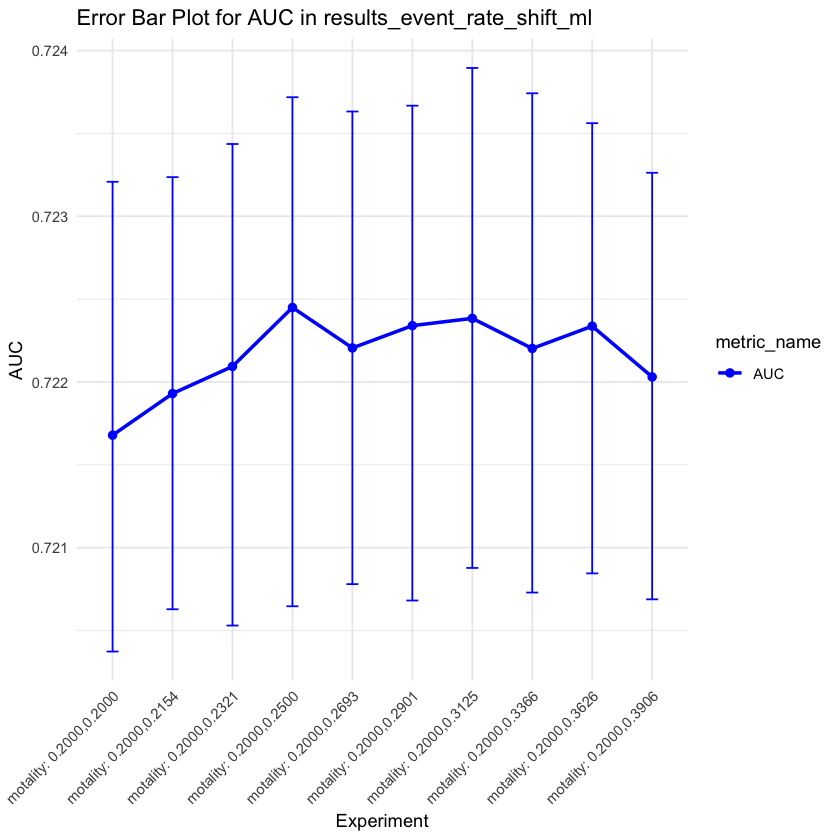

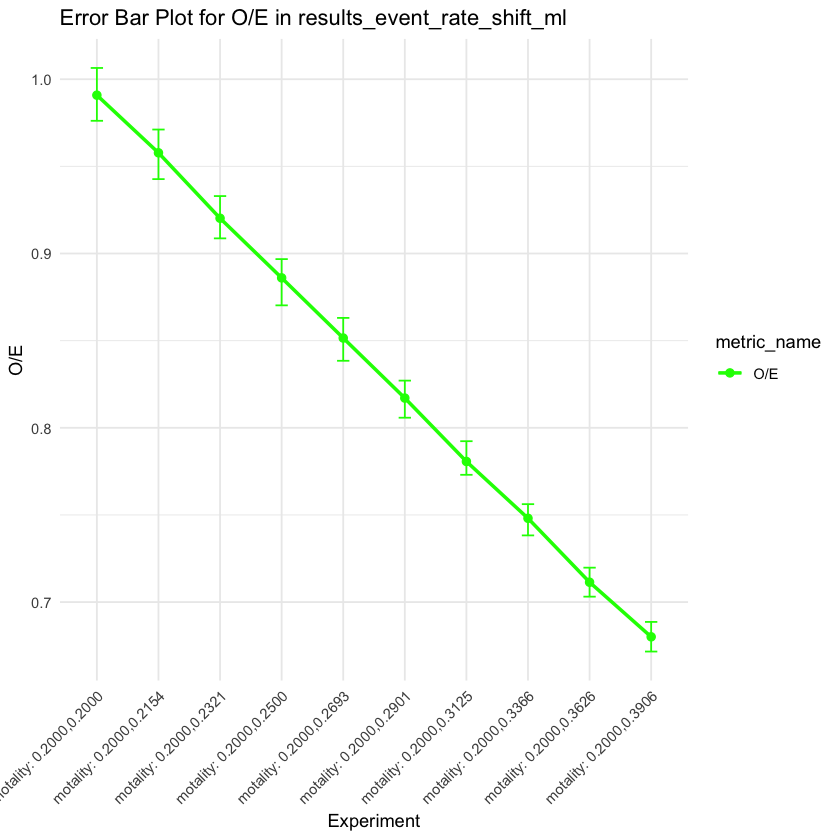

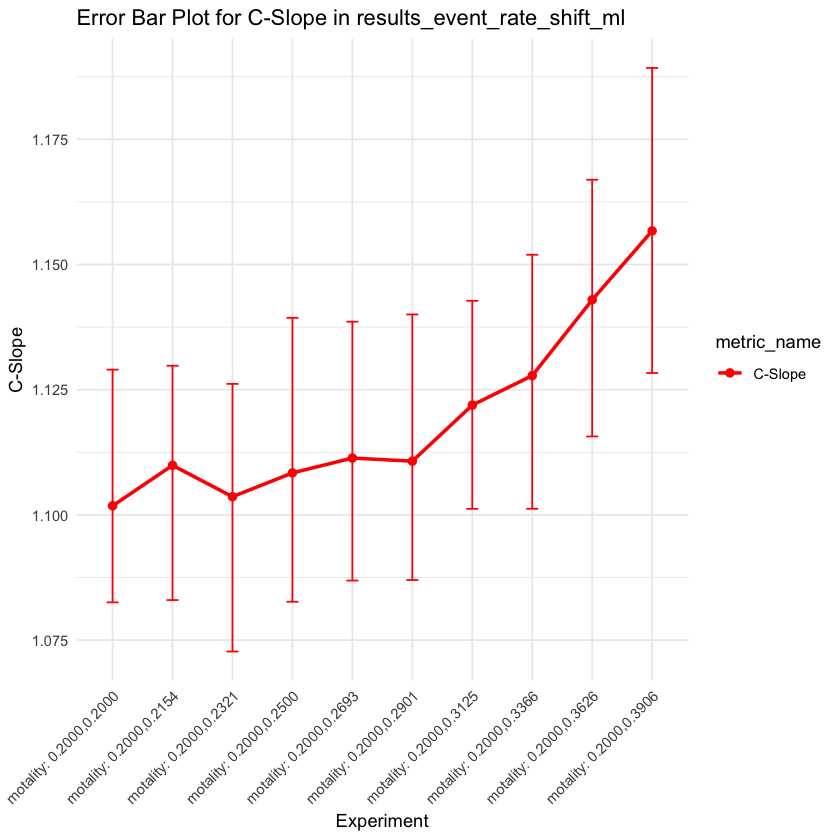

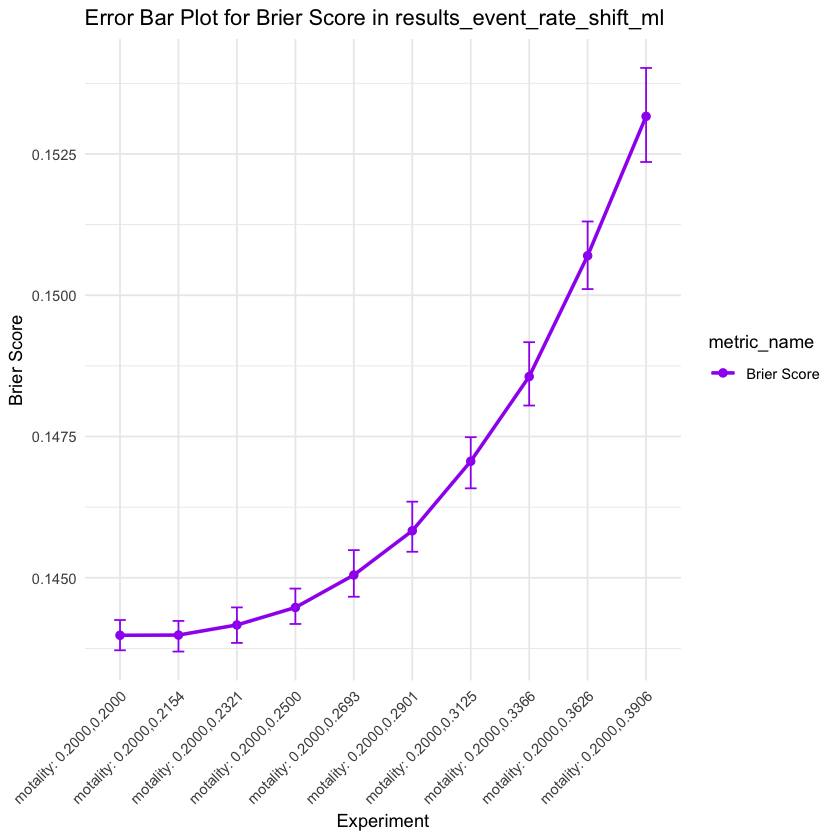

In [17]:
create_error_bar_plots(results_event_rate_shift_ml,"results_event_rate_shift_ml")